# Analytics

#### Date: 2020/05

#### SUMMARY:

- This notebook represents the project quality analysis of the date exposed right above. 

### TEAM:

##### Semester: 2020/02
##### Professor: Hilmer Neri

##### Members:

- Felipe Campos
- Gabriel Albino	 
- Helena Bretas	 
- Lucas Machado	 
- Cibele Freitas	 
- Cristian Furtado	 
- Eduarda Rodrigues	 
- João Pedro Lyra	 
- Mariana Oliveira	 
- Rafael Fernandes	 

### LIBRARIES

In [450]:
# Deal with data
import pandas as pd
import numpy as np
import json
from glob import glob
import os

# Deal with API request
import urllib3
from urllib3 import request

# Deal with visualization
import seaborn as sns
import matplotlib.pyplot as plt

### GRAPH SETTINGS

In [451]:
%config InlineBackend.figure_format ='retina'
sns.set(font_scale=1.5)
sns.set_style('darkgrid',
              {'xtick.bottom' : True,
               'ytick.left': True,
               'grid.linestyle':'--',
               'font.monospace': ['Computer Modern Typewriter'],
               'axes.edgecolor' : 'white'})

### DATAFRAME SETTINGS

In [452]:
pd.set_option("display.max_rows", None, "display.max_columns", None)

### SonarCloud

##### repo names, lenguage and path to the folder with all your jsons

In [453]:
#insert the repo names and used lenguages

repos = ['frontend', 'gateway', 'etl_tse', 'etl_twitter', 'etl_camara', 'etl_news']
language = [['frontend', 'js'], 
            ['gateway', 'py'], 
            ['etl_tse', 'py'], 
            ['etl_twitter', 'py'], 
            ['etl_camara', 'py'], 
            ['etl_news', 'py']]

repos_lenguage = {}

for item in language:
    repos_lenguage[f"{item[0]}"] = item[1]
    

In [454]:
repos_lenguage

{'frontend': 'js',
 'gateway': 'py',
 'etl_tse': 'py',
 'etl_twitter': 'py',
 'etl_camara': 'py',
 'etl_news': 'py'}

In [455]:
jsons = glob('analytics-raw-data/*.json') # add the path here

In [456]:
def read_json(json_path):
    
    with open(json_path) as json_file:
        json_obj = json.load(json_file)
        
    return json_obj

def create_base_component_df(json_list):
    
    df = pd.DataFrame()

    for i in json_list:

        base_component = read_json(i)

        base_component_data = base_component['baseComponent']['measures']

        base_component_df = pd.DataFrame(base_component_data)

        base_component_df['filename'] = os.path.basename(i)

        df = df.append(base_component_df, ignore_index=True)
        
    aux_df = df['filename'].str.split(r"fga-eps-mds-2020_2-(.*?)-(.*?).json", expand=True)
    
    df['repository'] = aux_df[1]
    
    df['version'] = aux_df[2]
    
    df = df.sort_values(by=['repository', 'version'])
        
    return df, repos

#### Create base component dataframe and repos list

In [457]:
base_component_df, repos = create_base_component_df(jsons)

In [458]:
base_component_df.head(10)

,metric,value,bestValue,filename,repository,version
161,duplicated_lines_density,0.0,True,fga-eps-mds-2020_2-etl_camara-01-05-2021.json,etl_camara,01-05-2021
162,functions,30,NaN,fga-eps-mds-2020_2-etl_camara-01-05-2021.json,etl_camara,01-05-2021
163,security_rating,3.0,False,fga-eps-mds-2020_2-etl_camara-01-05-2021.json,etl_camara,01-05-2021
164,files,5,NaN,fga-eps-mds-2020_2-etl_camara-01-05-2021.json,etl_camara,01-05-2021
165,complexity,88,NaN,fga-eps-mds-2020_2-etl_camara-01-05-2021.json,etl_camara,01-05-2021
166,ncloc,525,NaN,fga-eps-mds-2020_2-etl_camara-01-05-2021.json,etl_camara,01-05-2021
167,coverage,0.0,False,fga-eps-mds-2020_2-etl_camara-01-05-2021.json,etl_camara,01-05-2021
168,reliability_rating,1.0,True,fga-eps-mds-2020_2-etl_camara-01-05-2021.json,etl_camara,01-05-2021
169,comment_lines_density,9.2,False,fga-eps-mds-2020_2-etl_camara-01-05-2021.json,etl_camara,01-05-2021
312,duplicated_lines_density,0.0,True,fga-eps-mds-2020_2-etl_camara-02-05-2021.json,etl_camara,02-05-2021


#### Create dataframe per file

In [459]:
metric_list = ['files',
               'functions',
               'complexity',
               'comment_lines_density',
               'duplicated_lines_density',
               'coverage',
               'ncloc',
               'security_rating',
               'tests',
               'test_success_density',
               'test_execution_time',
               'reliability_rating']

len(metric_list)

12

In [460]:
def metric_per_file(json):
    
    file_json = []
    
    for component in json['components']:
        if component['qualifier'] == 'FIL':
            file_json.append(component)
            
    return file_json

In [461]:
def generate_file_dataframe_per_release(metric_list, json, language_extension):
    
    df_columns = metric_list
    df = pd.DataFrame(columns = df_columns)
    
    for file in json:
        try:
            if file['language'] == language_extension:
                for measure in file['measures']:
                    df.at[file['path'], measure['metric']] = measure['value']
        except:
            pass
        
    df.reset_index(inplace = True)
    df = df.rename({'index': 'path'}, axis=1).drop(['files'], axis=1)

    return df

In [462]:
def create_file_df(json_list):
    
    df = pd.DataFrame()

    for i in json_list:

        file_component = read_json(i)
        file_component_data = metric_per_file(file_component)
        file_name = os.path.basename(i)
               
        file_repository = file_name.split("-", 5)[4]
        file_lenguage = repos_lenguage[f"{file_repository}"]
        
        file_component_df = generate_file_dataframe_per_release(metric_list, 
                                                                file_component_data,
                                                                language_extension = file_lenguage)
        file_component_df['filename'] = file_name

        df = df.append(file_component_df, ignore_index=True)
        
    # replace TeamName by yours.    
    aux_df = df['filename'].str.split(r"fga-eps-mds-2020_2-(.*?)-(.*?).json", expand=True)
    
    df['repository'] = aux_df[1]
    
    df['version'] = aux_df[2]
    
    df = df.sort_values(by=['repository', 'version'])
        
    return df

In [463]:
file_component_df = create_file_df(jsons)

In [464]:
file_component_df.head(10)

,path,functions,complexity,comment_lines_density,duplicated_lines_density,coverage,ncloc,security_rating,tests,test_success_density,test_execution_time,reliability_rating,filename,repository,version
198,src/api/__init__.py,0,0,NaN,0.0,NaN,0,1.0,NaN,100.0,NaN,1.0,fga-eps-mds-2020_2-etl_camara-01-05-2021.json,etl_camara,01-05-2021
199,src/etl/__init__.py,0,0,NaN,0.0,NaN,0,1.0,NaN,100.0,NaN,1.0,fga-eps-mds-2020_2-etl_camara-01-05-2021.json,etl_camara,01-05-2021
200,src/api/api.py,25,82,13.1,0.0,0.0,345,3.0,NaN,100.0,NaN,1.0,fga-eps-mds-2020_2-etl_camara-01-05-2021.json,etl_camara,01-05-2021
201,src/app.py,1,2,0.0,0.0,0.0,20,1.0,NaN,100.0,NaN,1.0,fga-eps-mds-2020_2-etl_camara-01-05-2021.json,etl_camara,01-05-2021
202,src/models.py,4,4,0.6,0.0,0.0,160,1.0,NaN,100.0,NaN,1.0,fga-eps-mds-2020_2-etl_camara-01-05-2021.json,etl_camara,01-05-2021
377,src/api/__init__.py,0,0,NaN,0.0,NaN,0,1.0,NaN,100.0,NaN,1.0,fga-eps-mds-2020_2-etl_camara-02-05-2021.json,etl_camara,02-05-2021
378,src/etl/__init__.py,0,0,NaN,0.0,NaN,0,1.0,NaN,100.0,NaN,1.0,fga-eps-mds-2020_2-etl_camara-02-05-2021.json,etl_camara,02-05-2021
379,src/api/api.py,25,82,13.1,0.0,0.0,345,3.0,NaN,100.0,NaN,1.0,fga-eps-mds-2020_2-etl_camara-02-05-2021.json,etl_camara,02-05-2021
380,src/app.py,1,2,0.0,0.0,0.0,20,1.0,NaN,100.0,NaN,1.0,fga-eps-mds-2020_2-etl_camara-02-05-2021.json,etl_camara,02-05-2021
381,src/models.py,4,4,0.6,0.0,0.0,160,1.0,NaN,100.0,NaN,1.0,fga-eps-mds-2020_2-etl_camara-02-05-2021.json,etl_camara,02-05-2021


In [465]:
file_component_df.to_excel('data/data.xlsx', index = False)

In [466]:
file_component_df.repository.unique()

array(['etl_camara', 'etl_news', 'etl_tse', 'etl_twitter', 'frontend',
       'gateway'], dtype=object)

#### Create dataframe per repository

In [467]:
repository_dataframes = {} 

for repository in repos:
    df = file_component_df[file_component_df['repository'] == f"{repository}"]
    df.name = f"{repository}"
    repository_dataframes[f"{repository}"] = df
    
repository_dataframes.keys()

dict_keys(['frontend', 'gateway', 'etl_tse', 'etl_twitter', 'etl_camara', 'etl_news'])

In [468]:
repository_dataframes["etl_tse"]

,path,functions,complexity,comment_lines_density,duplicated_lines_density,coverage,ncloc,security_rating,tests,test_success_density,test_execution_time,reliability_rating,filename,repository,version
572,src/api/__init__.py,0,0,NaN,0.0,NaN,0,1.0,NaN,100.0,NaN,1.0,fga-eps-mds-2020_2-etl_tse-01-05-2021.json,etl_tse,01-05-2021
573,src/etl/__init__.py,0,0,NaN,0.0,NaN,0,1.0,NaN,100.0,NaN,1.0,fga-eps-mds-2020_2-etl_tse-01-05-2021.json,etl_tse,01-05-2021
574,src/api/api.py,1,2,6.3,0.0,0.0,15,1.0,NaN,100.0,NaN,1.0,fga-eps-mds-2020_2-etl_tse-01-05-2021.json,etl_tse,01-05-2021
575,src/app.py,1,2,0.0,0.0,0.0,19,1.0,NaN,100.0,NaN,1.0,fga-eps-mds-2020_2-etl_tse-01-05-2021.json,etl_tse,01-05-2021
576,src/models.py,2,2,0.0,0.0,0.0,63,1.0,NaN,100.0,NaN,1.0,fga-eps-mds-2020_2-etl_tse-01-05-2021.json,etl_tse,01-05-2021
553,src/api/__init__.py,0,0,NaN,0.0,NaN,0,1.0,NaN,100.0,NaN,1.0,fga-eps-mds-2020_2-etl_tse-02-05-2021.json,etl_tse,02-05-2021
554,src/etl/__init__.py,0,0,NaN,0.0,NaN,0,1.0,NaN,100.0,NaN,1.0,fga-eps-mds-2020_2-etl_tse-02-05-2021.json,etl_tse,02-05-2021
555,src/api/api.py,1,2,6.3,0.0,0.0,15,1.0,NaN,100.0,NaN,1.0,fga-eps-mds-2020_2-etl_tse-02-05-2021.json,etl_tse,02-05-2021
556,src/app.py,1,2,0.0,0.0,0.0,19,1.0,NaN,100.0,NaN,1.0,fga-eps-mds-2020_2-etl_tse-02-05-2021.json,etl_tse,02-05-2021
557,src/models.py,2,2,0.0,0.0,0.0,63,1.0,NaN,100.0,NaN,1.0,fga-eps-mds-2020_2-etl_tse-02-05-2021.json,etl_tse,02-05-2021


### Metric calculations

##### COMPLEXITY

In [469]:
def m1(df):
    
    density_non_complex_files = len(df[(df['complexity'].astype(float)/df['functions'].astype(float)) < 10])/len(df)
    
    return density_non_complex_files

##### COMMENTS

In [470]:
def m2(df):
    
    density_comment_files = len(df[(df['comment_lines_density'].astype(float) > 10) & (df['comment_lines_density'].astype(float) < 30)])/len(df)
    
    return density_comment_files

##### DUPLICATIONS

In [471]:
def m3(df):
    
    duplication = len(df[(df['duplicated_lines_density'].astype(float) < 5)])/len(df)
    
    return duplication

### Calculate m1, m2 and m3 for each repository

In [472]:
def create_metrics_df(df):
    
    version_vec = df['version'].unique()
    
    m1_list = []
    m2_list = []
    m3_list = []
    repository_list = []
    version_list = []
    
    metrics_df = pd.DataFrame()
    
    for version in version_vec:

        version_df = df[df['version'] == version]

        m1_list.append(m1(version_df))
        m2_list.append(m2(version_df))
        m3_list.append(m3(version_df))
        repository_list.append(version_df['repository'].iloc[0])
        version_list.append(version)
        
    metrics_df = pd.DataFrame({'m1': m1_list,
                               'm2': m2_list,
                               'm3': m3_list,
                               'repository': repository_list, 
                               'version': version_list})
        
    return metrics_df

In [473]:
repository_metrics = {}

for repository, repo_df in repository_dataframes.items():   
    metrics_df = create_metrics_df(repo_df)
    metrics_df.name = f"{repository}"
    repository_metrics[f"{repository}"] = metrics_df


### Data visualization

- You must do this for each of your repositories

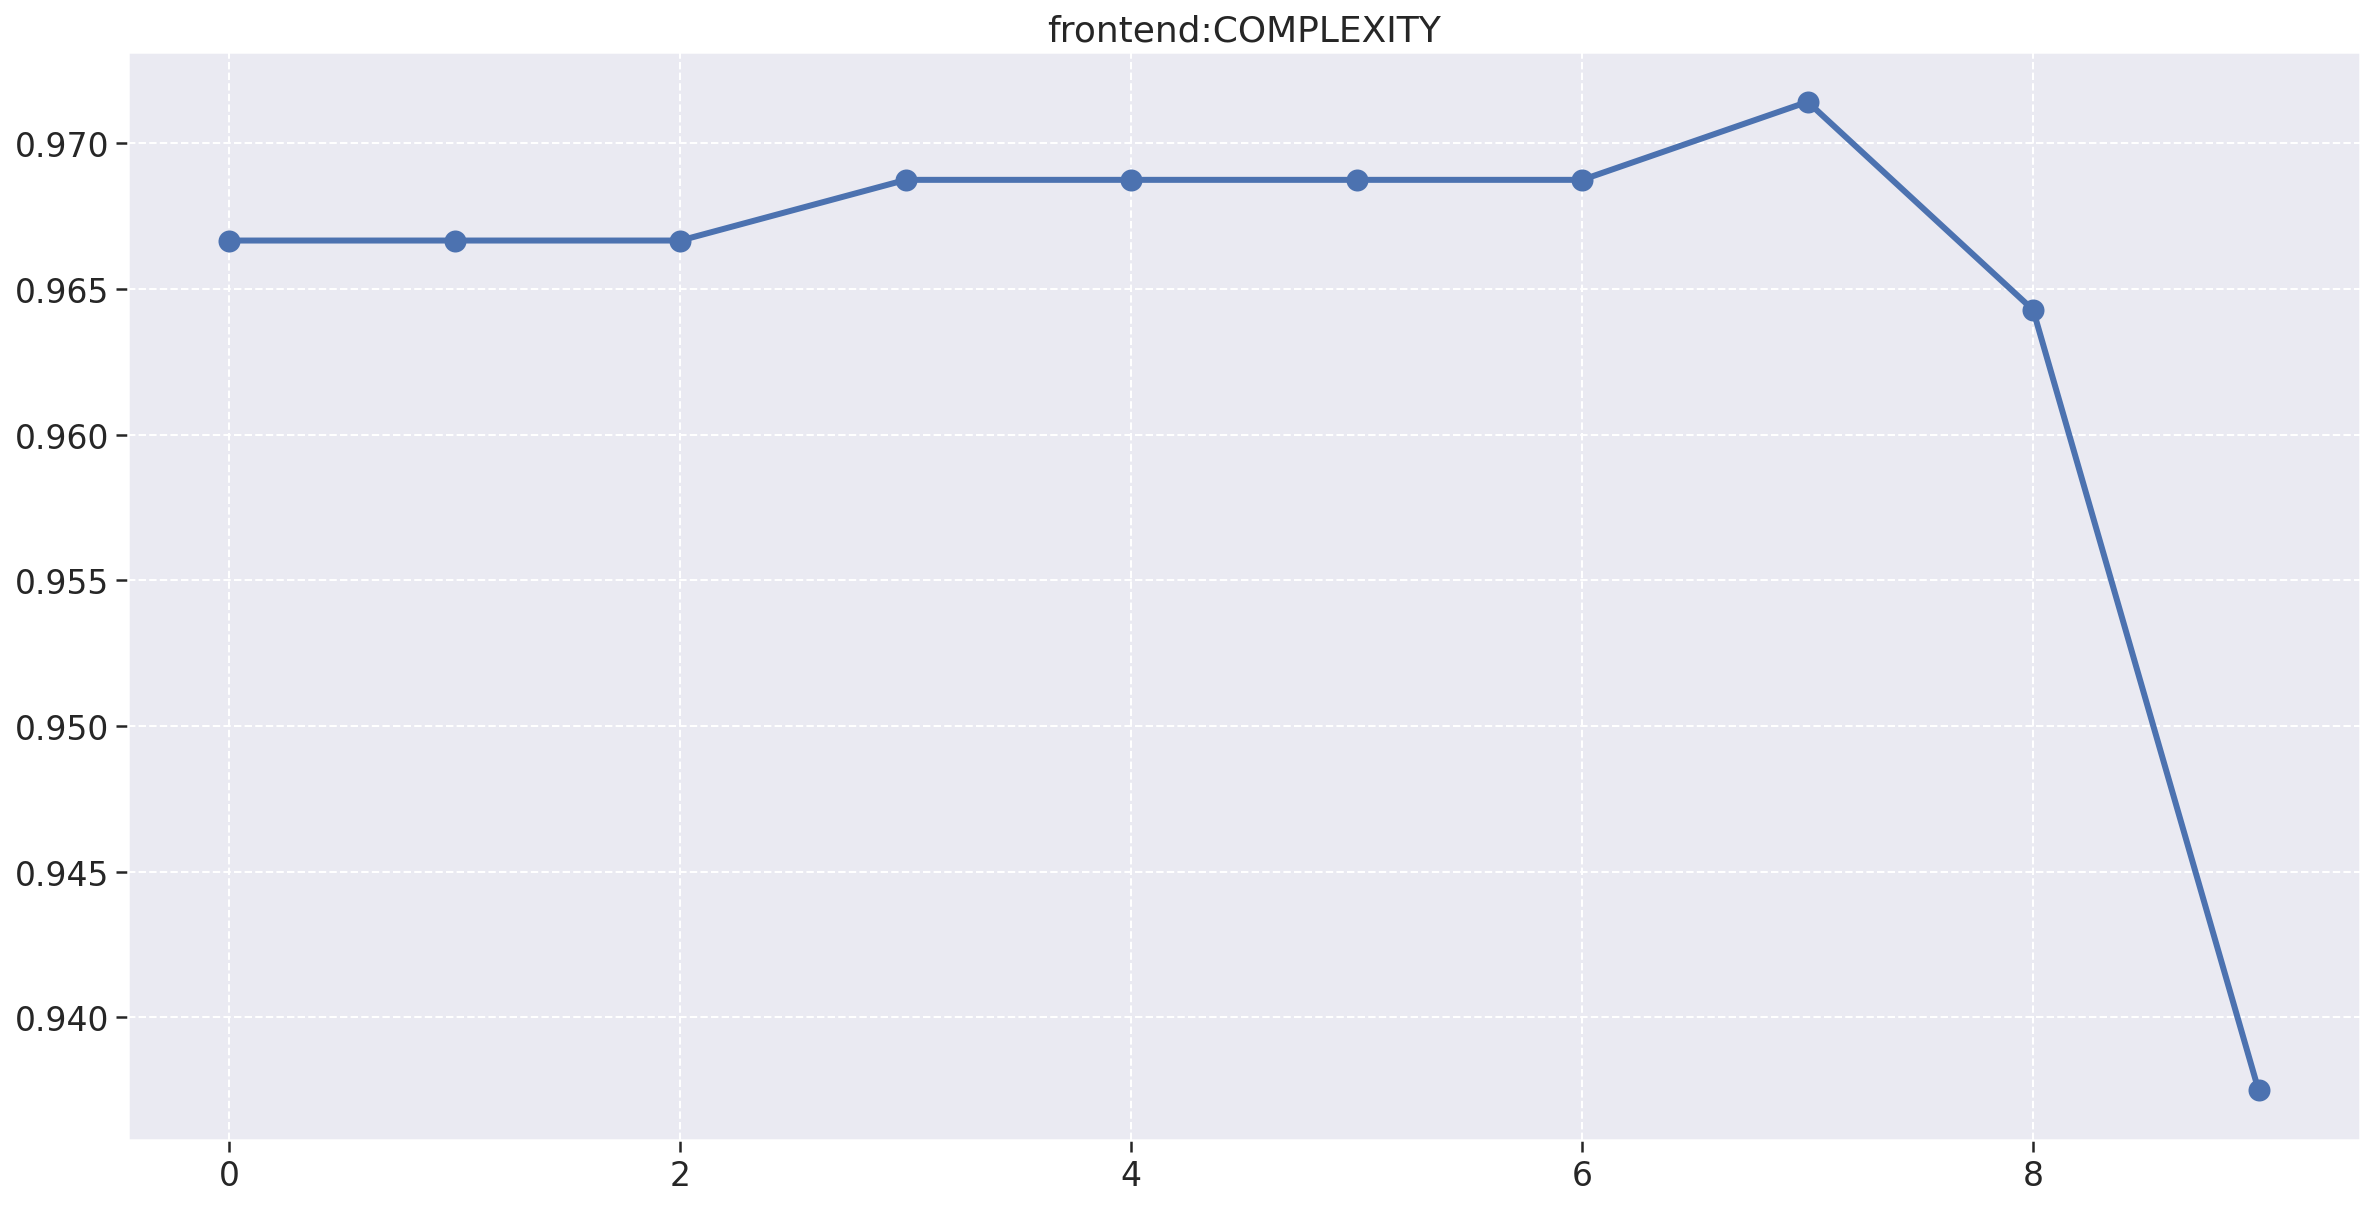

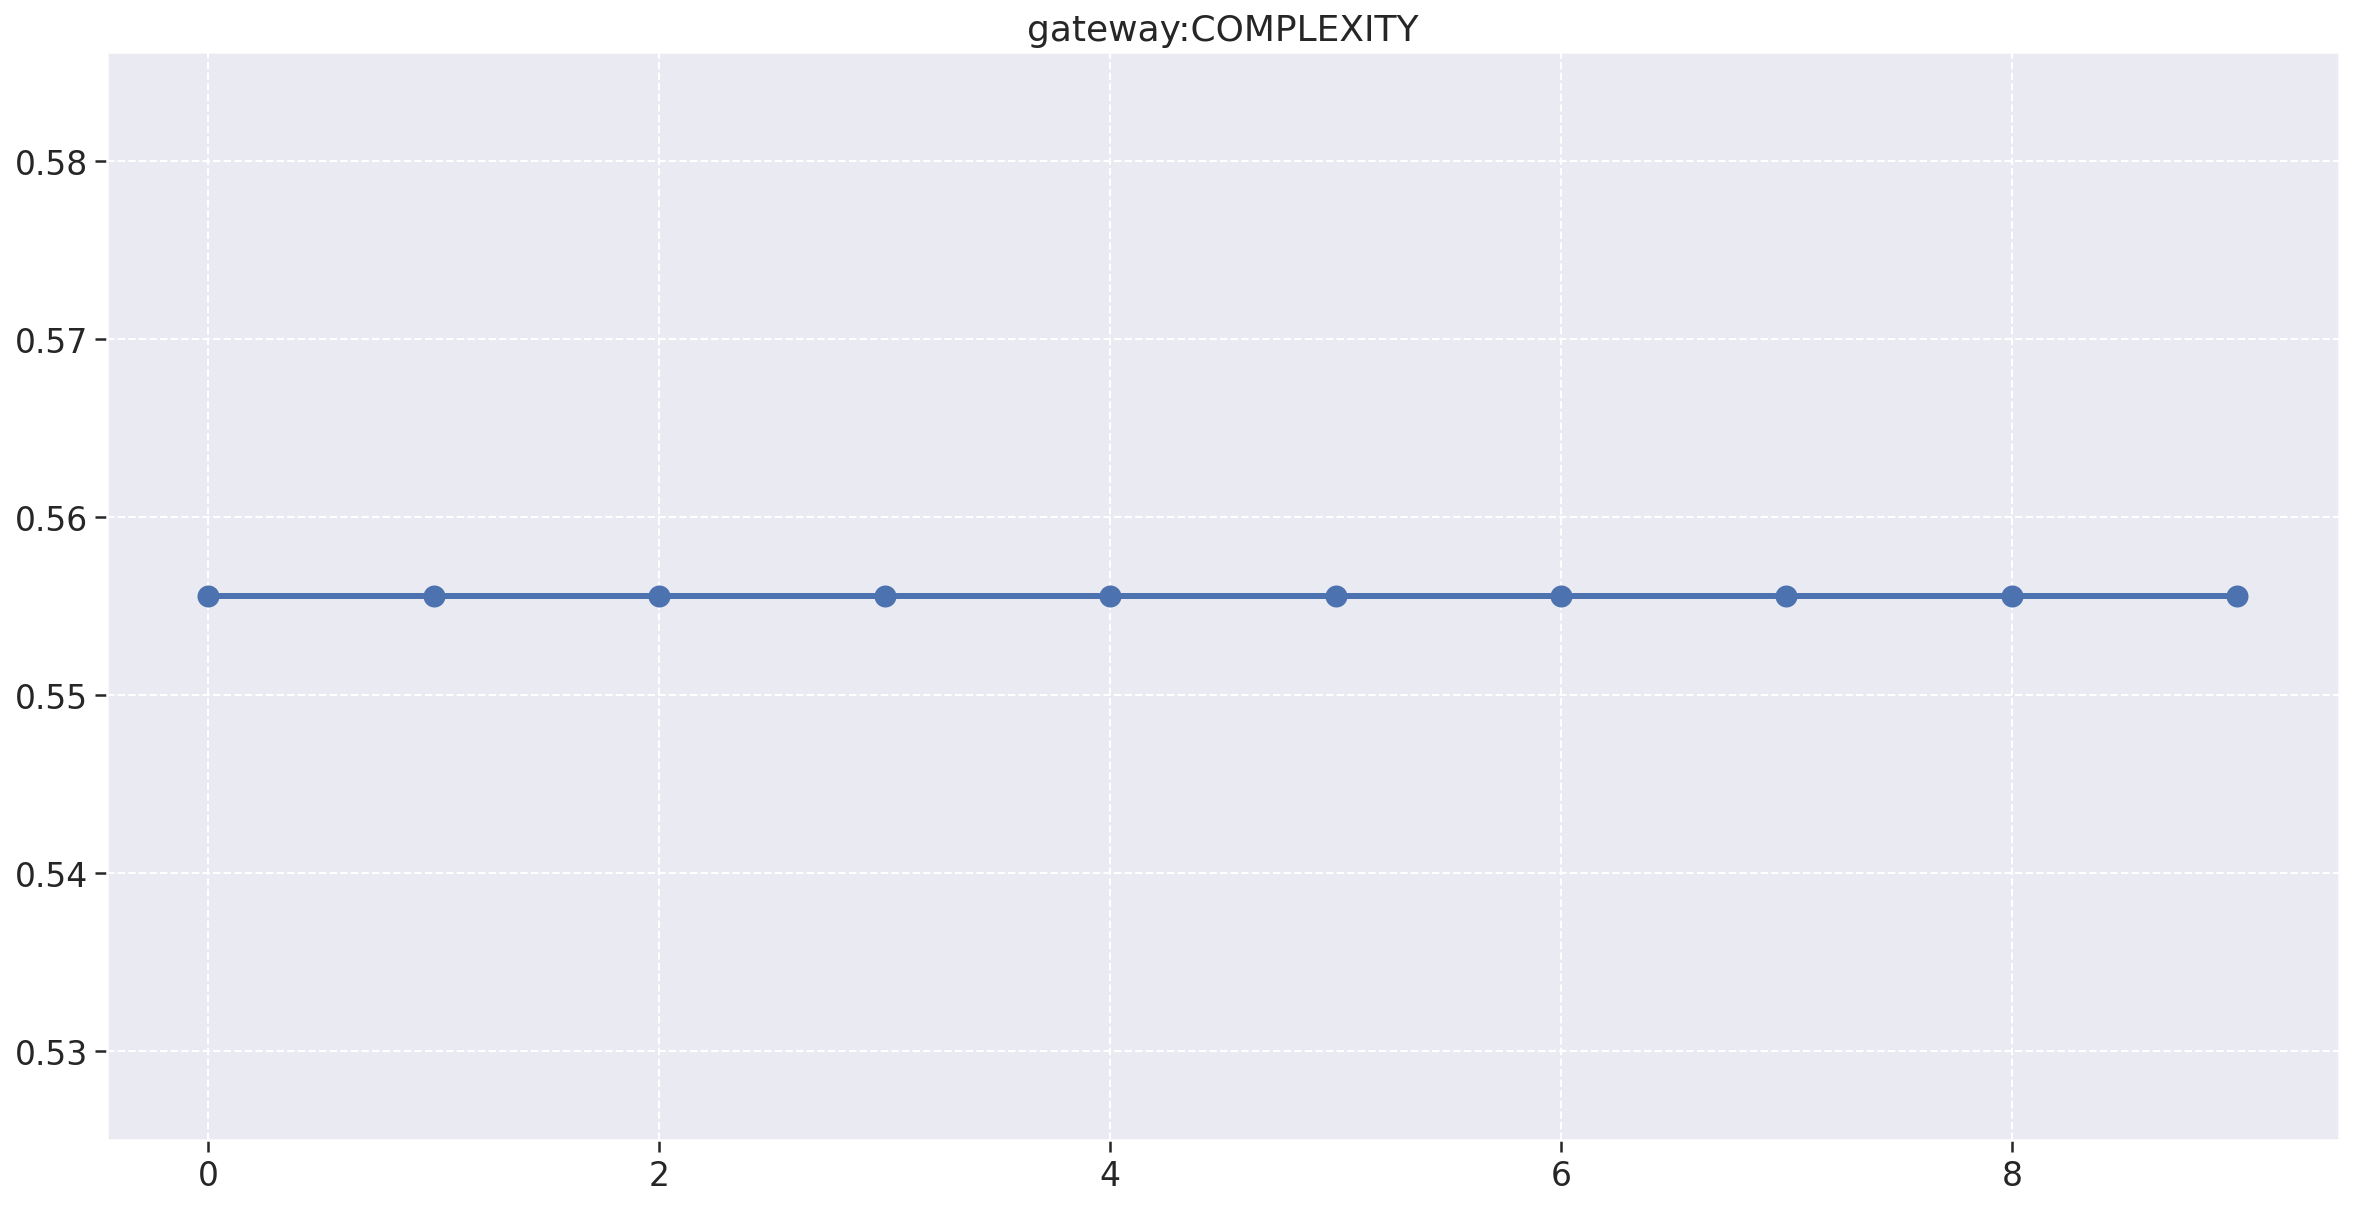

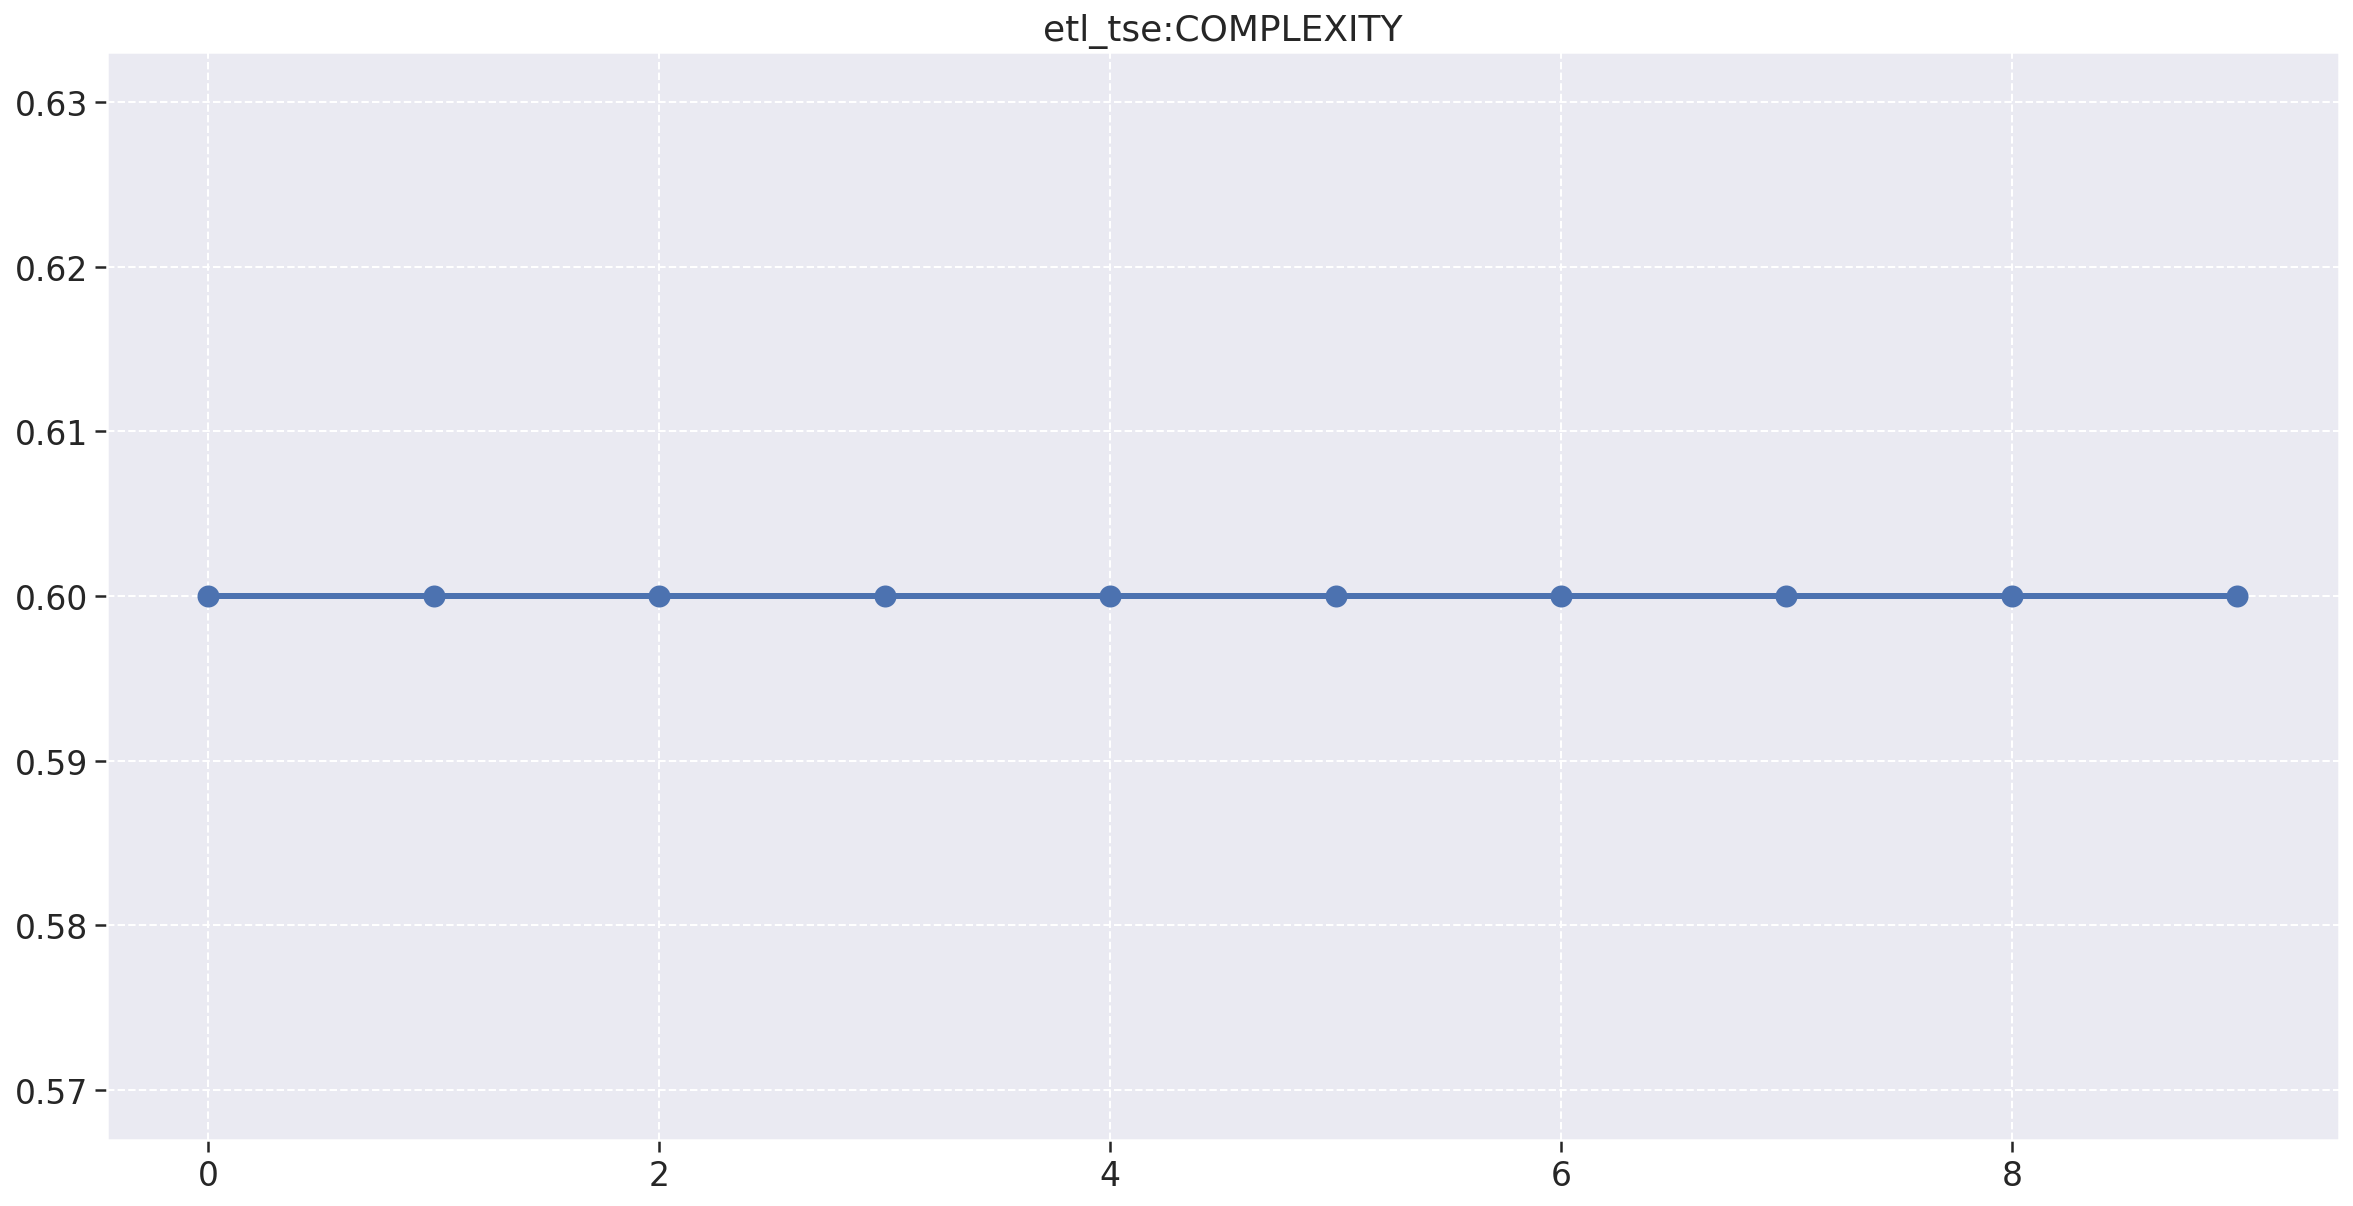

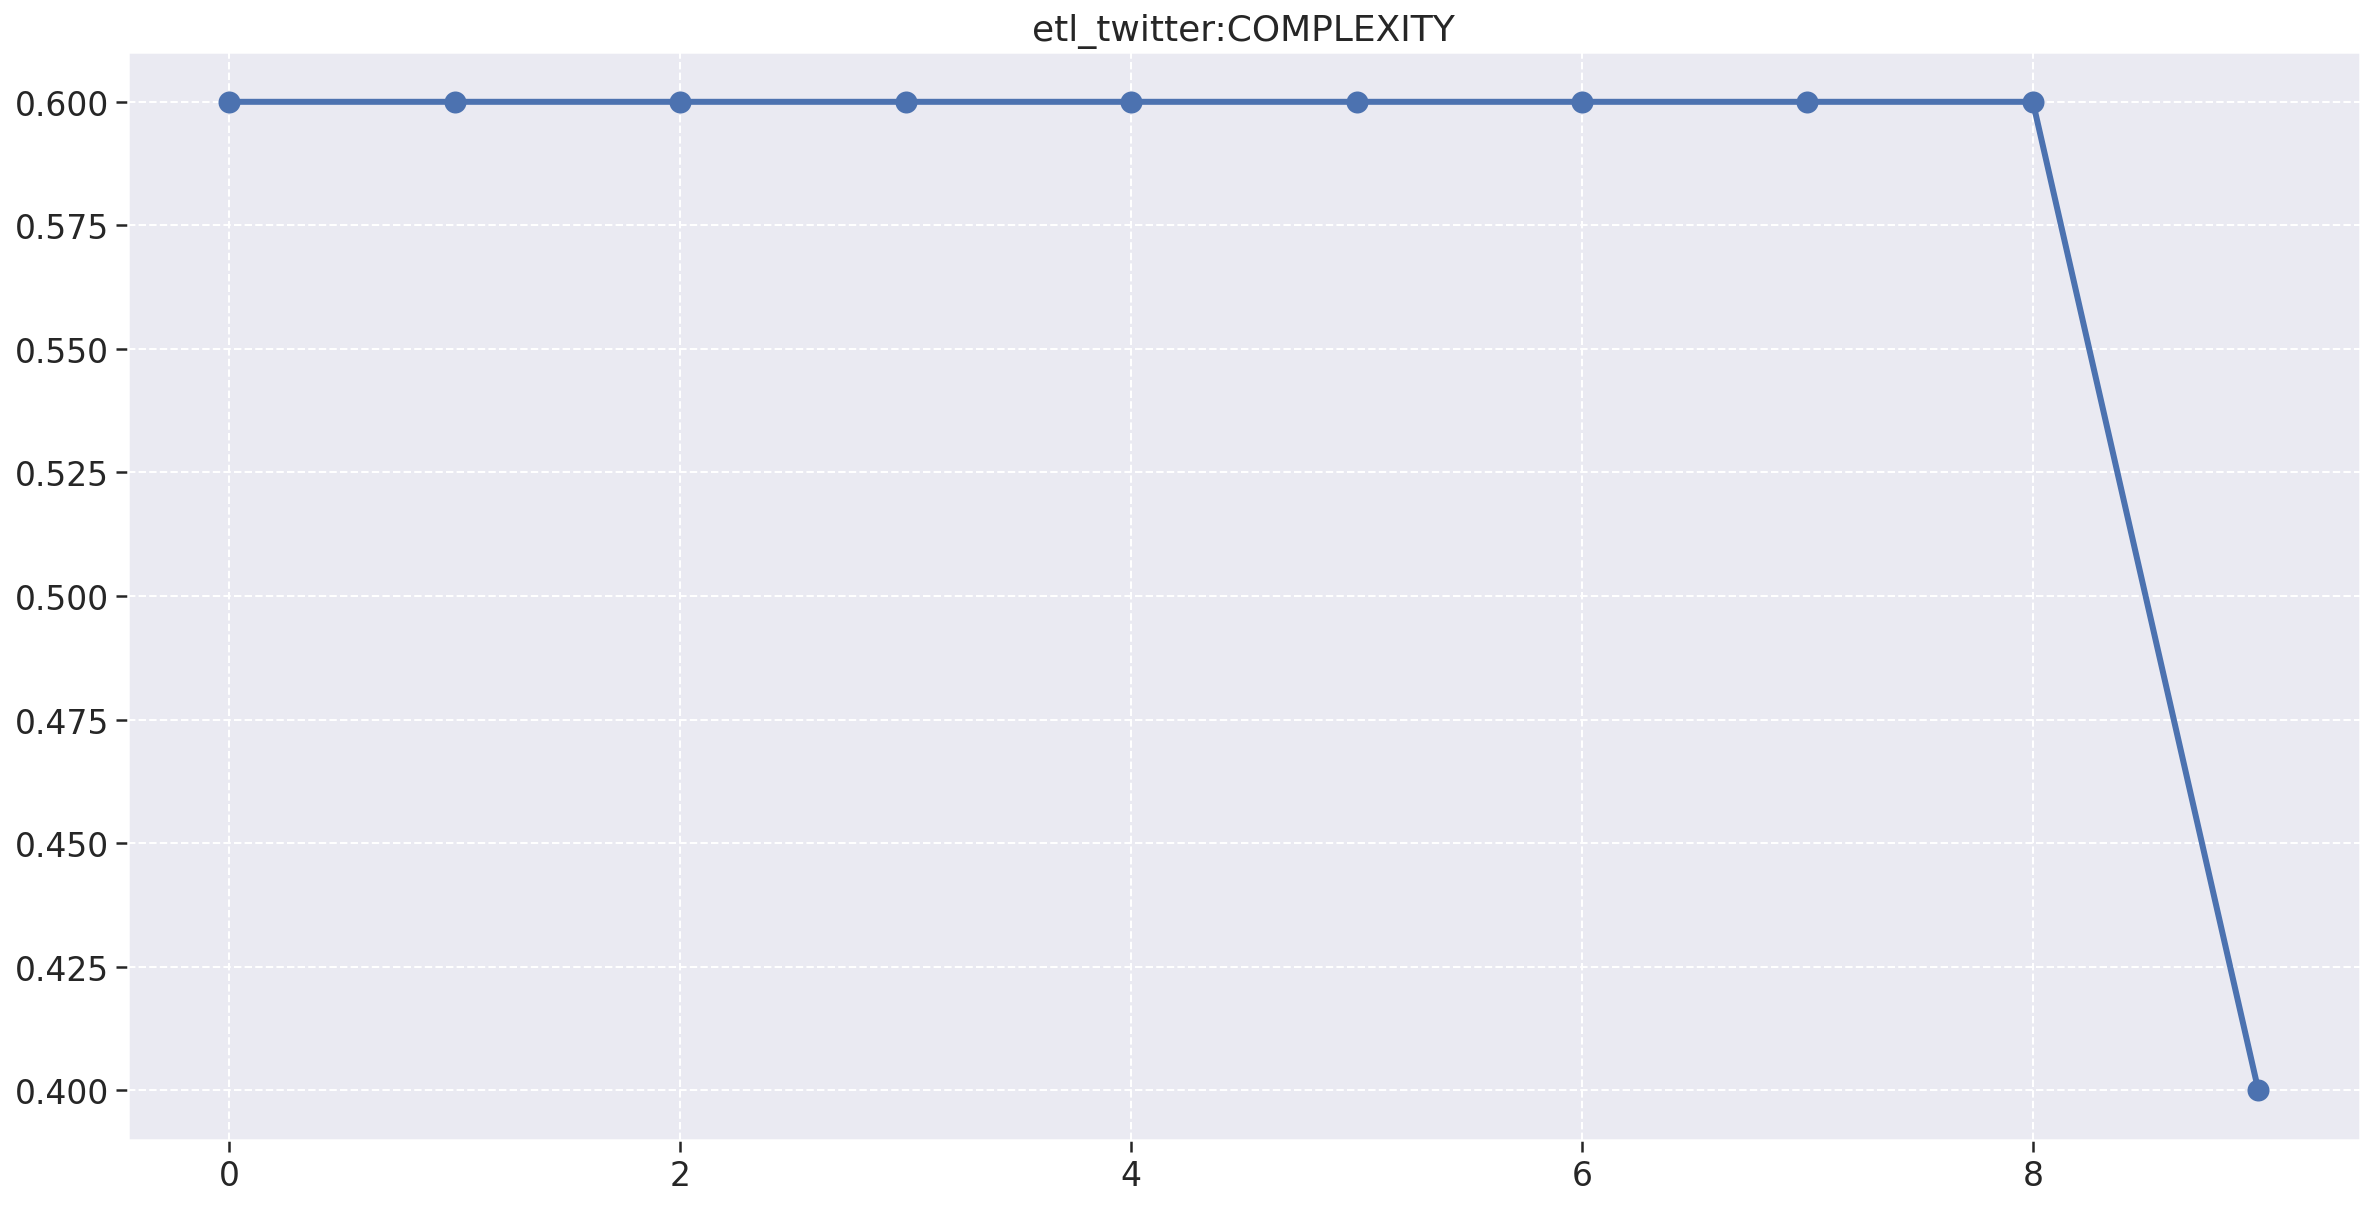

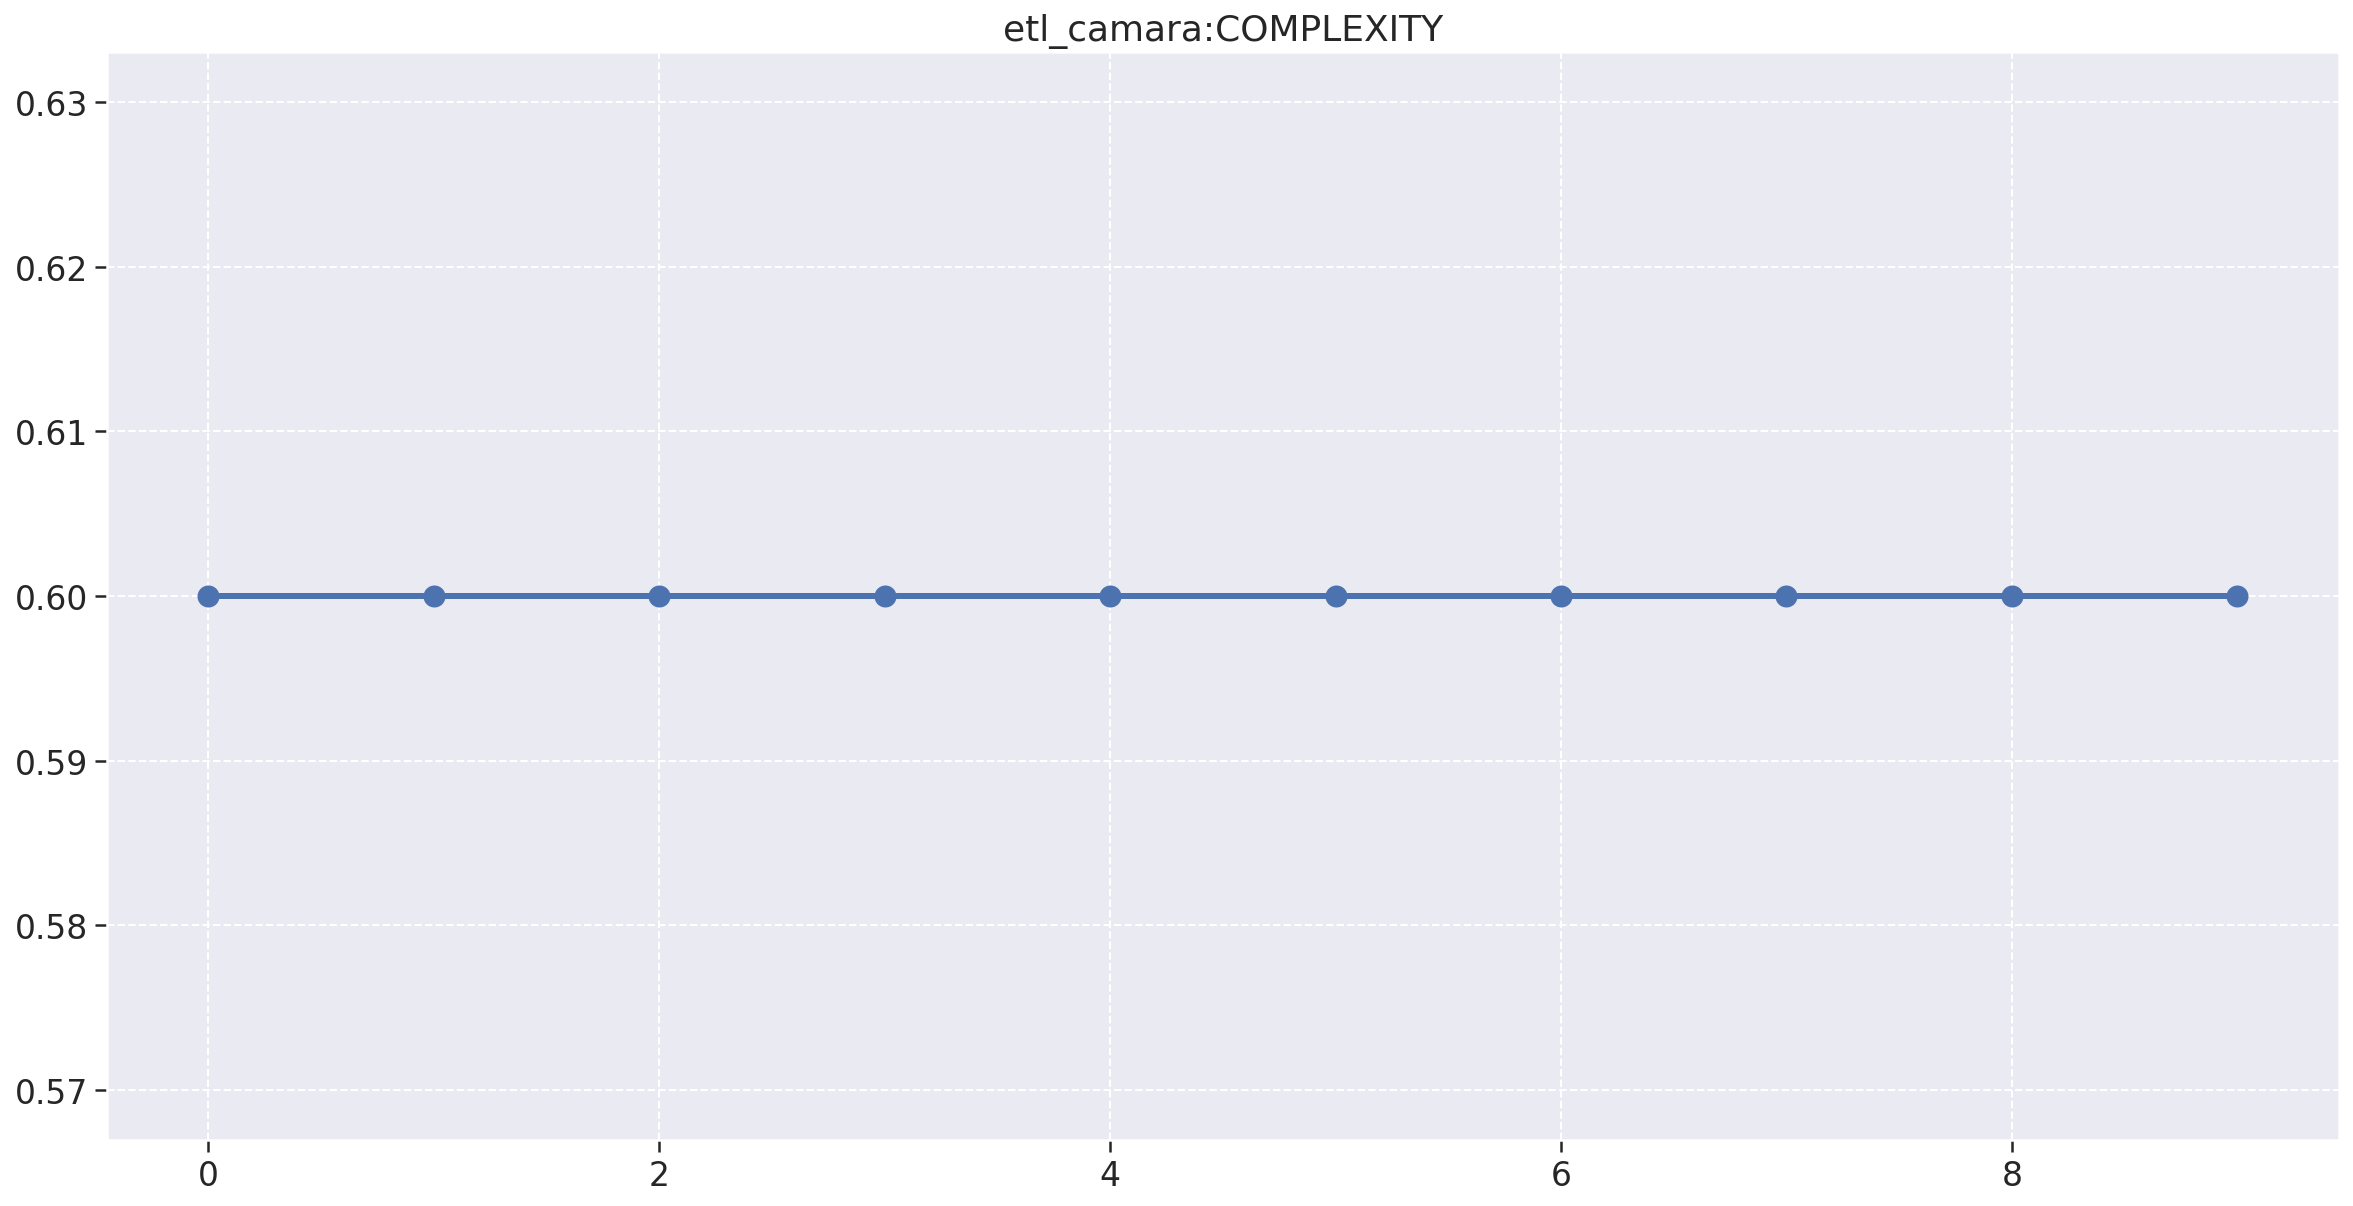

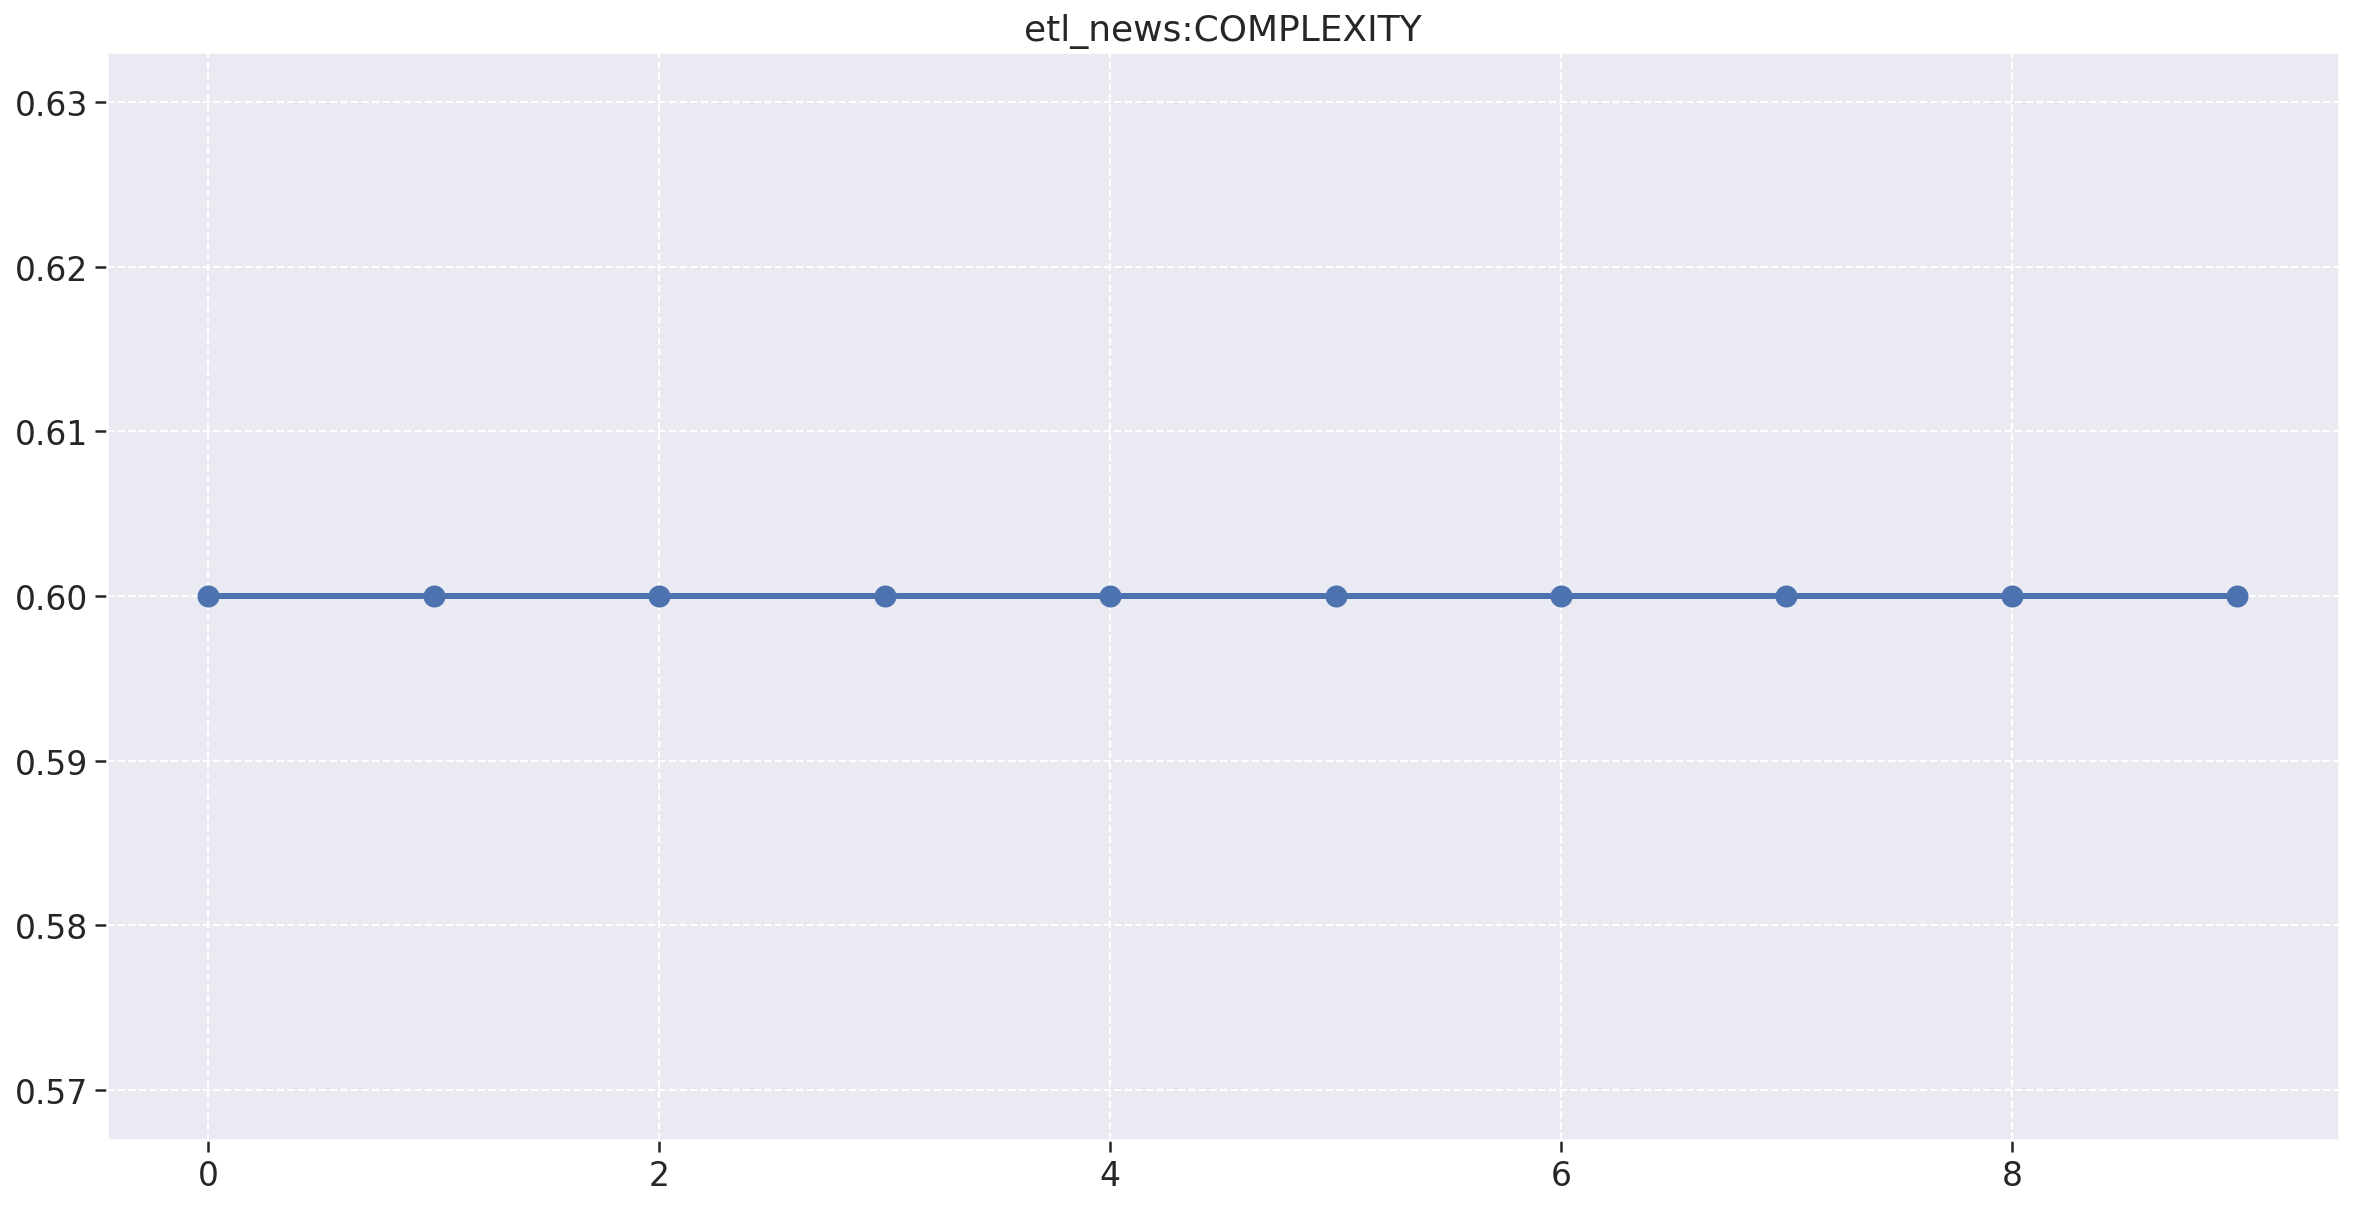

In [474]:
for repository, metrics_df in repository_metrics.items(): 
    fig = plt.figure(figsize=(20, 10))
    plt.title(f"{repository}:COMPLEXITY")
    plt.plot(metrics_df['m1'], linewidth=3, marker='o', markersize=10)

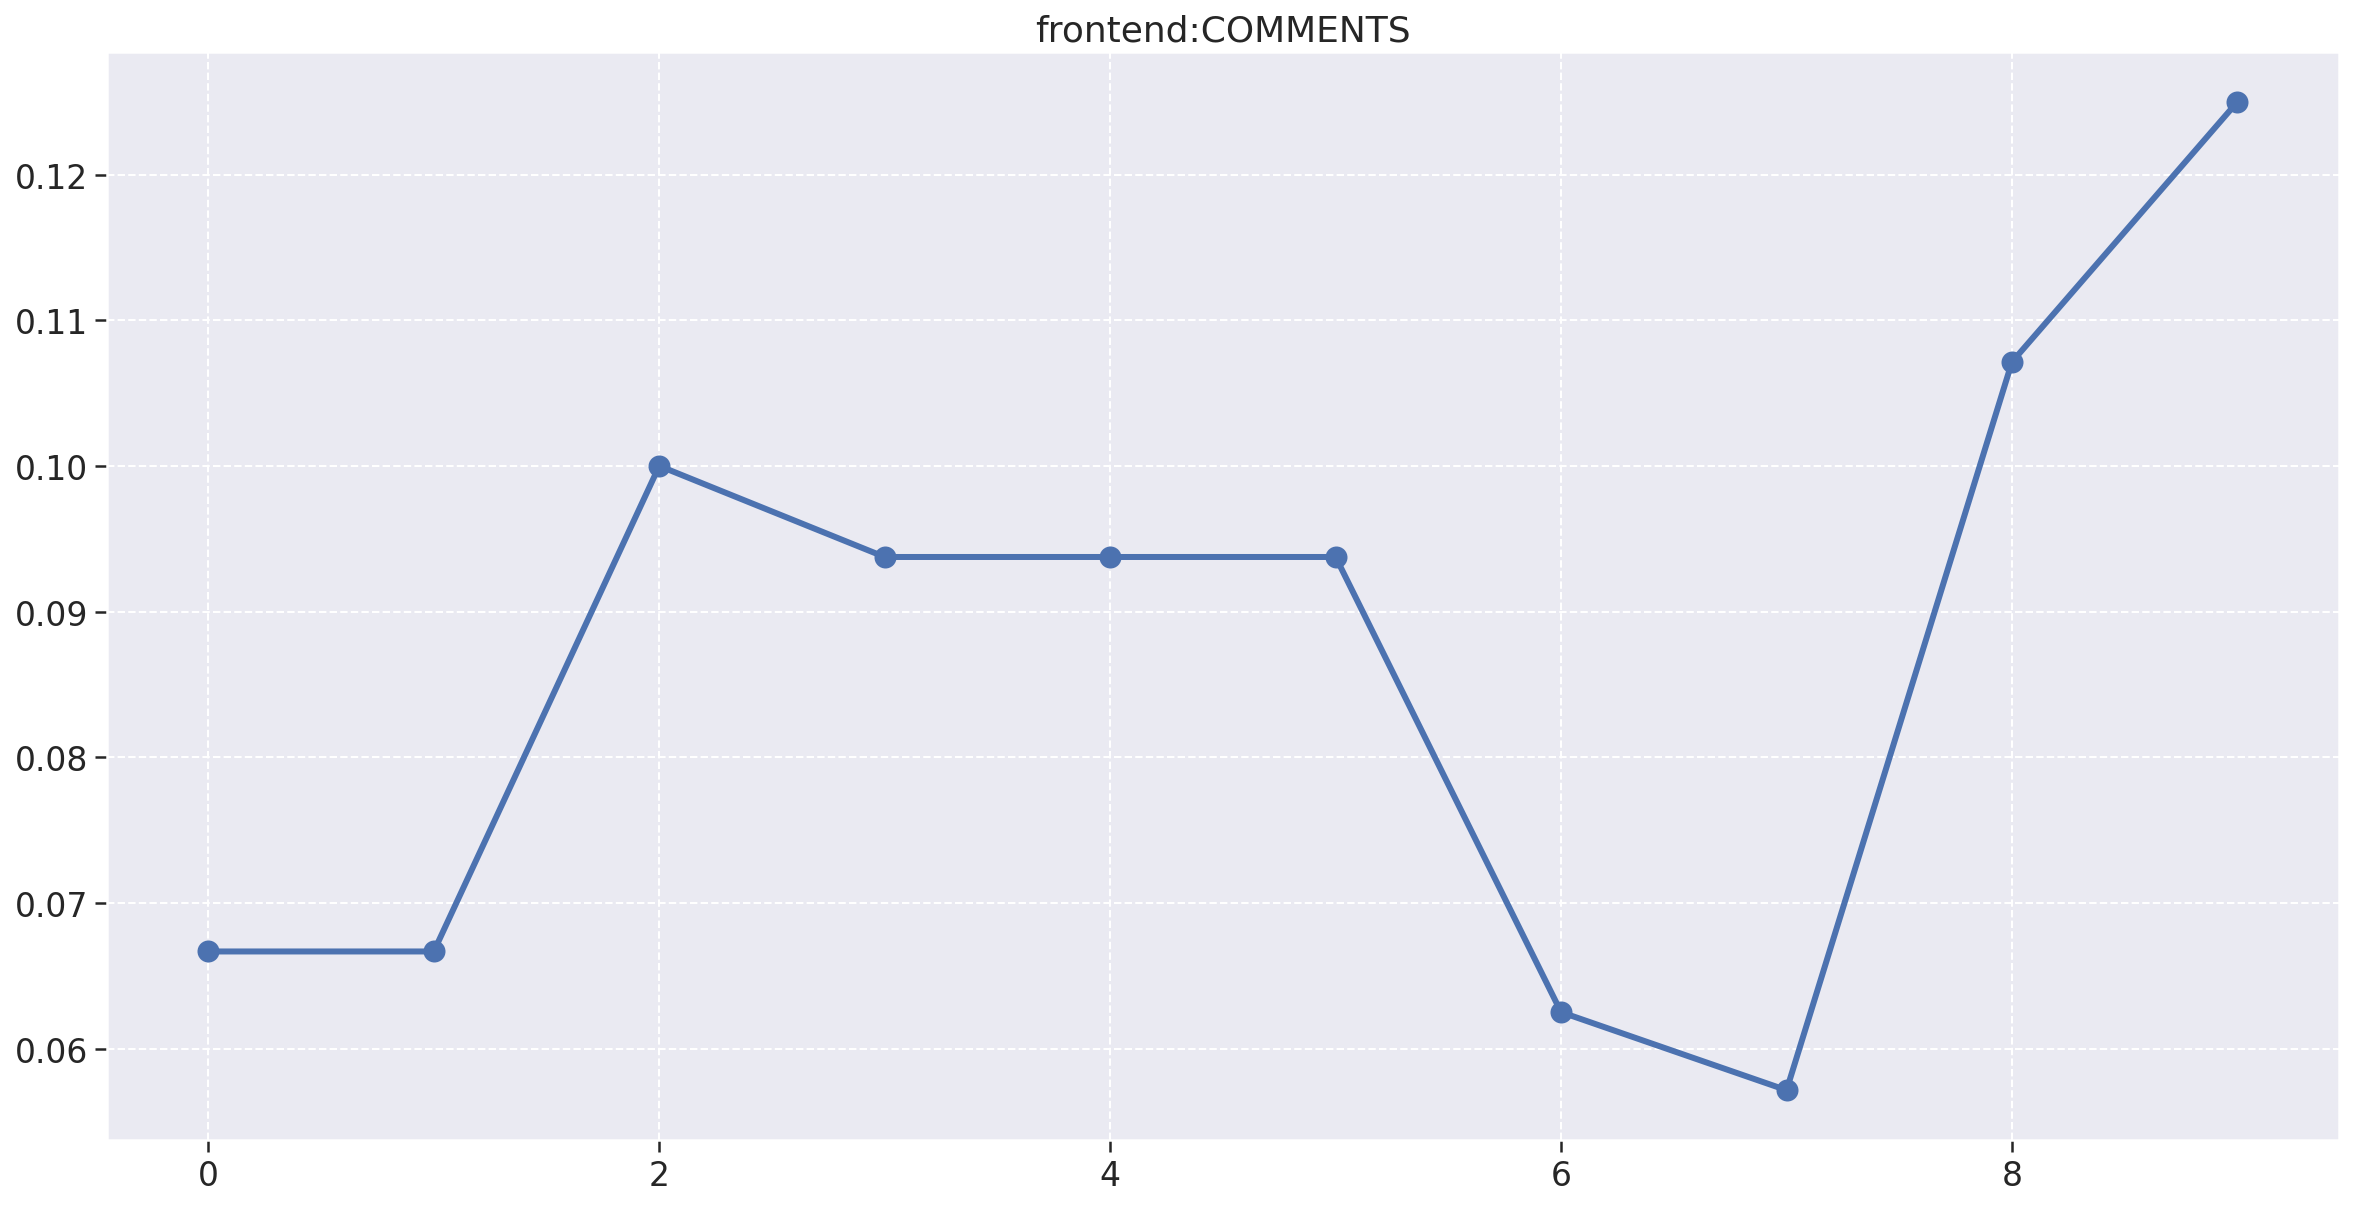

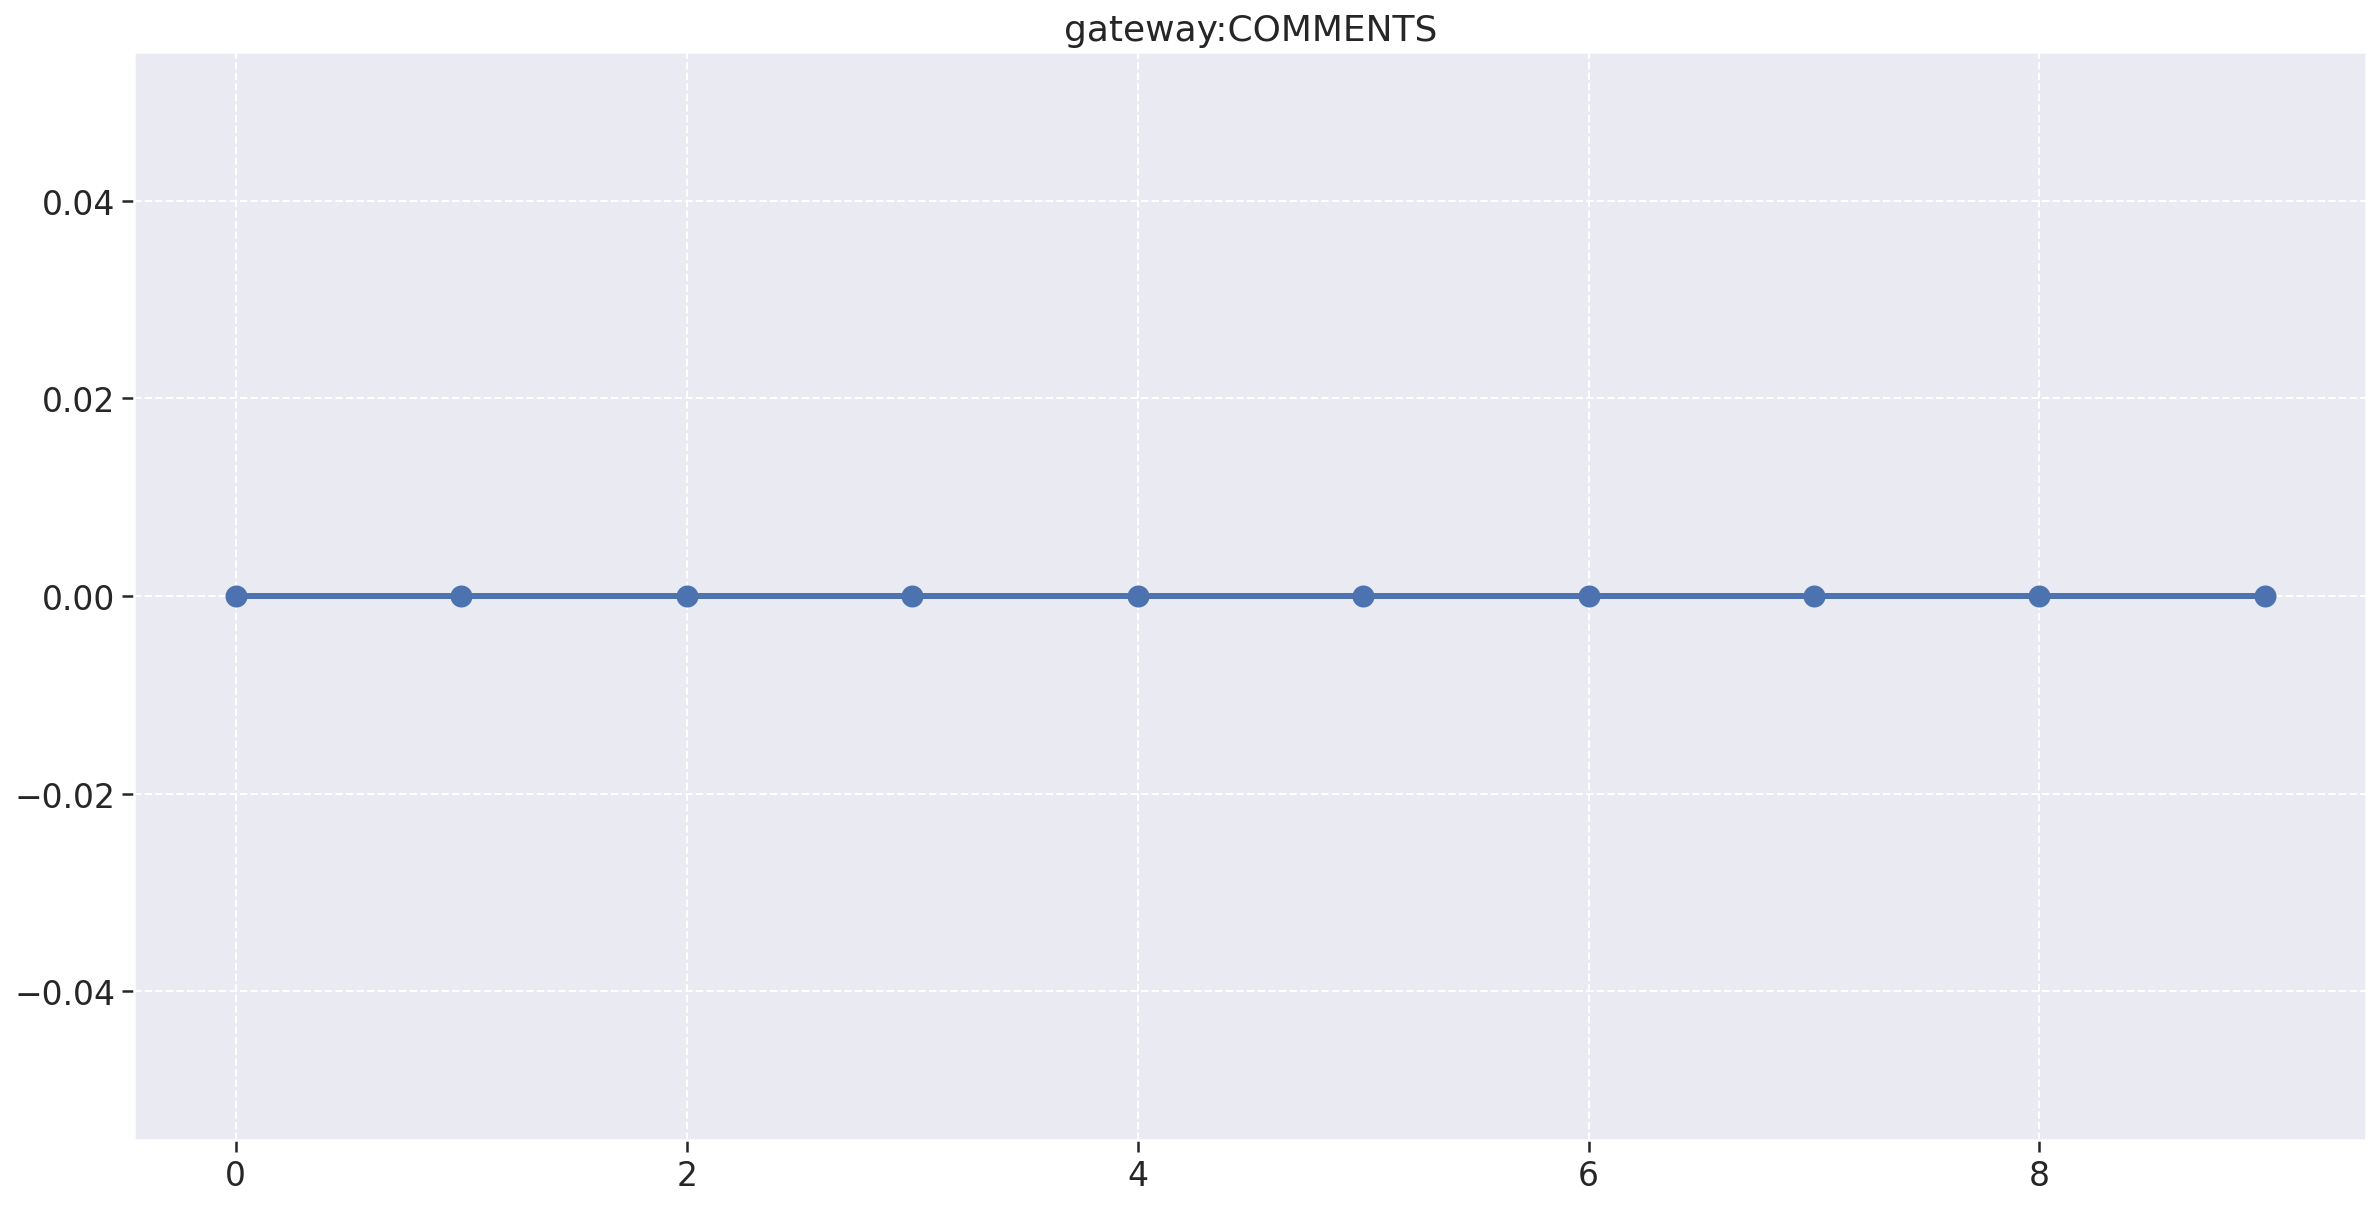

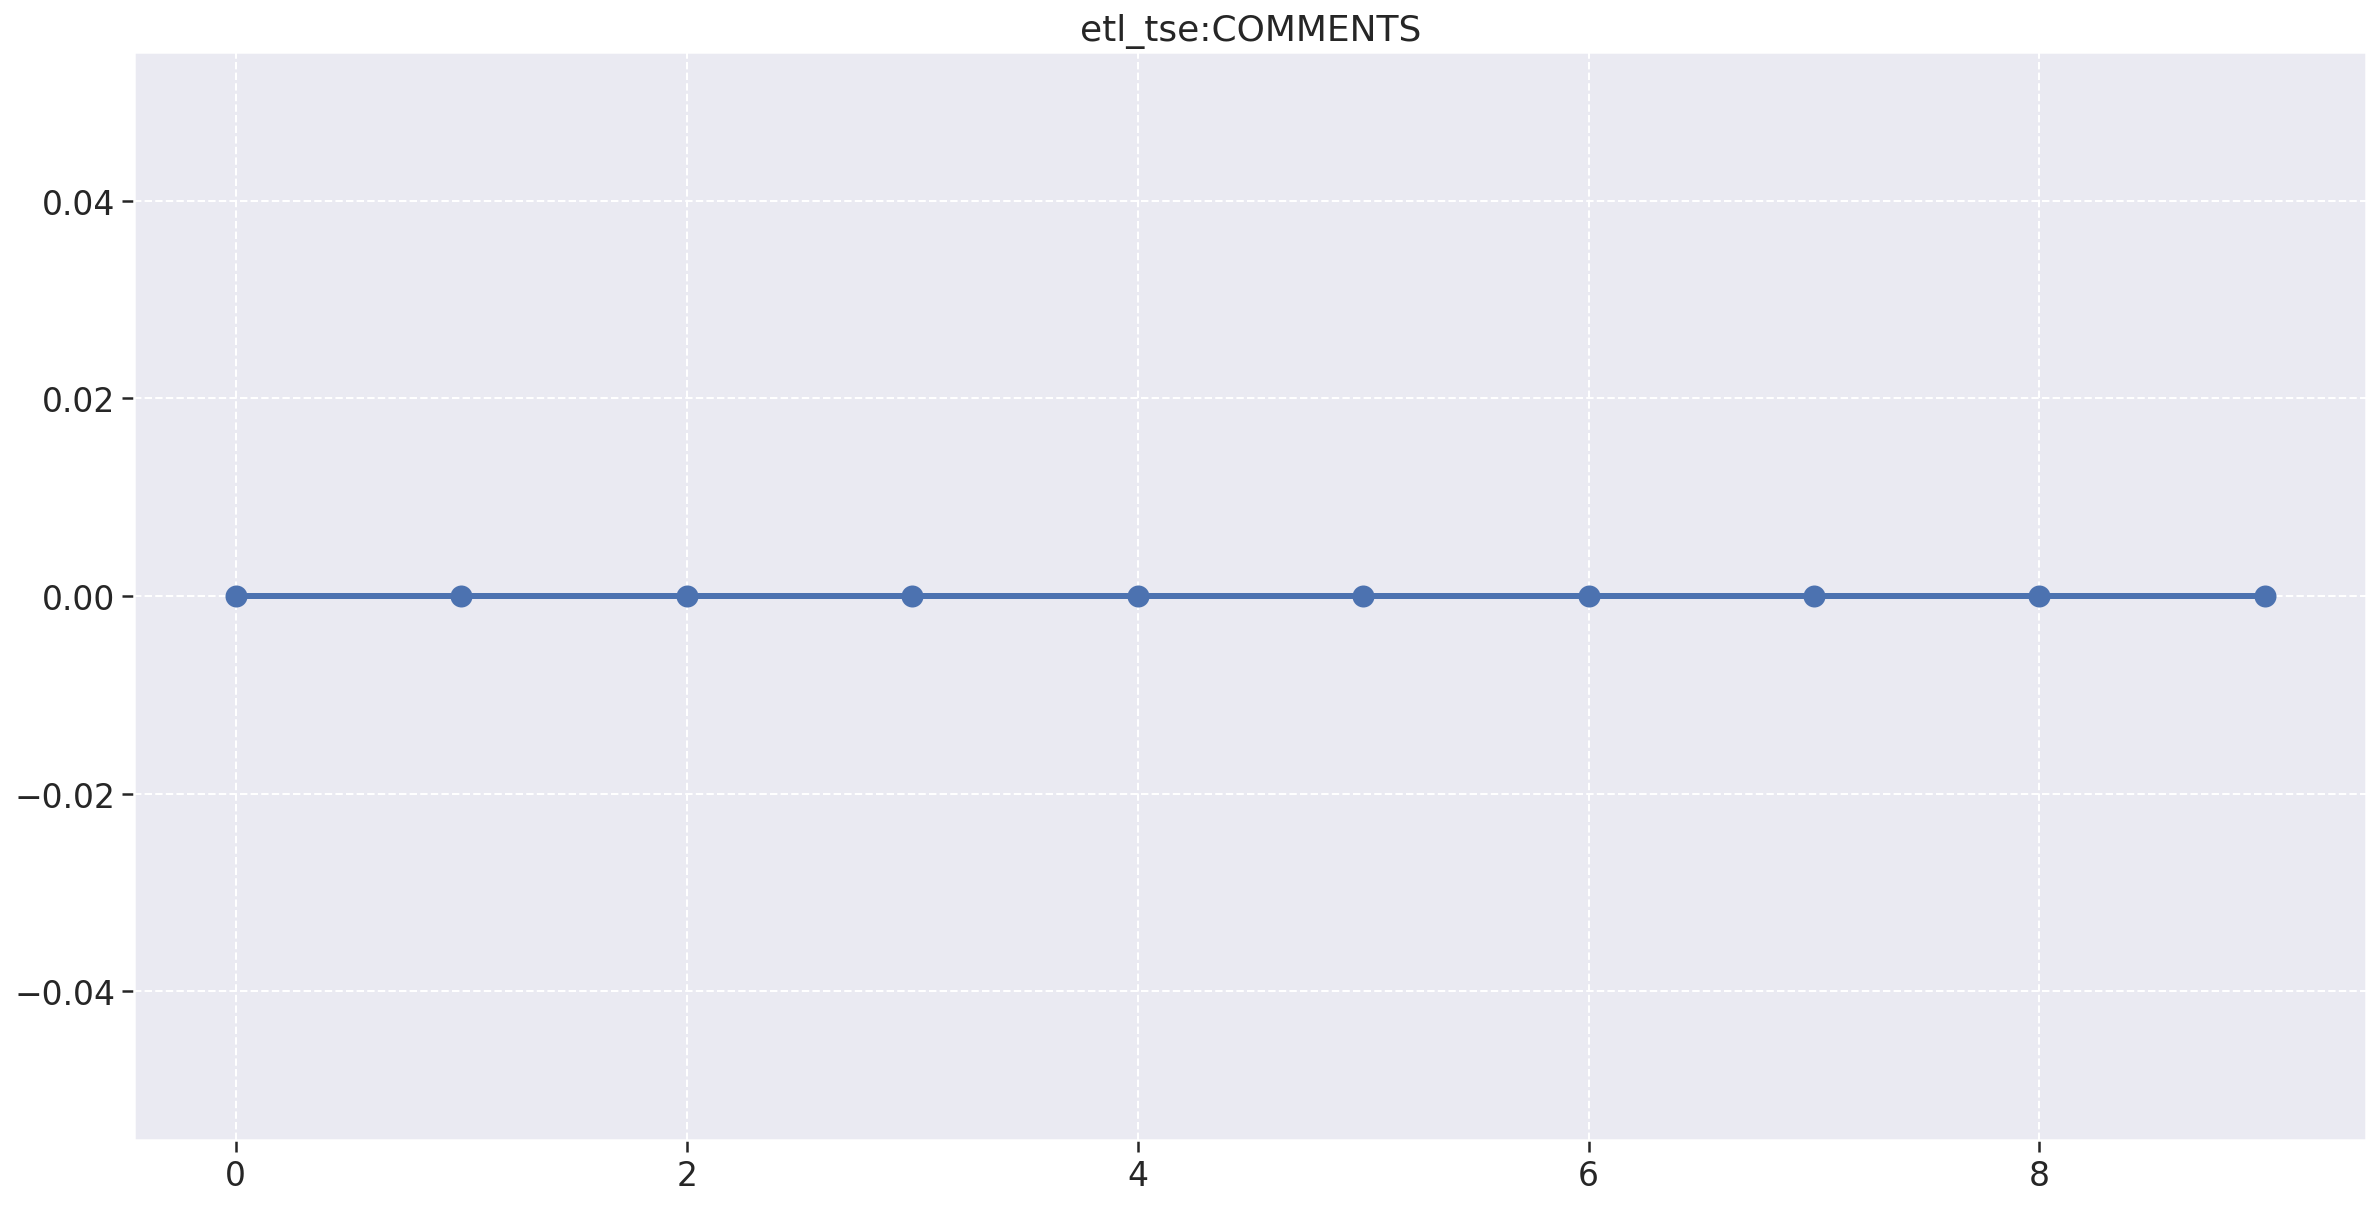

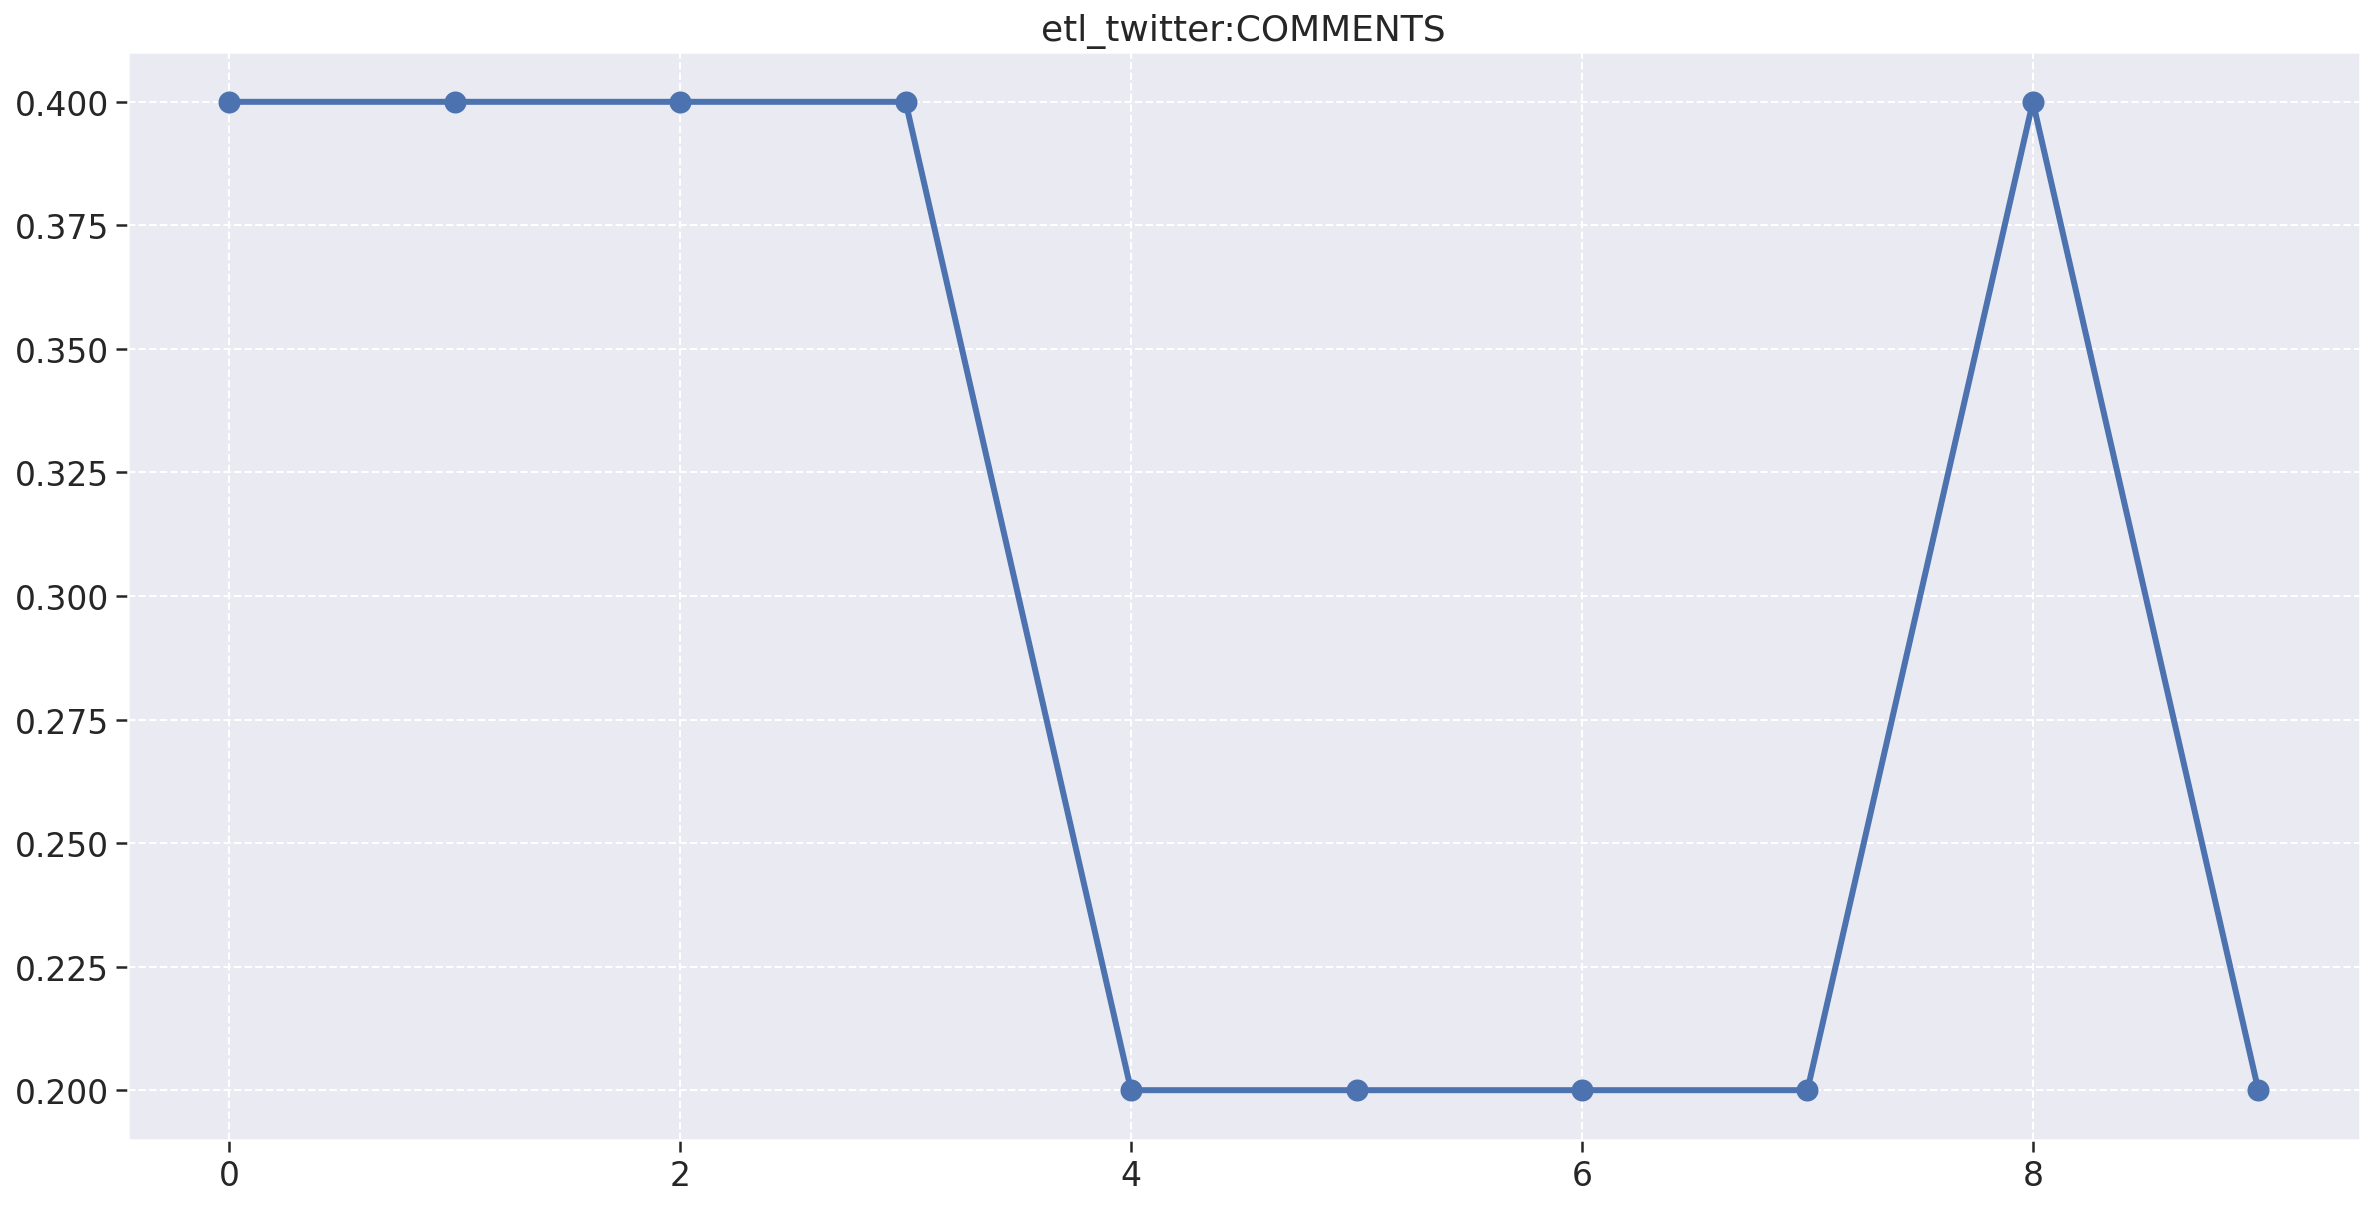

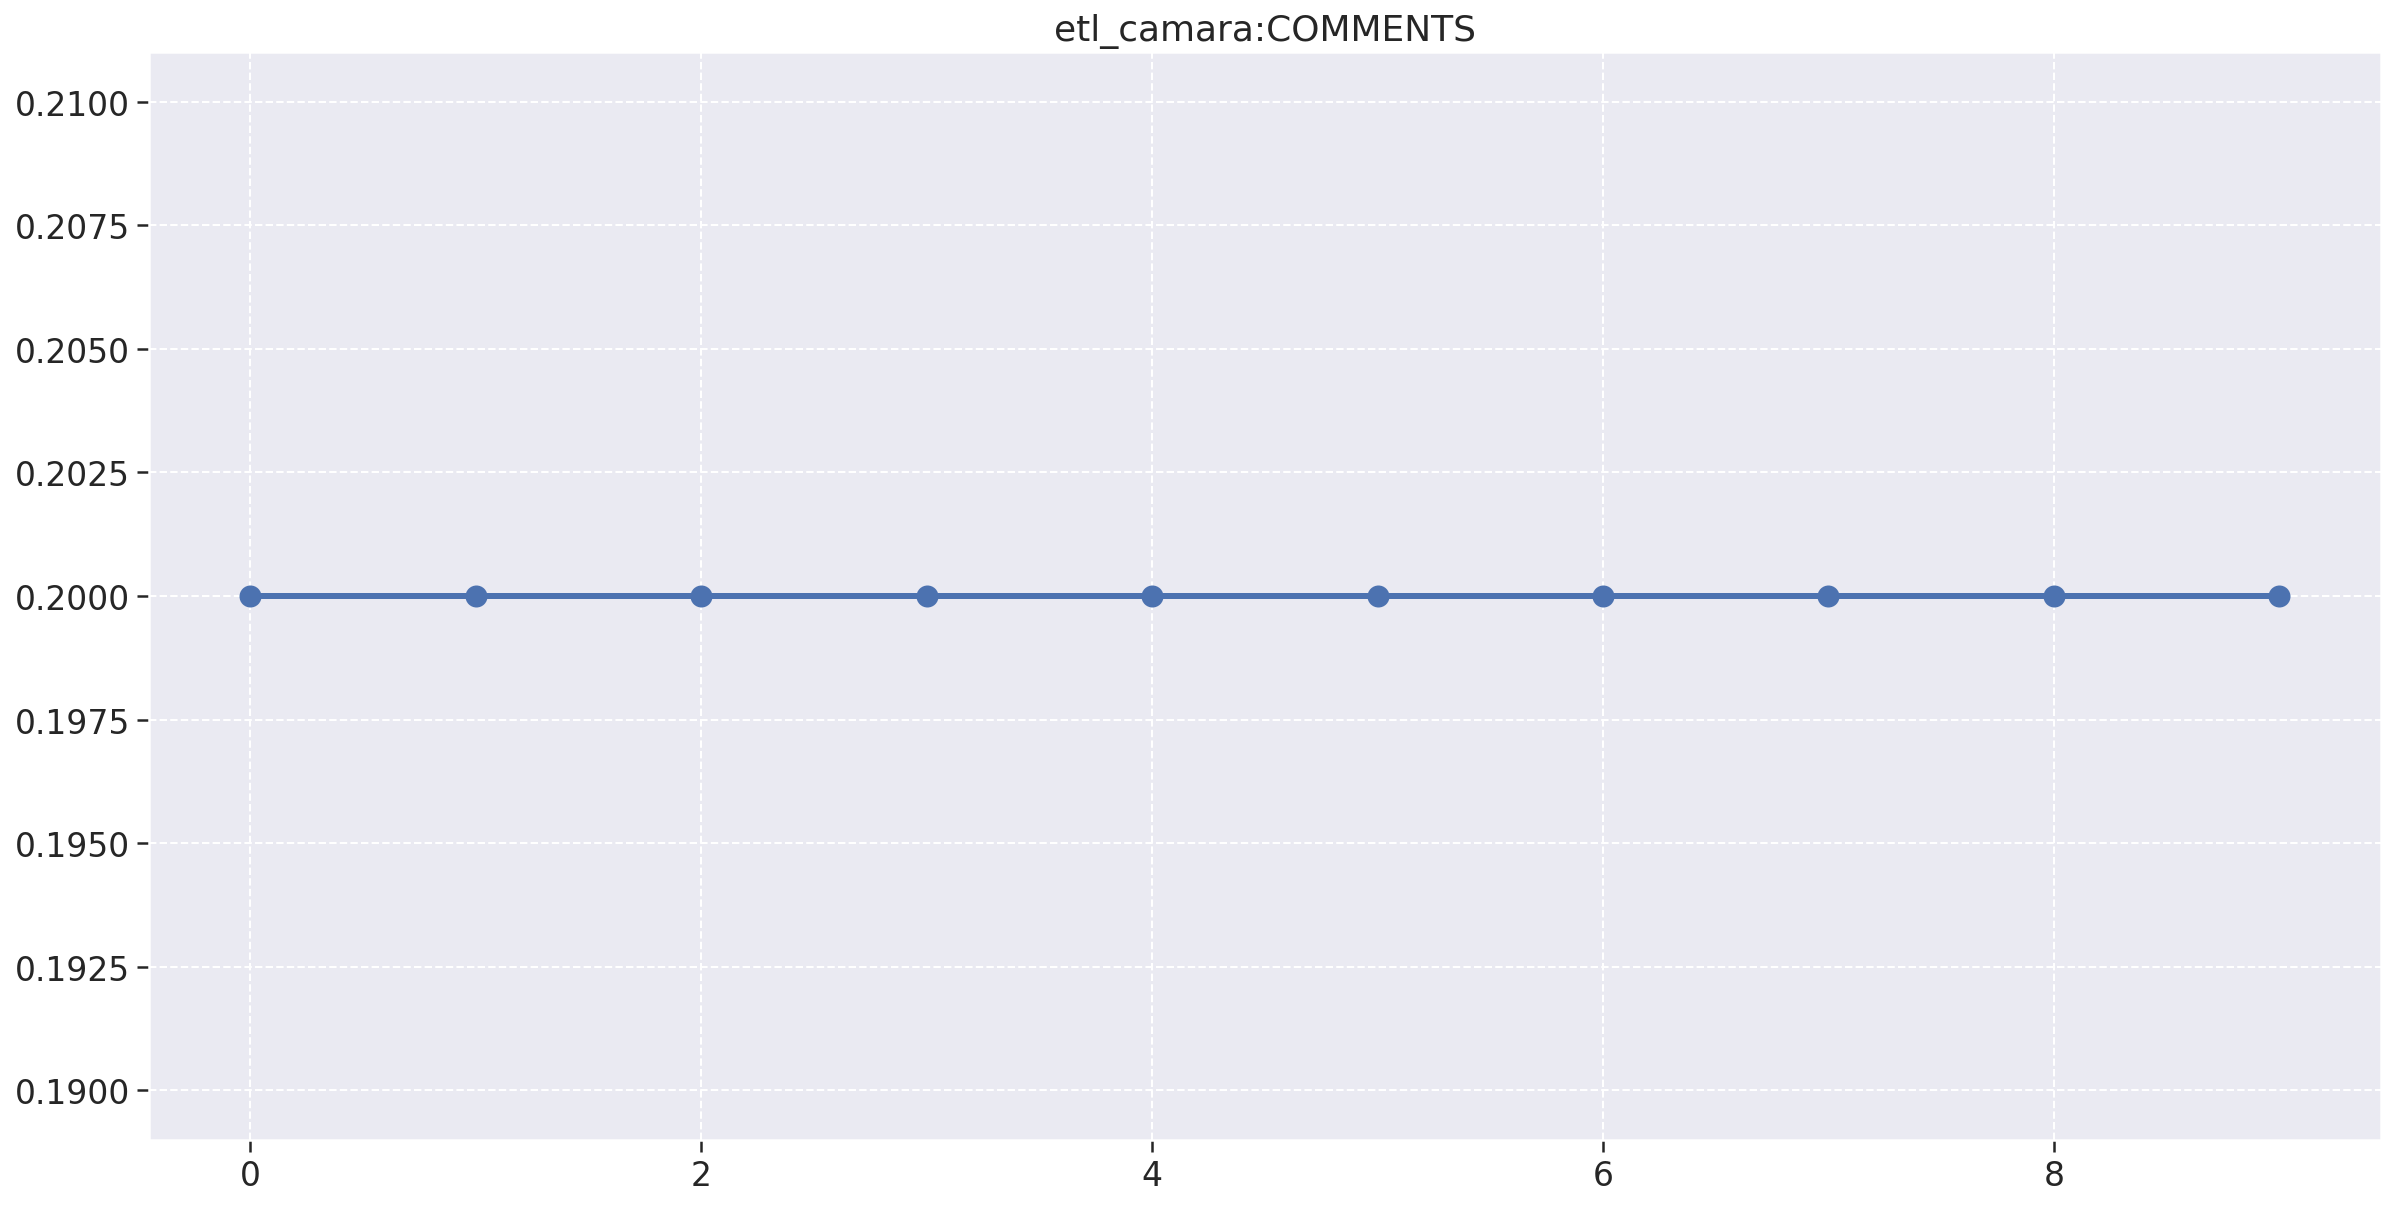

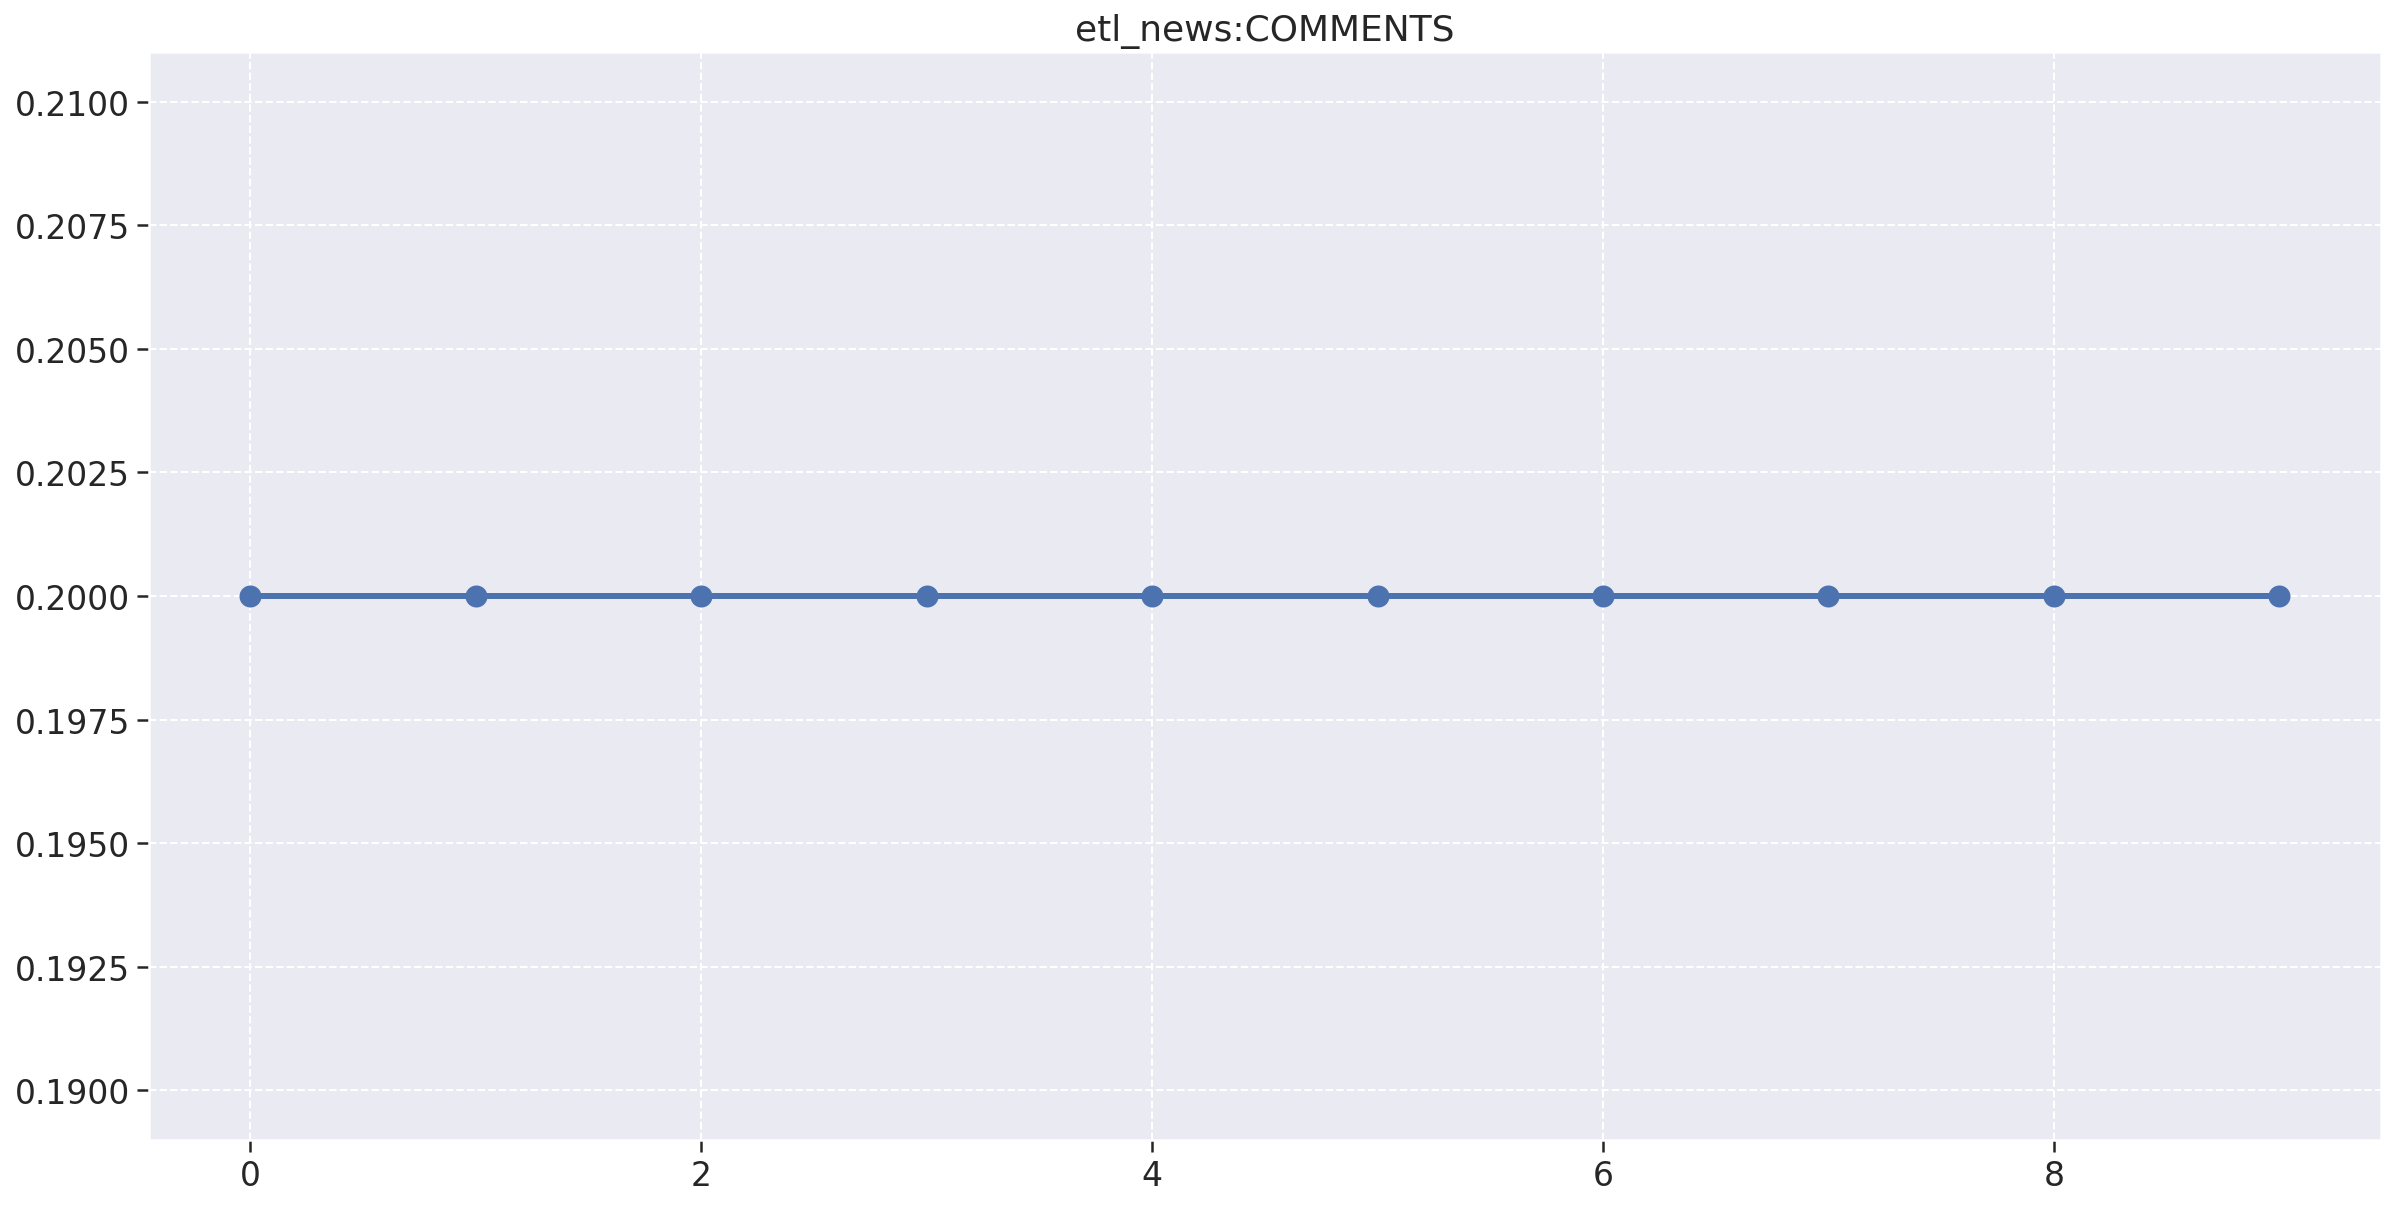

In [475]:
for repository, metrics_df in repository_metrics.items(): 
    fig = plt.figure(figsize=(20, 10))
    plt.title(f"{repository}:COMMENTS")
    plt.plot(metrics_df['m2'], linewidth=3, marker='o', markersize=10)

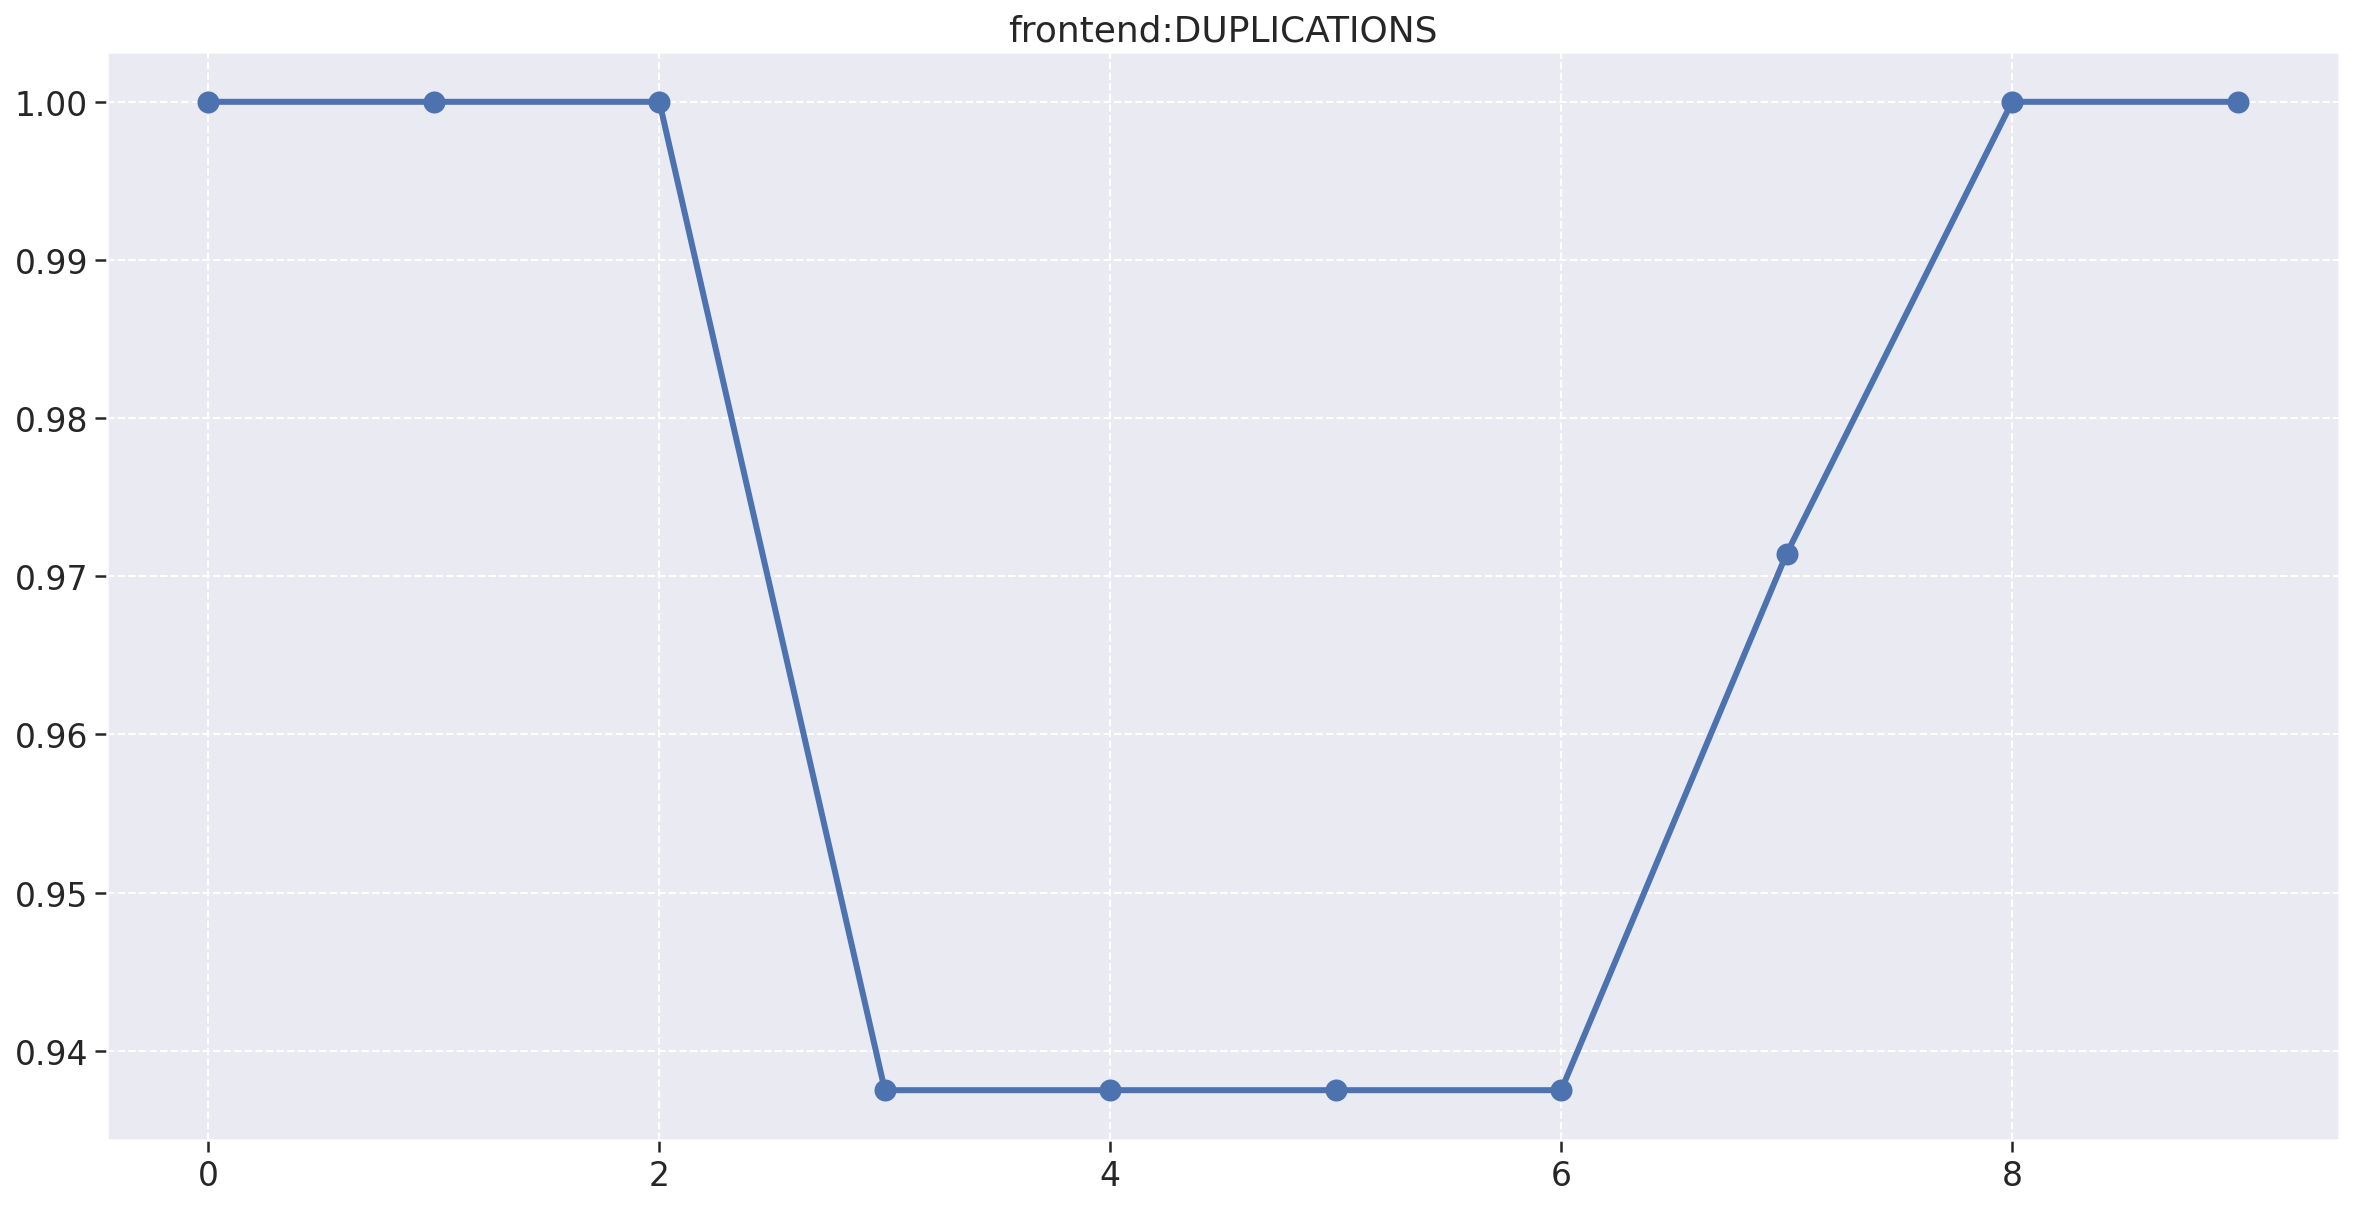

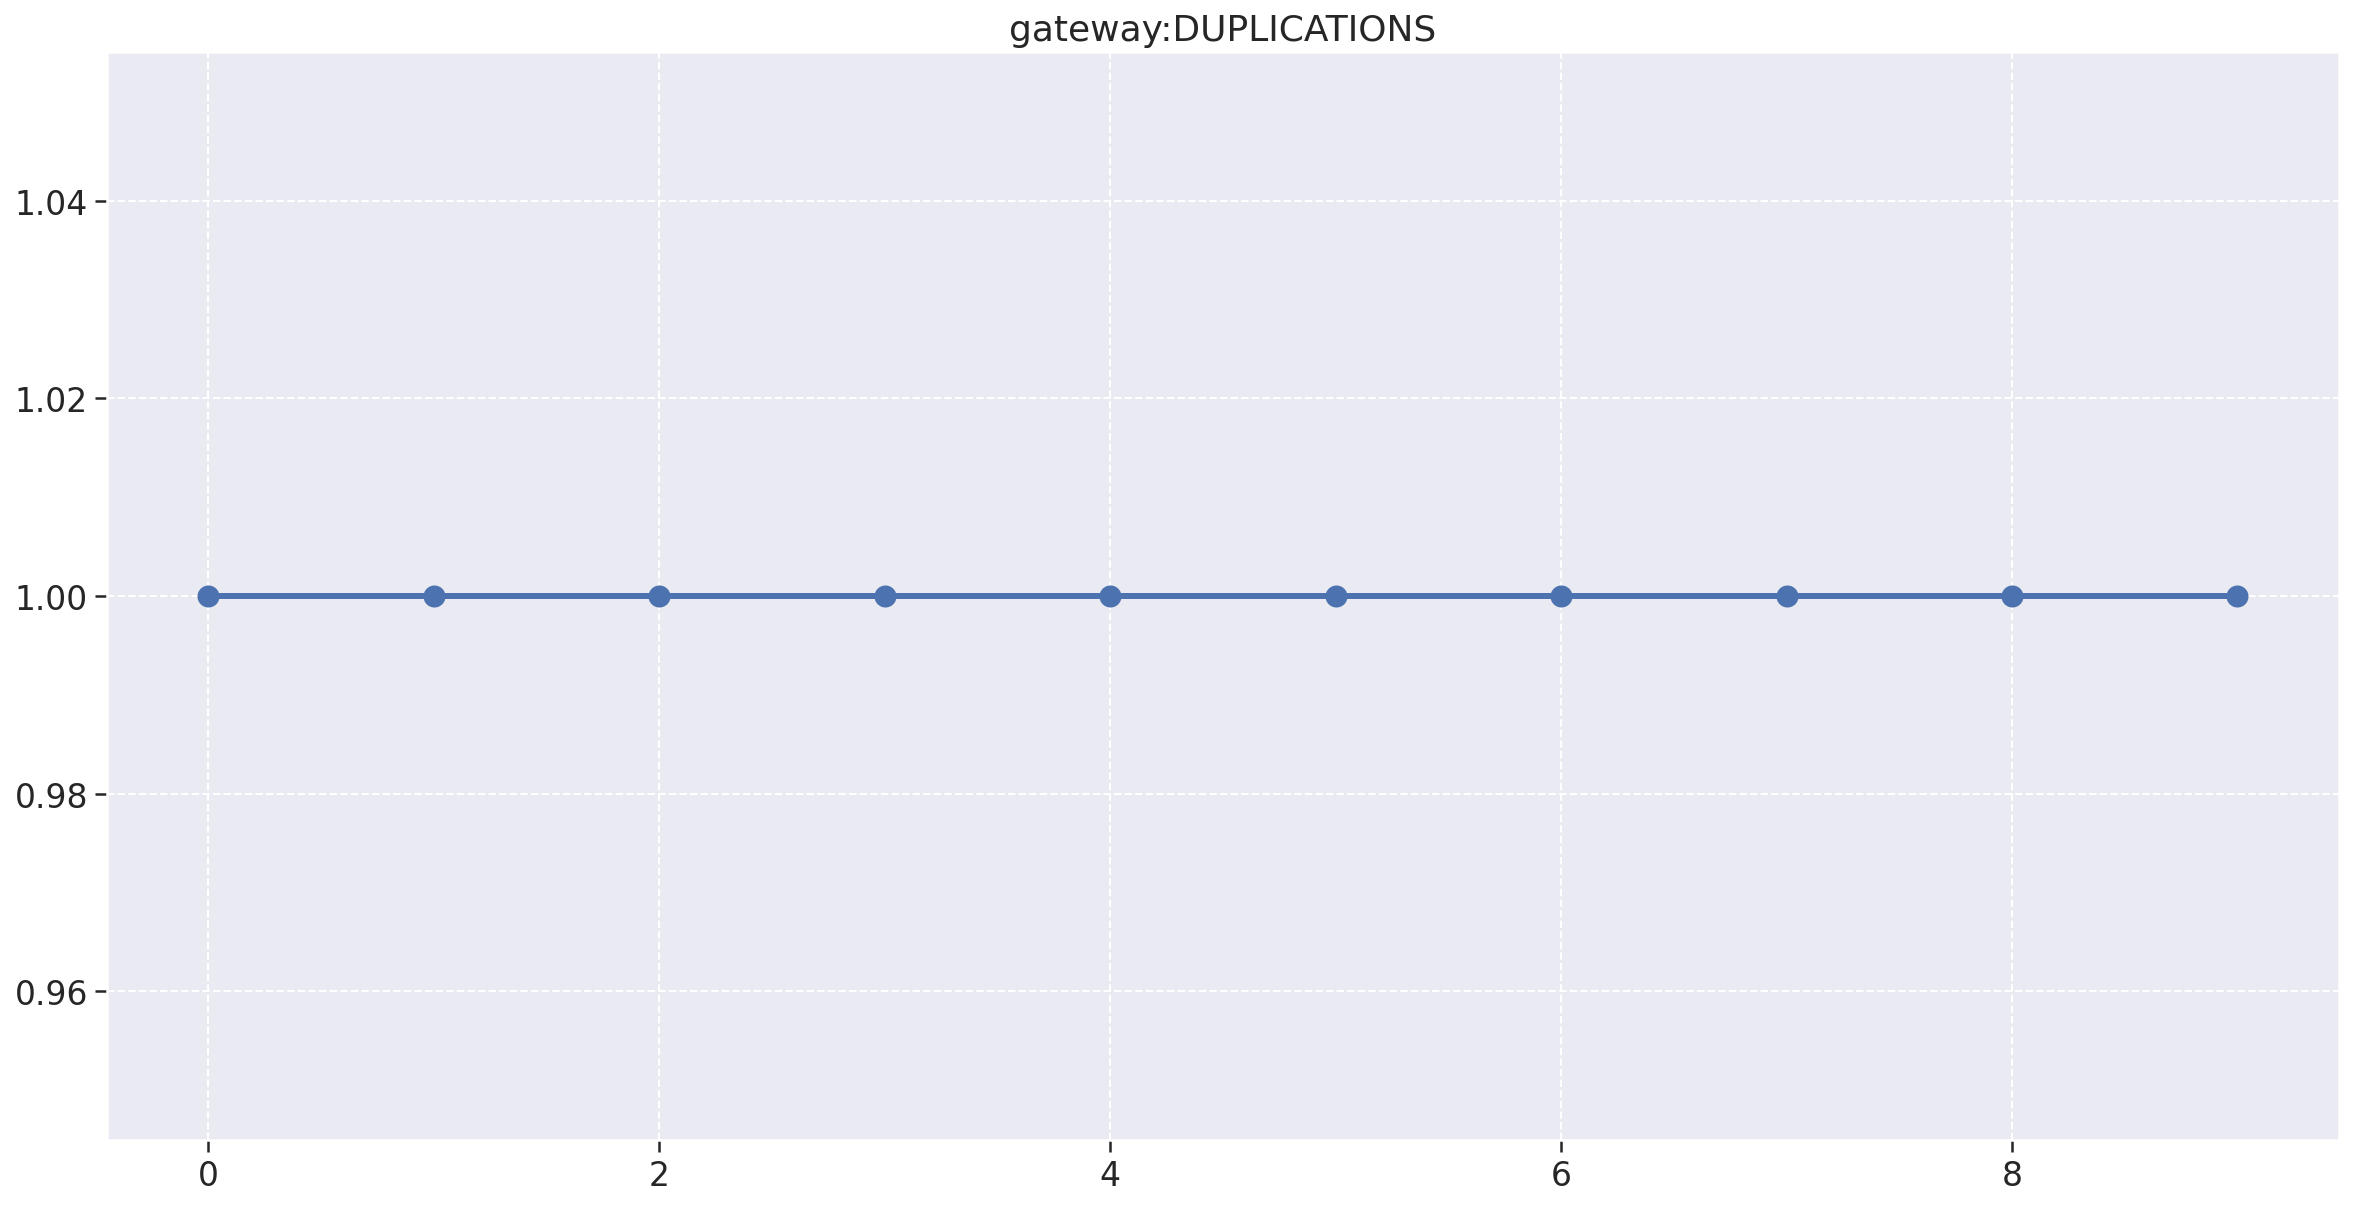

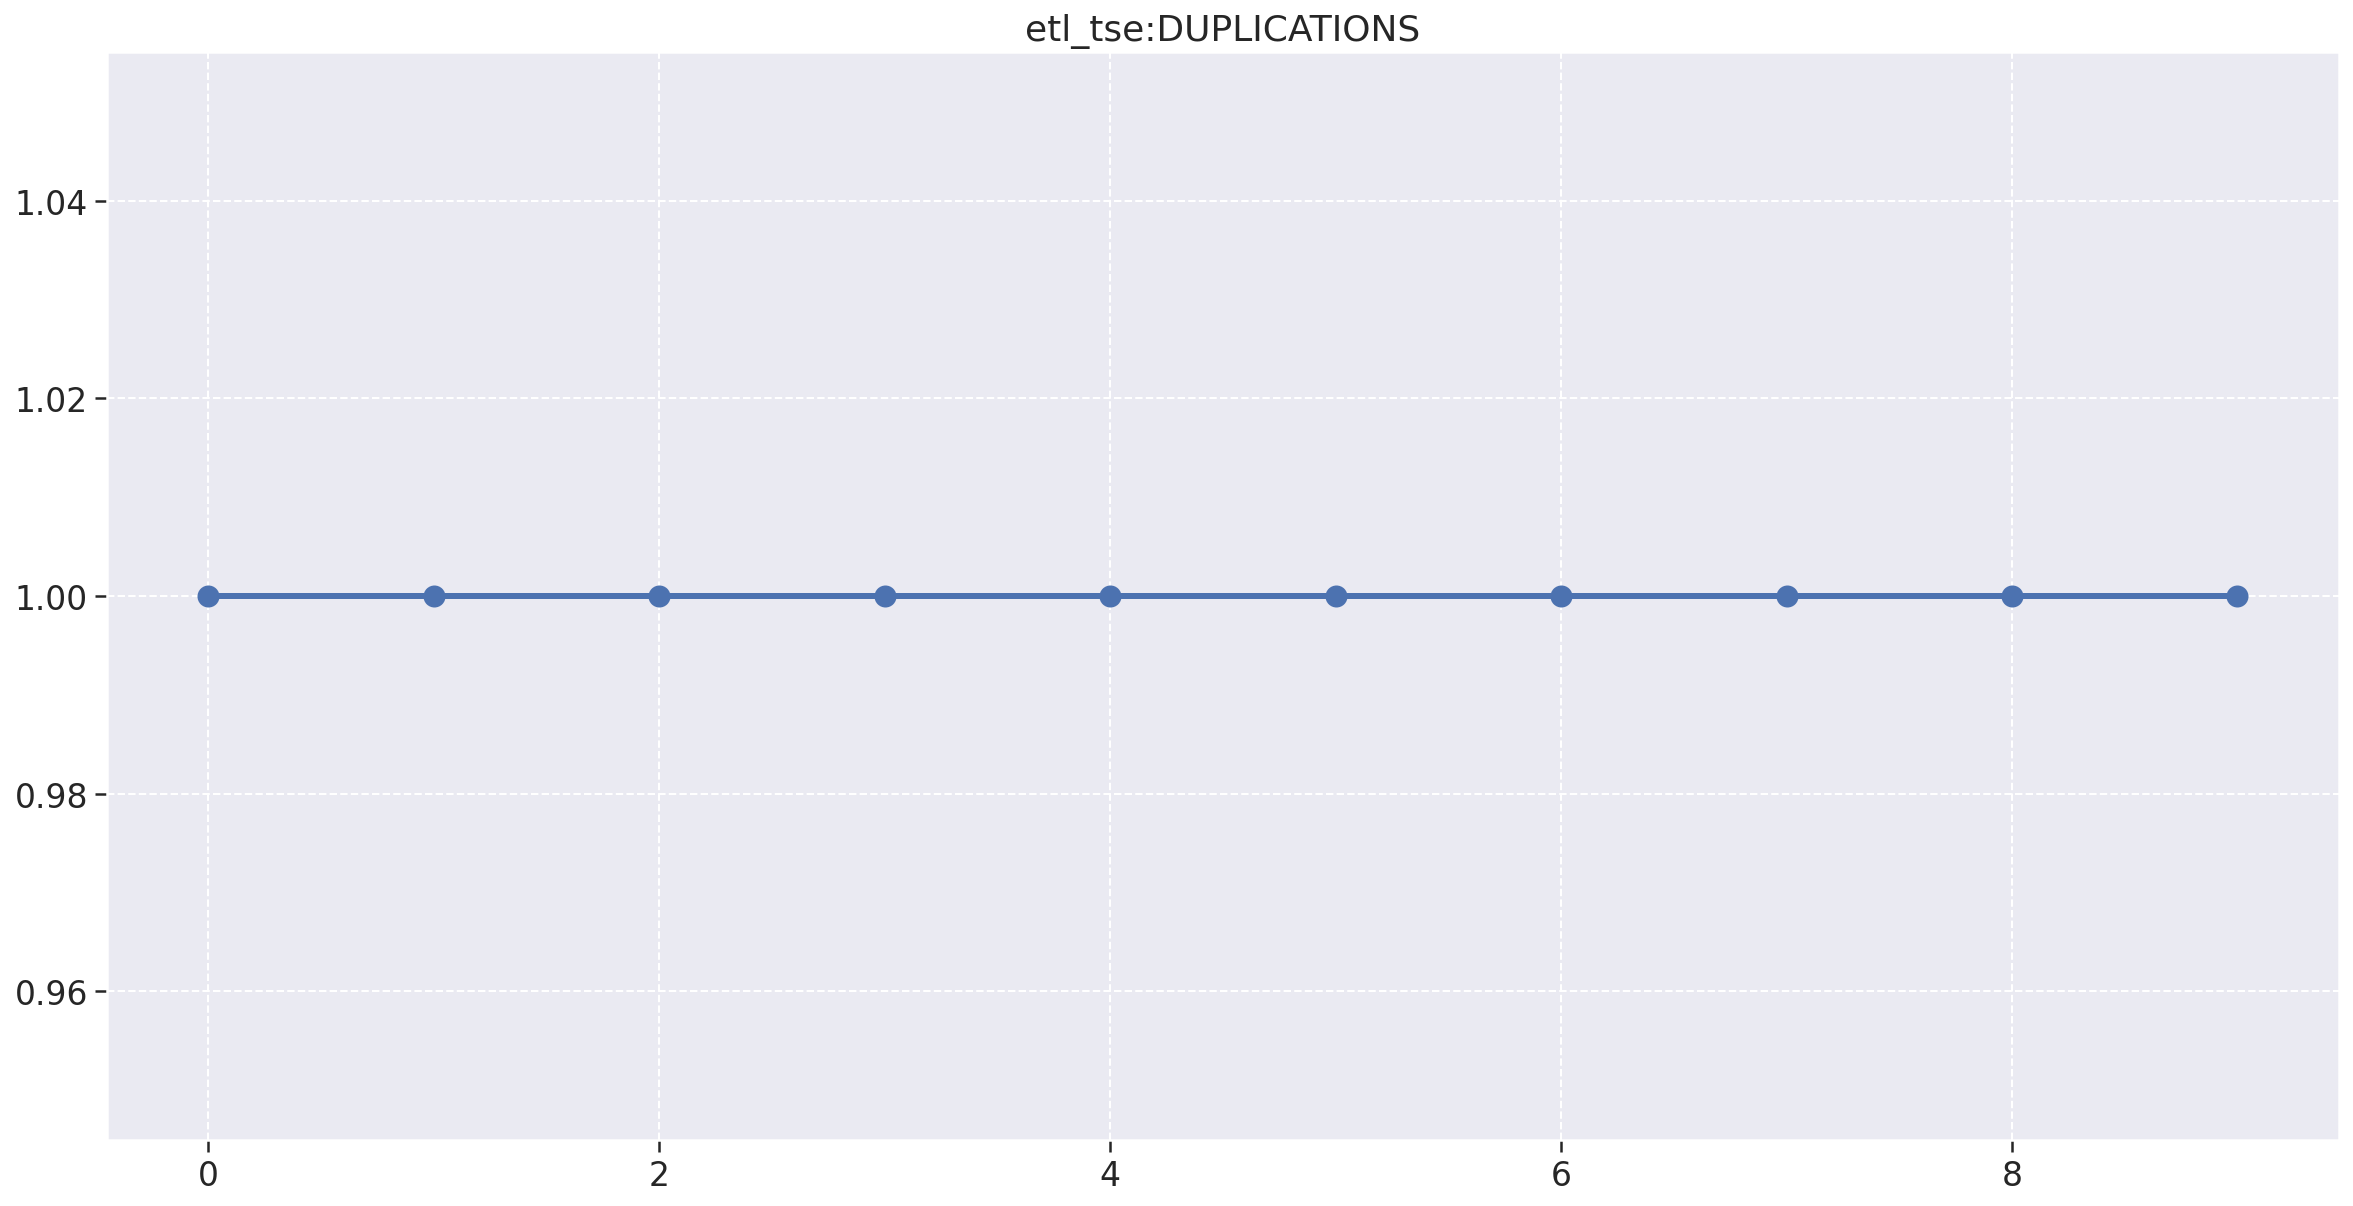

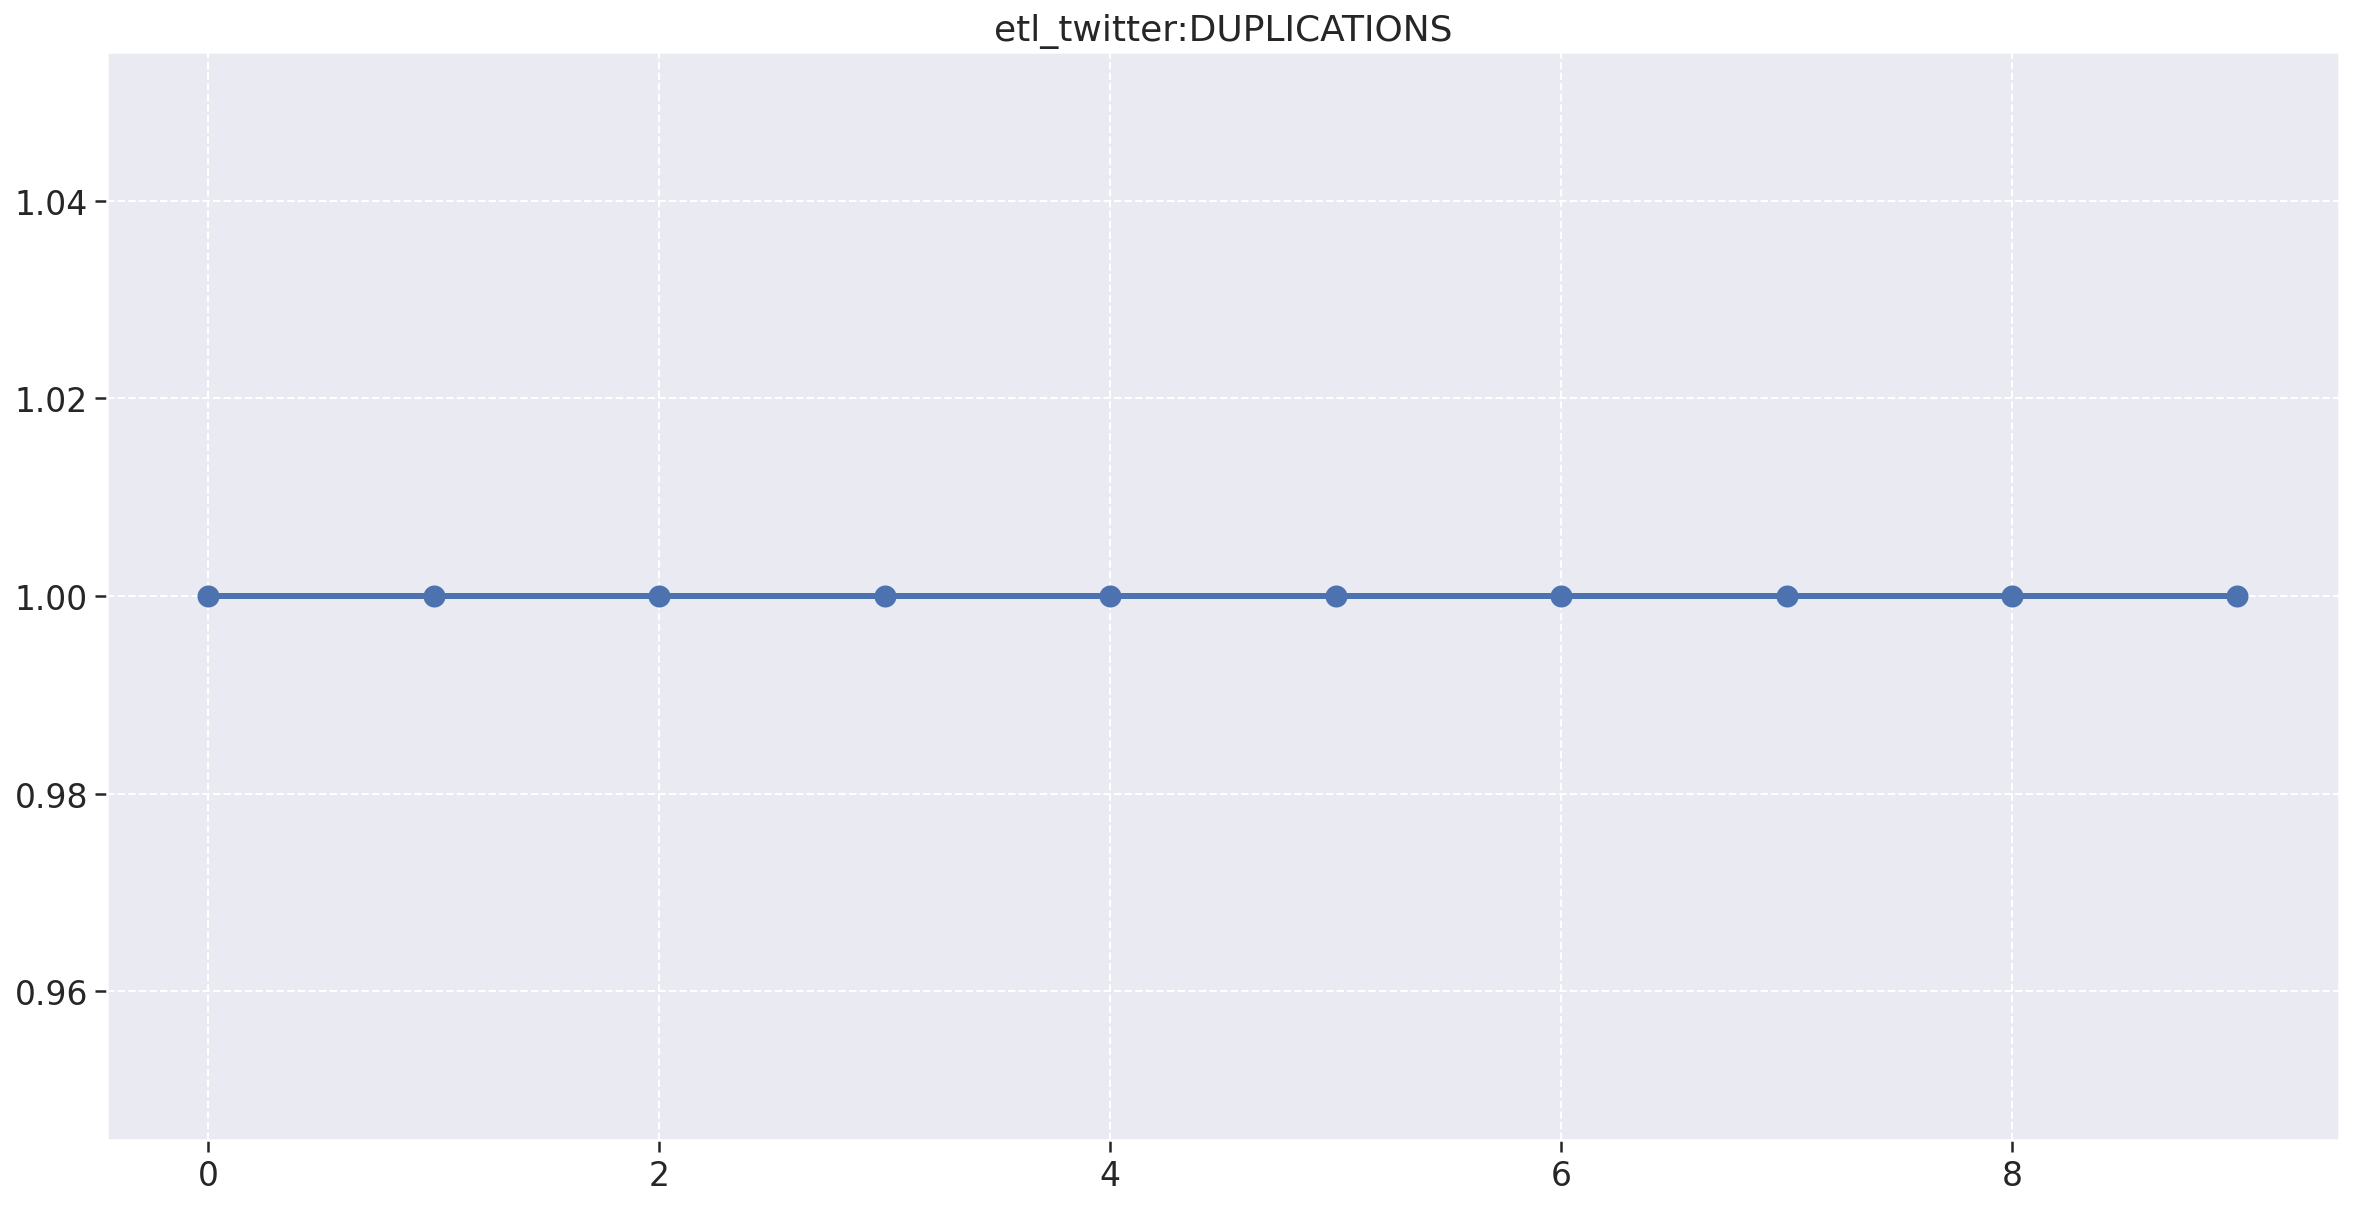

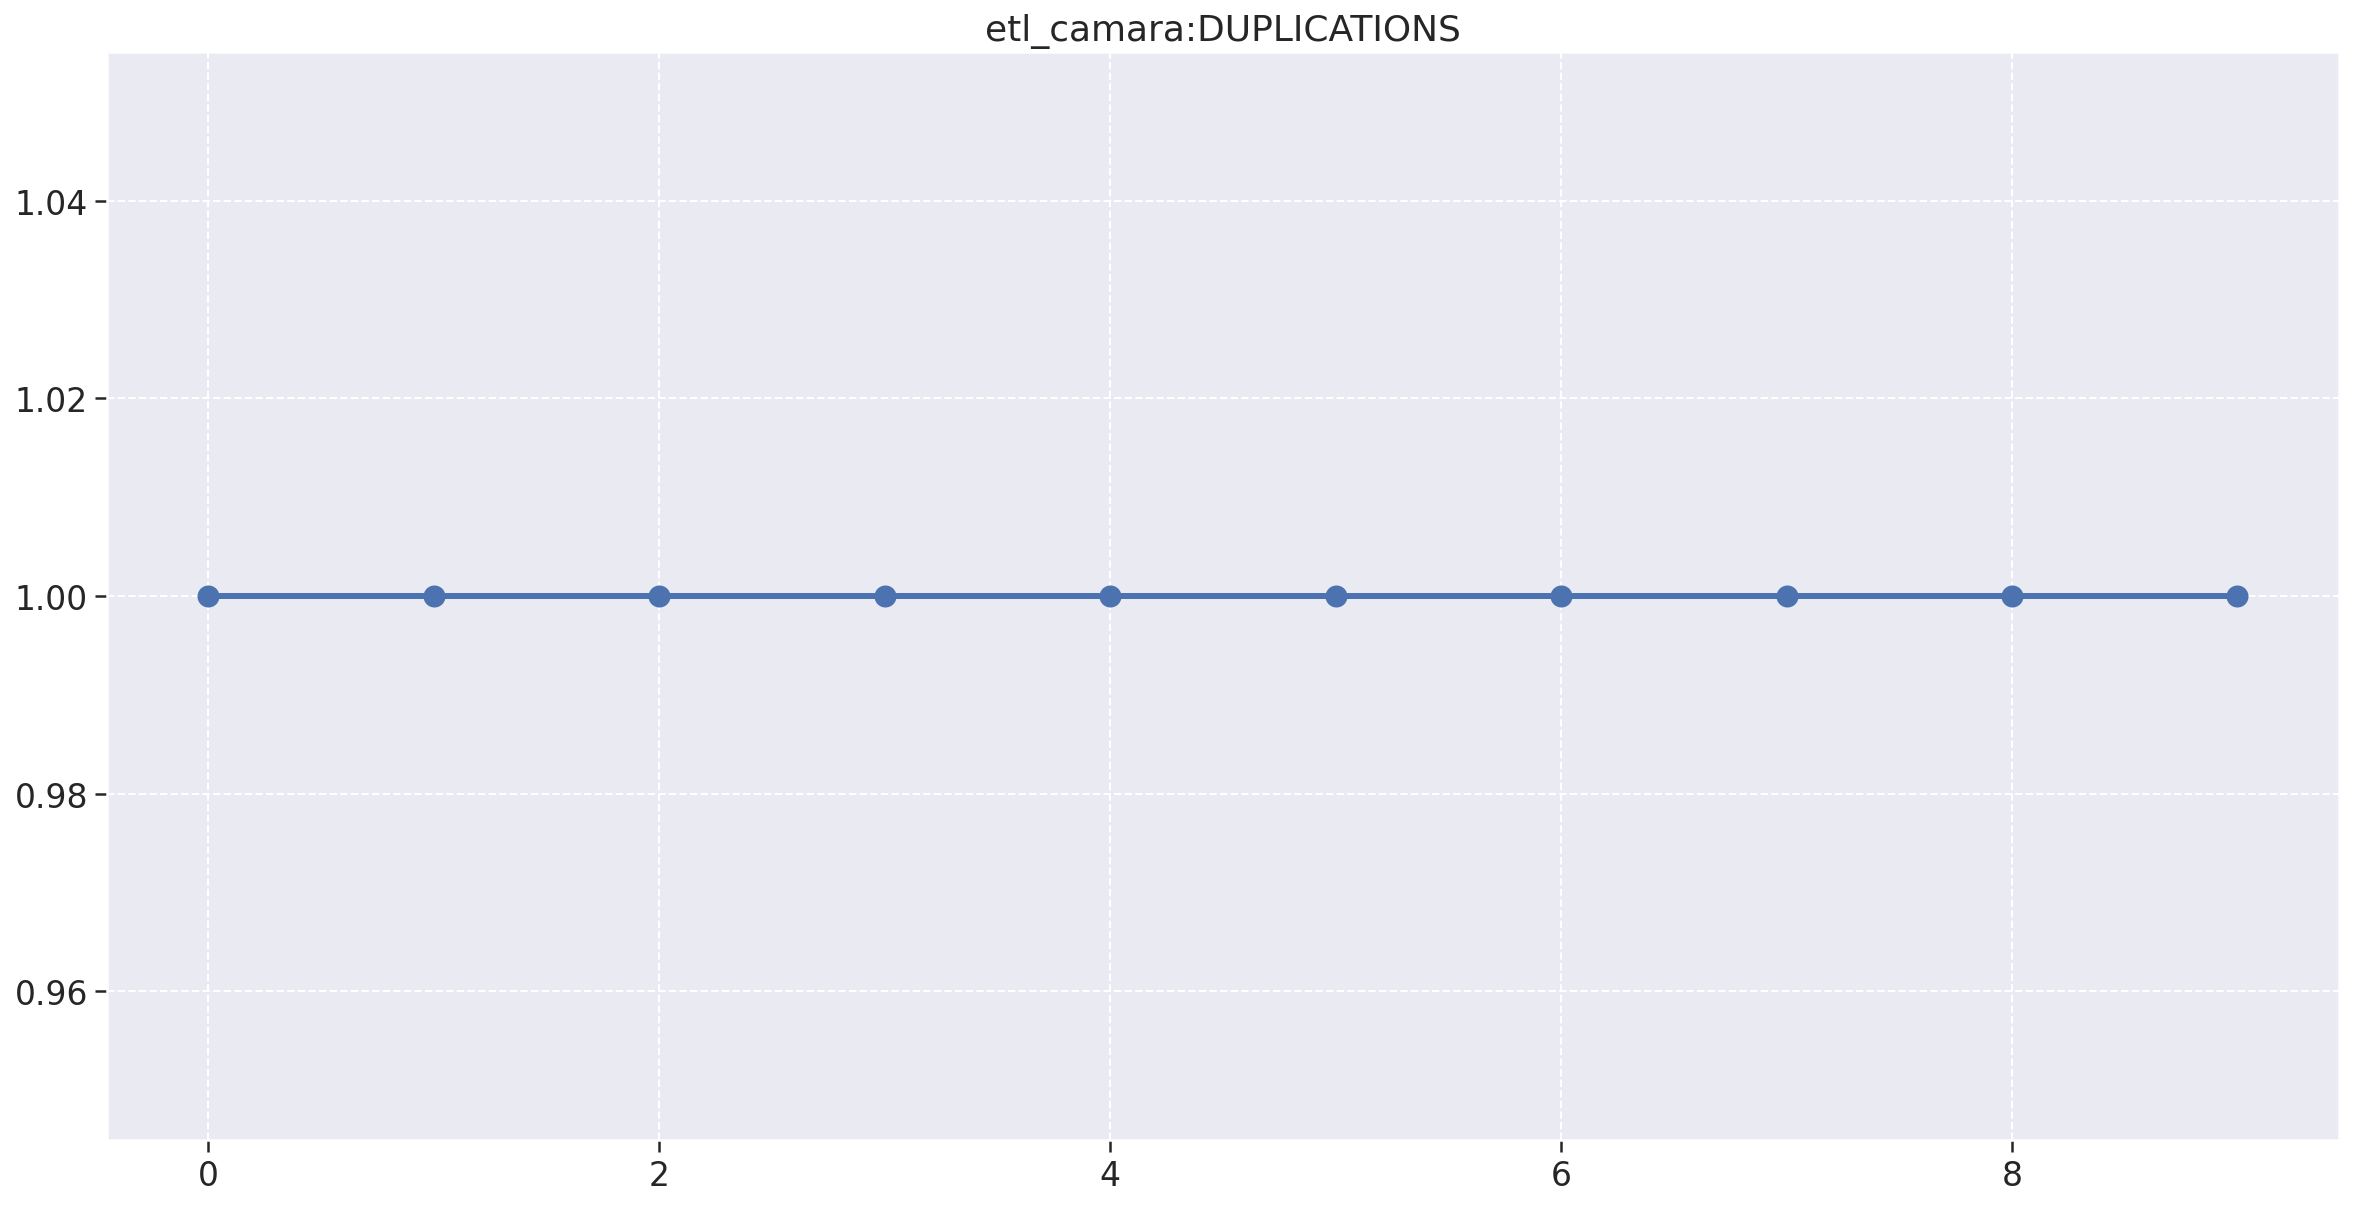

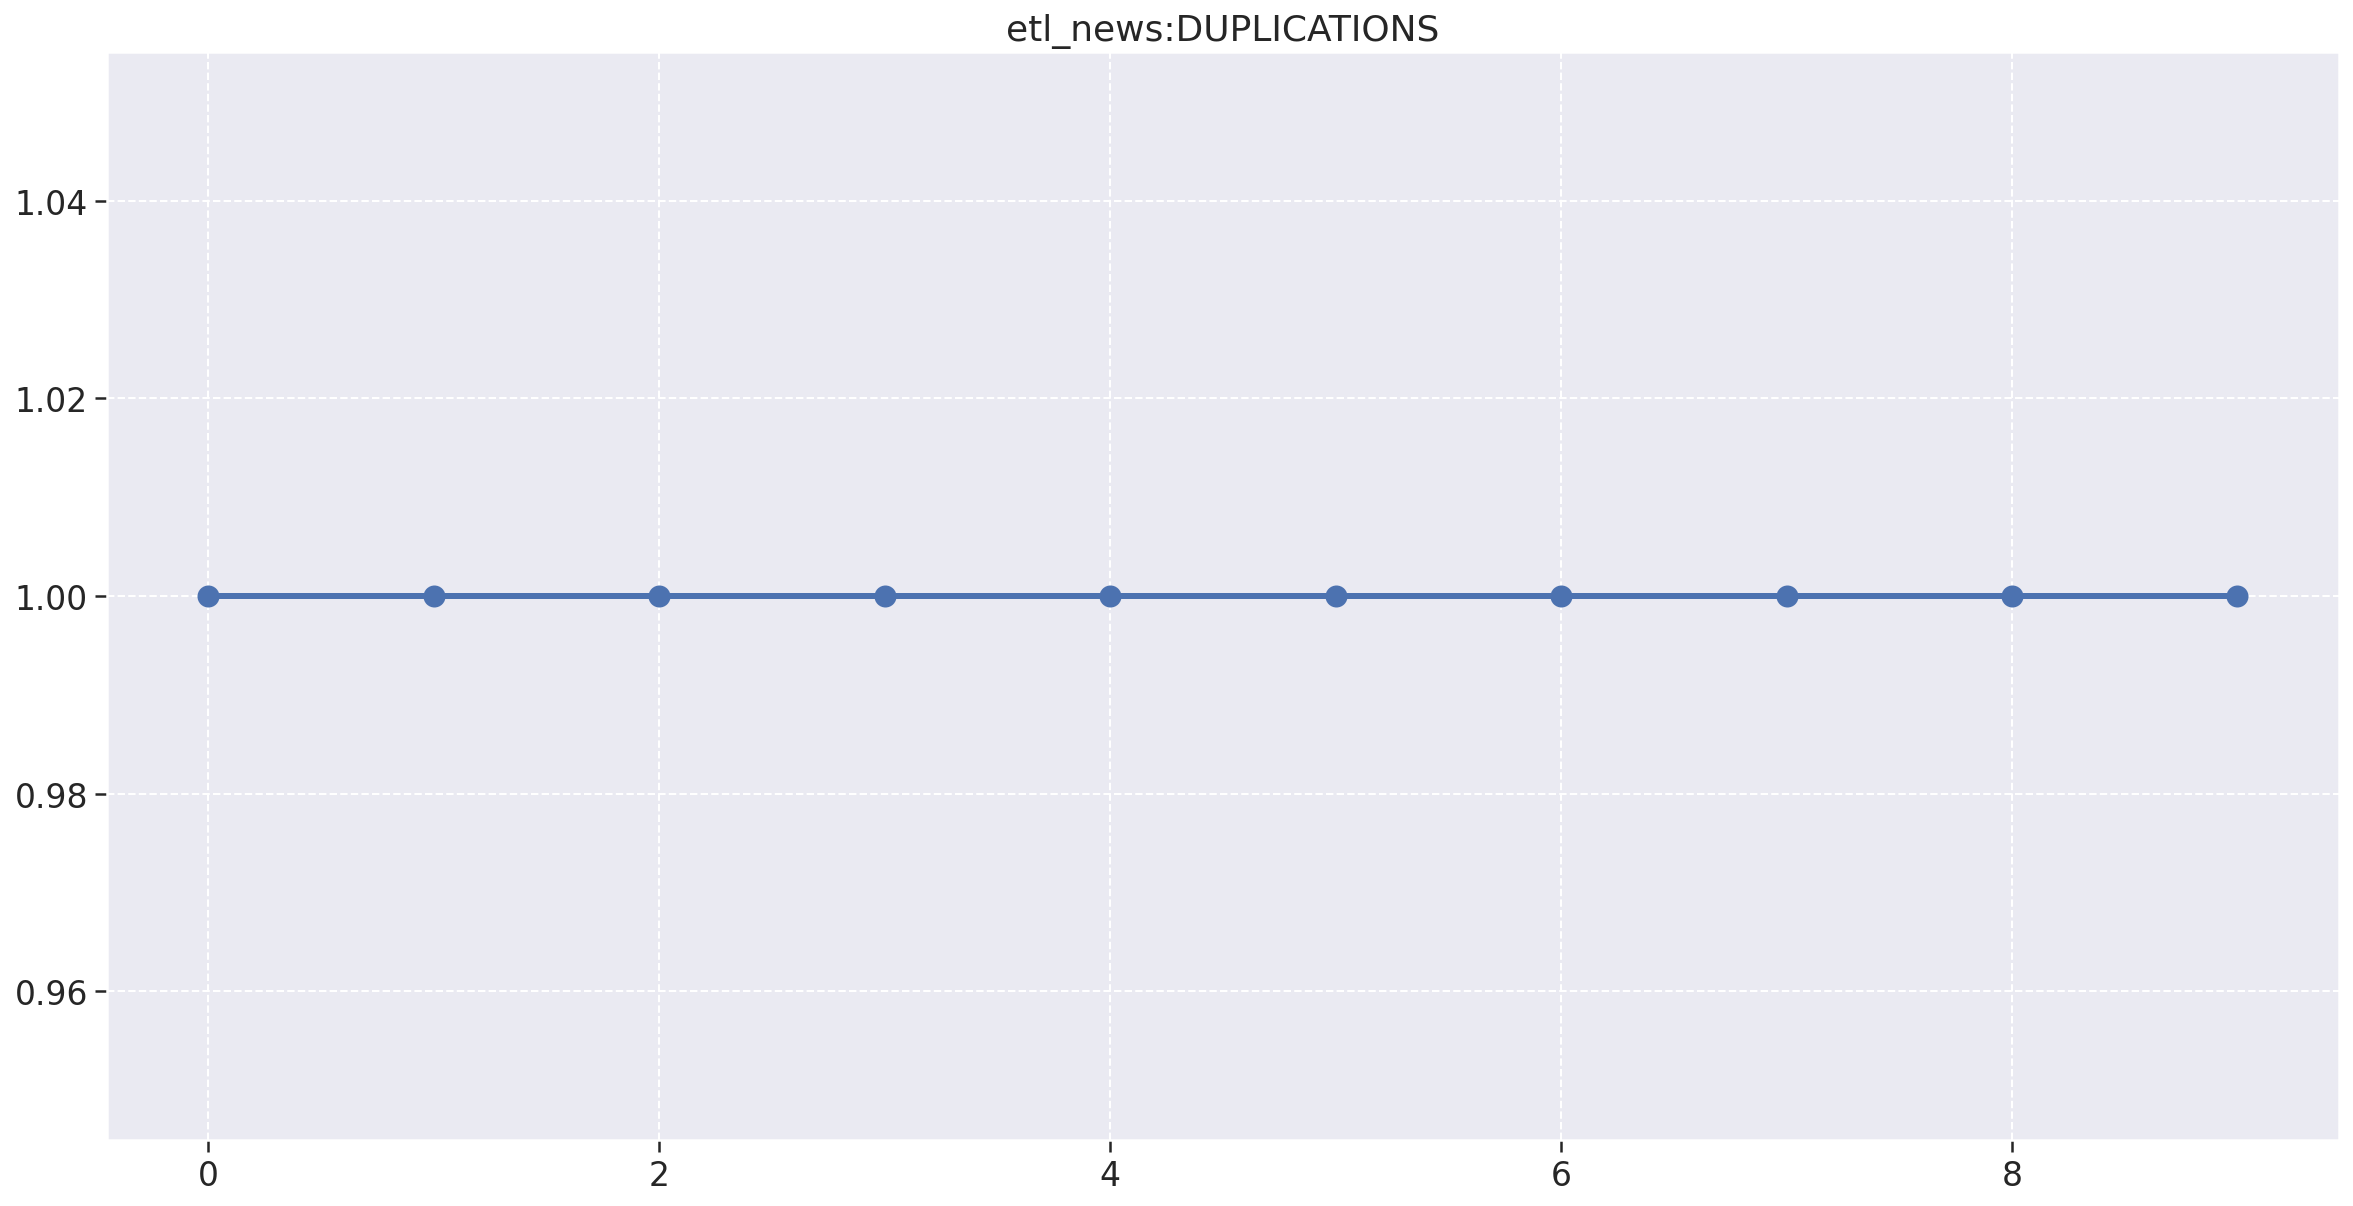

In [476]:
for repository, metrics_df in repository_metrics.items(): 
    fig = plt.figure(figsize=(20, 10))
    plt.title(f"{repository}:DUPLICATIONS")
    plt.plot(metrics_df['m3'], linewidth=3, marker='o', markersize=10)

### Sub characteristic aggregation


In [477]:
psc1 = 1
pm1 = 0.33
pm2 = 0.33
pm3 = 0.33

for repository, metrics_df in repository_metrics.items(): 
    metrics_df['asc1'] = ((metrics_df['m1']*pm1)+(metrics_df['m2']*pm2)+(metrics_df['m3']*pm3))*psc1


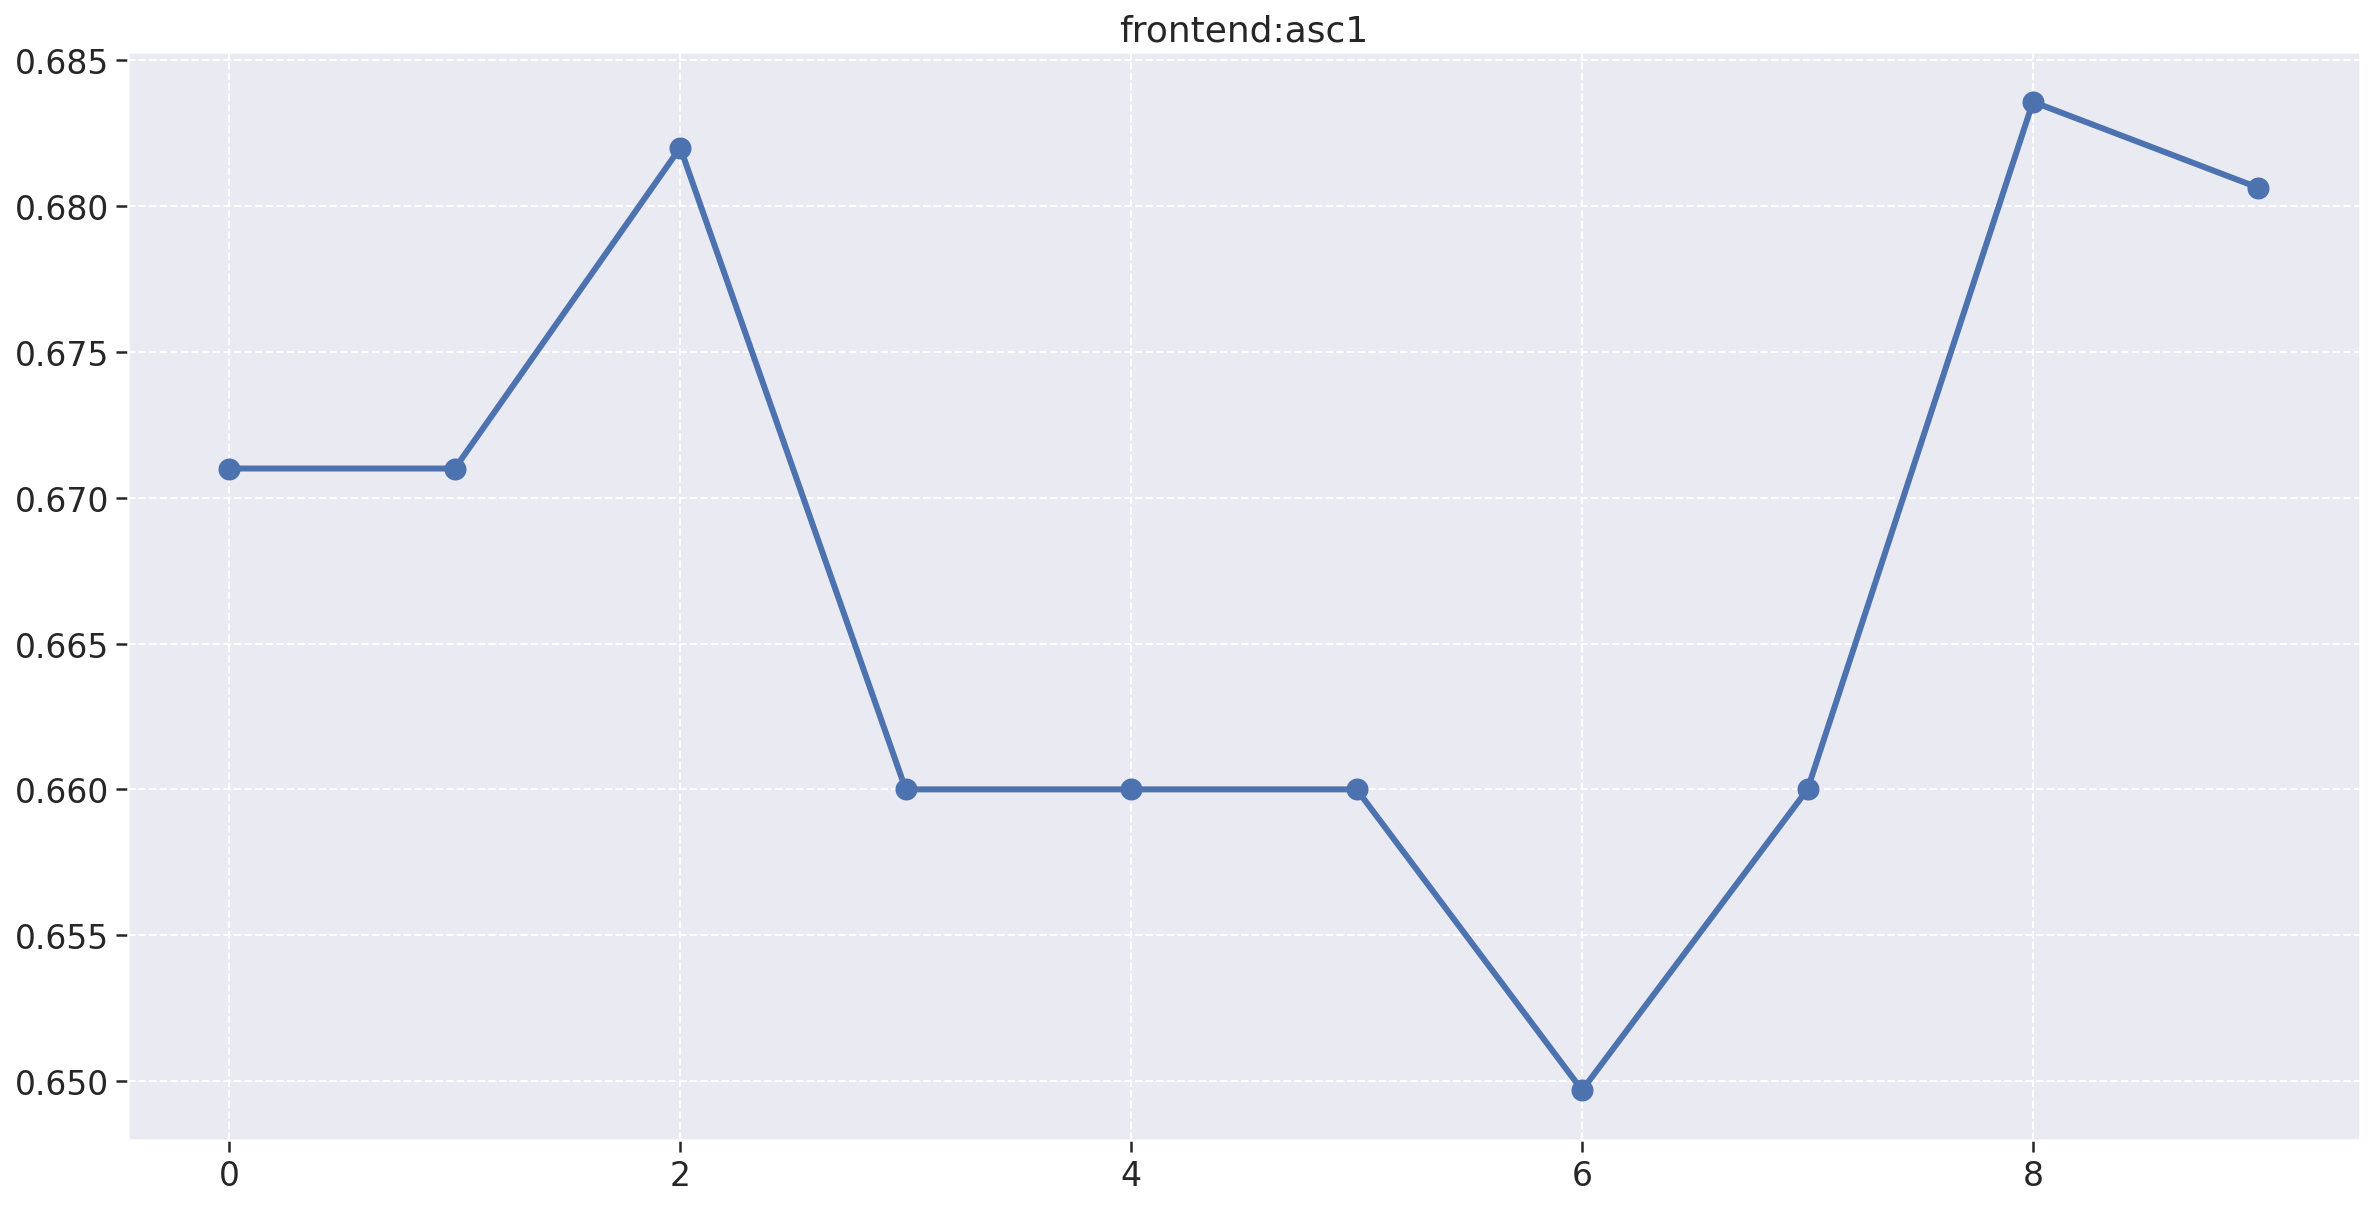

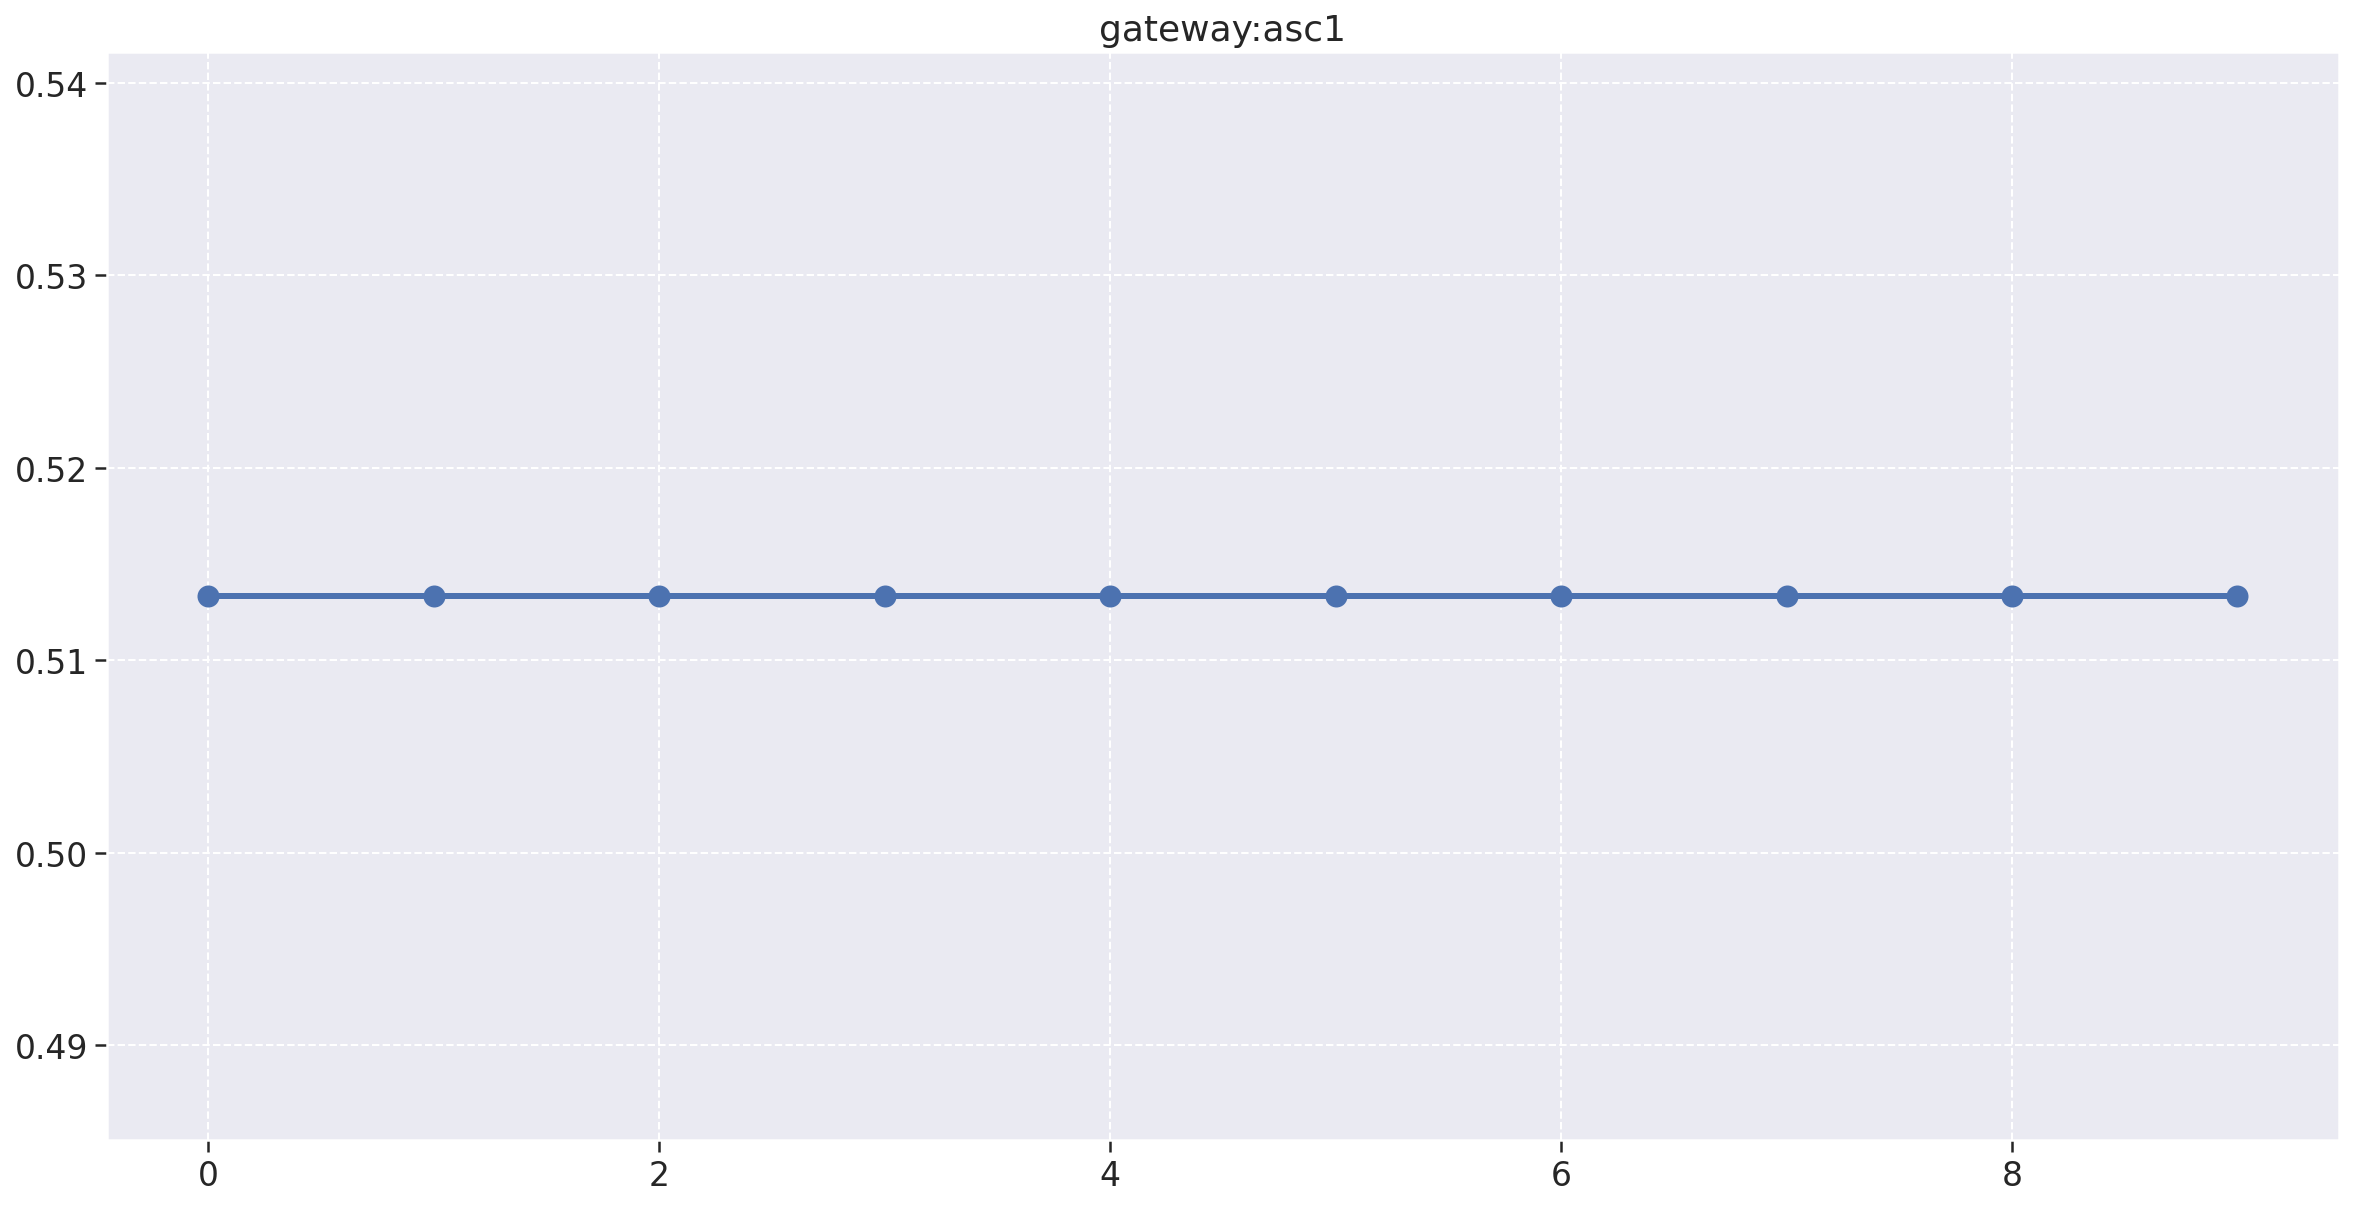

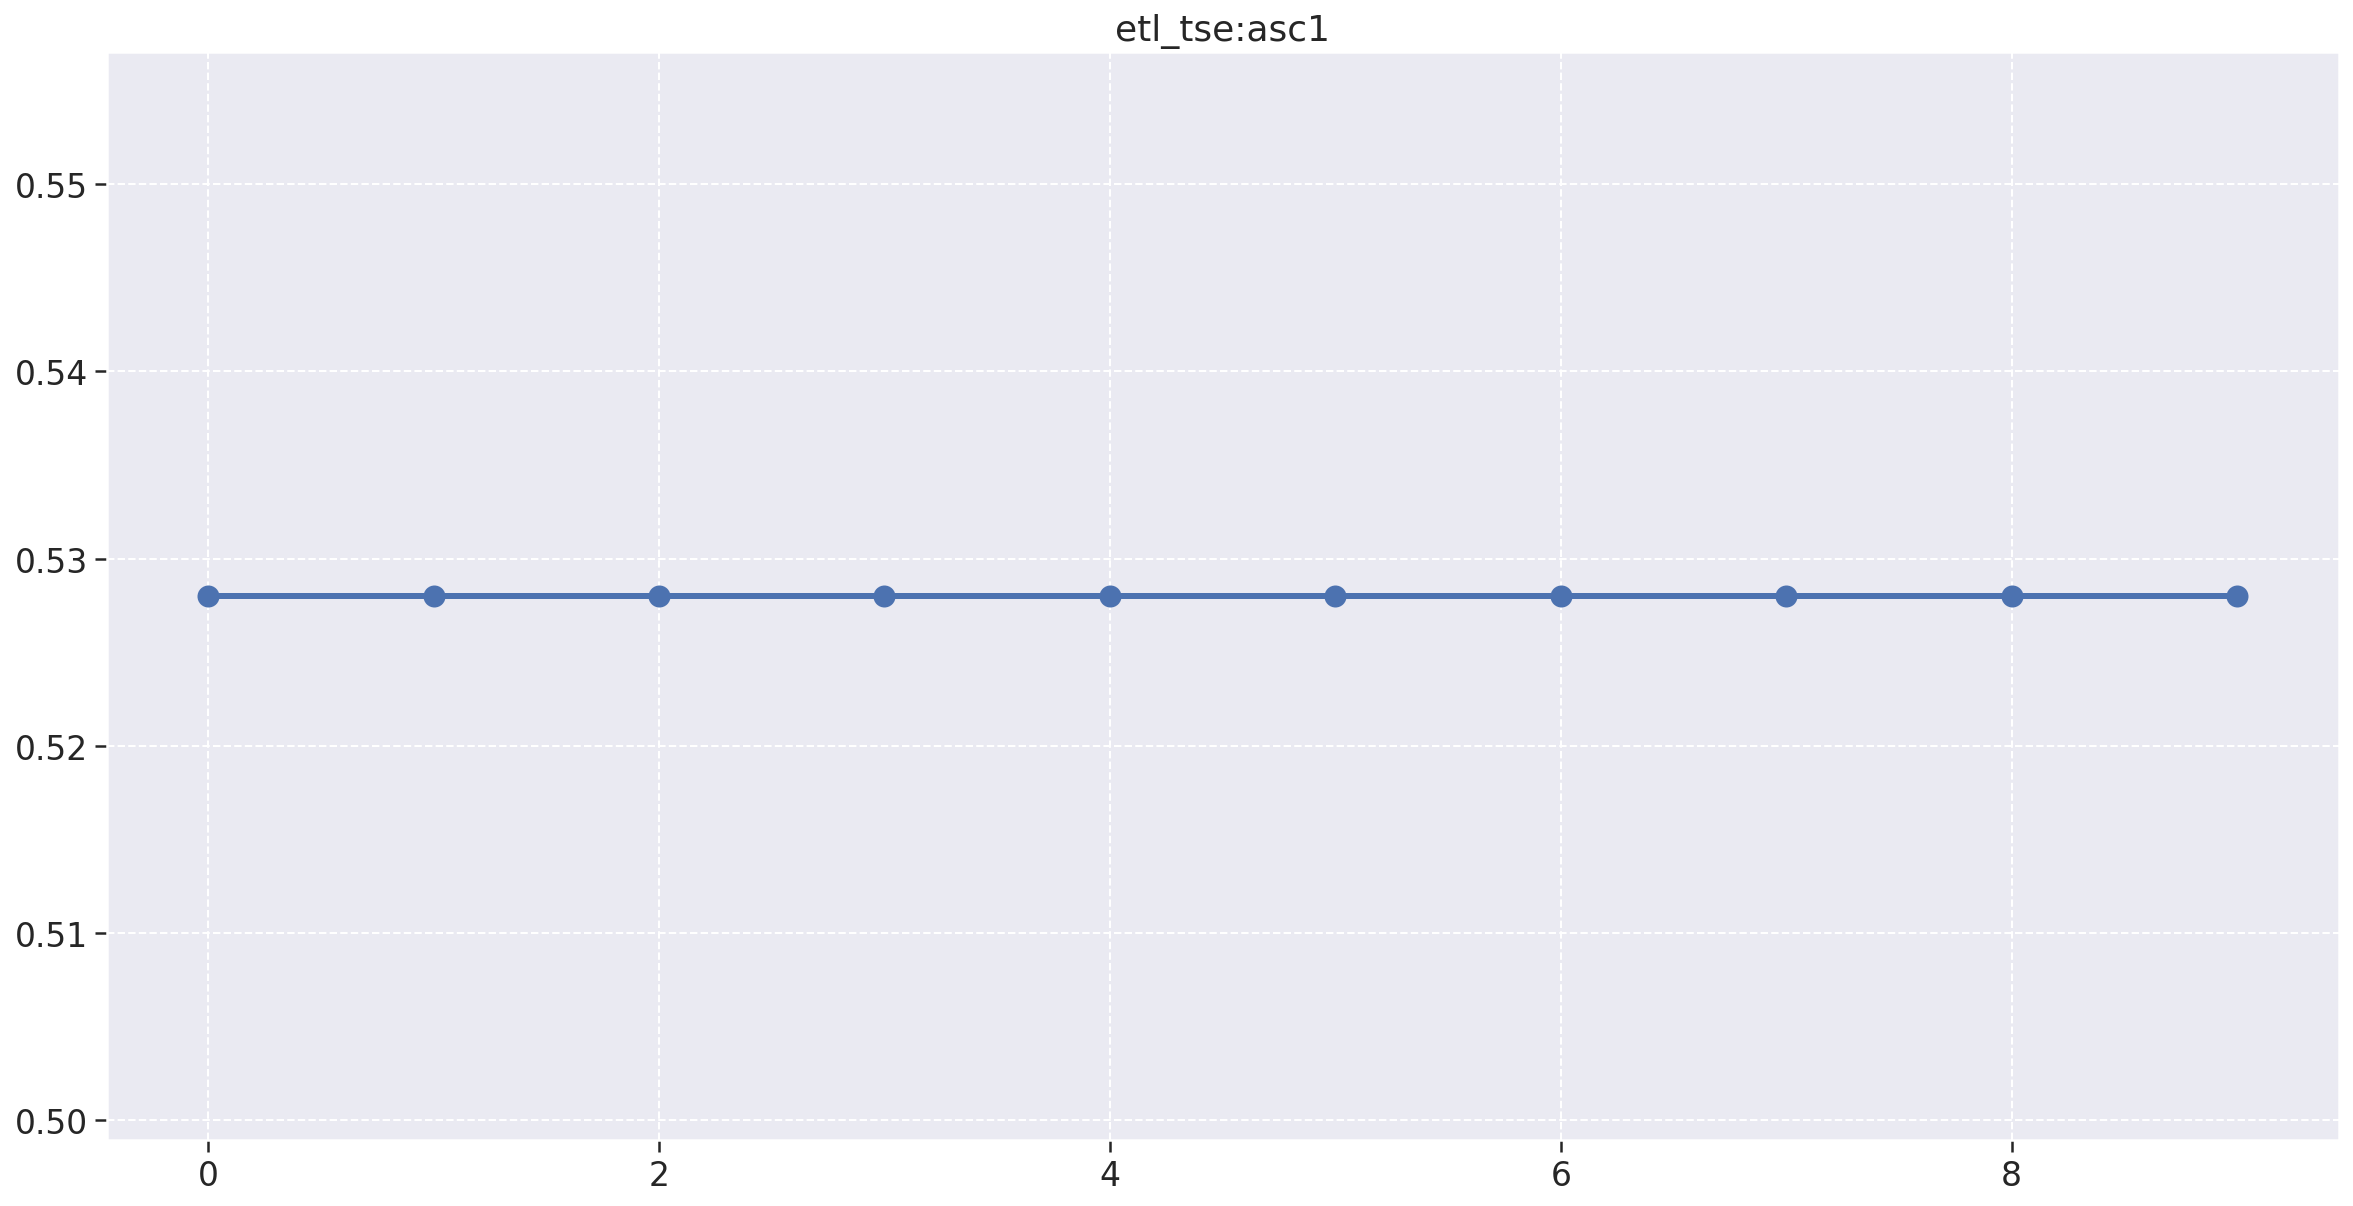

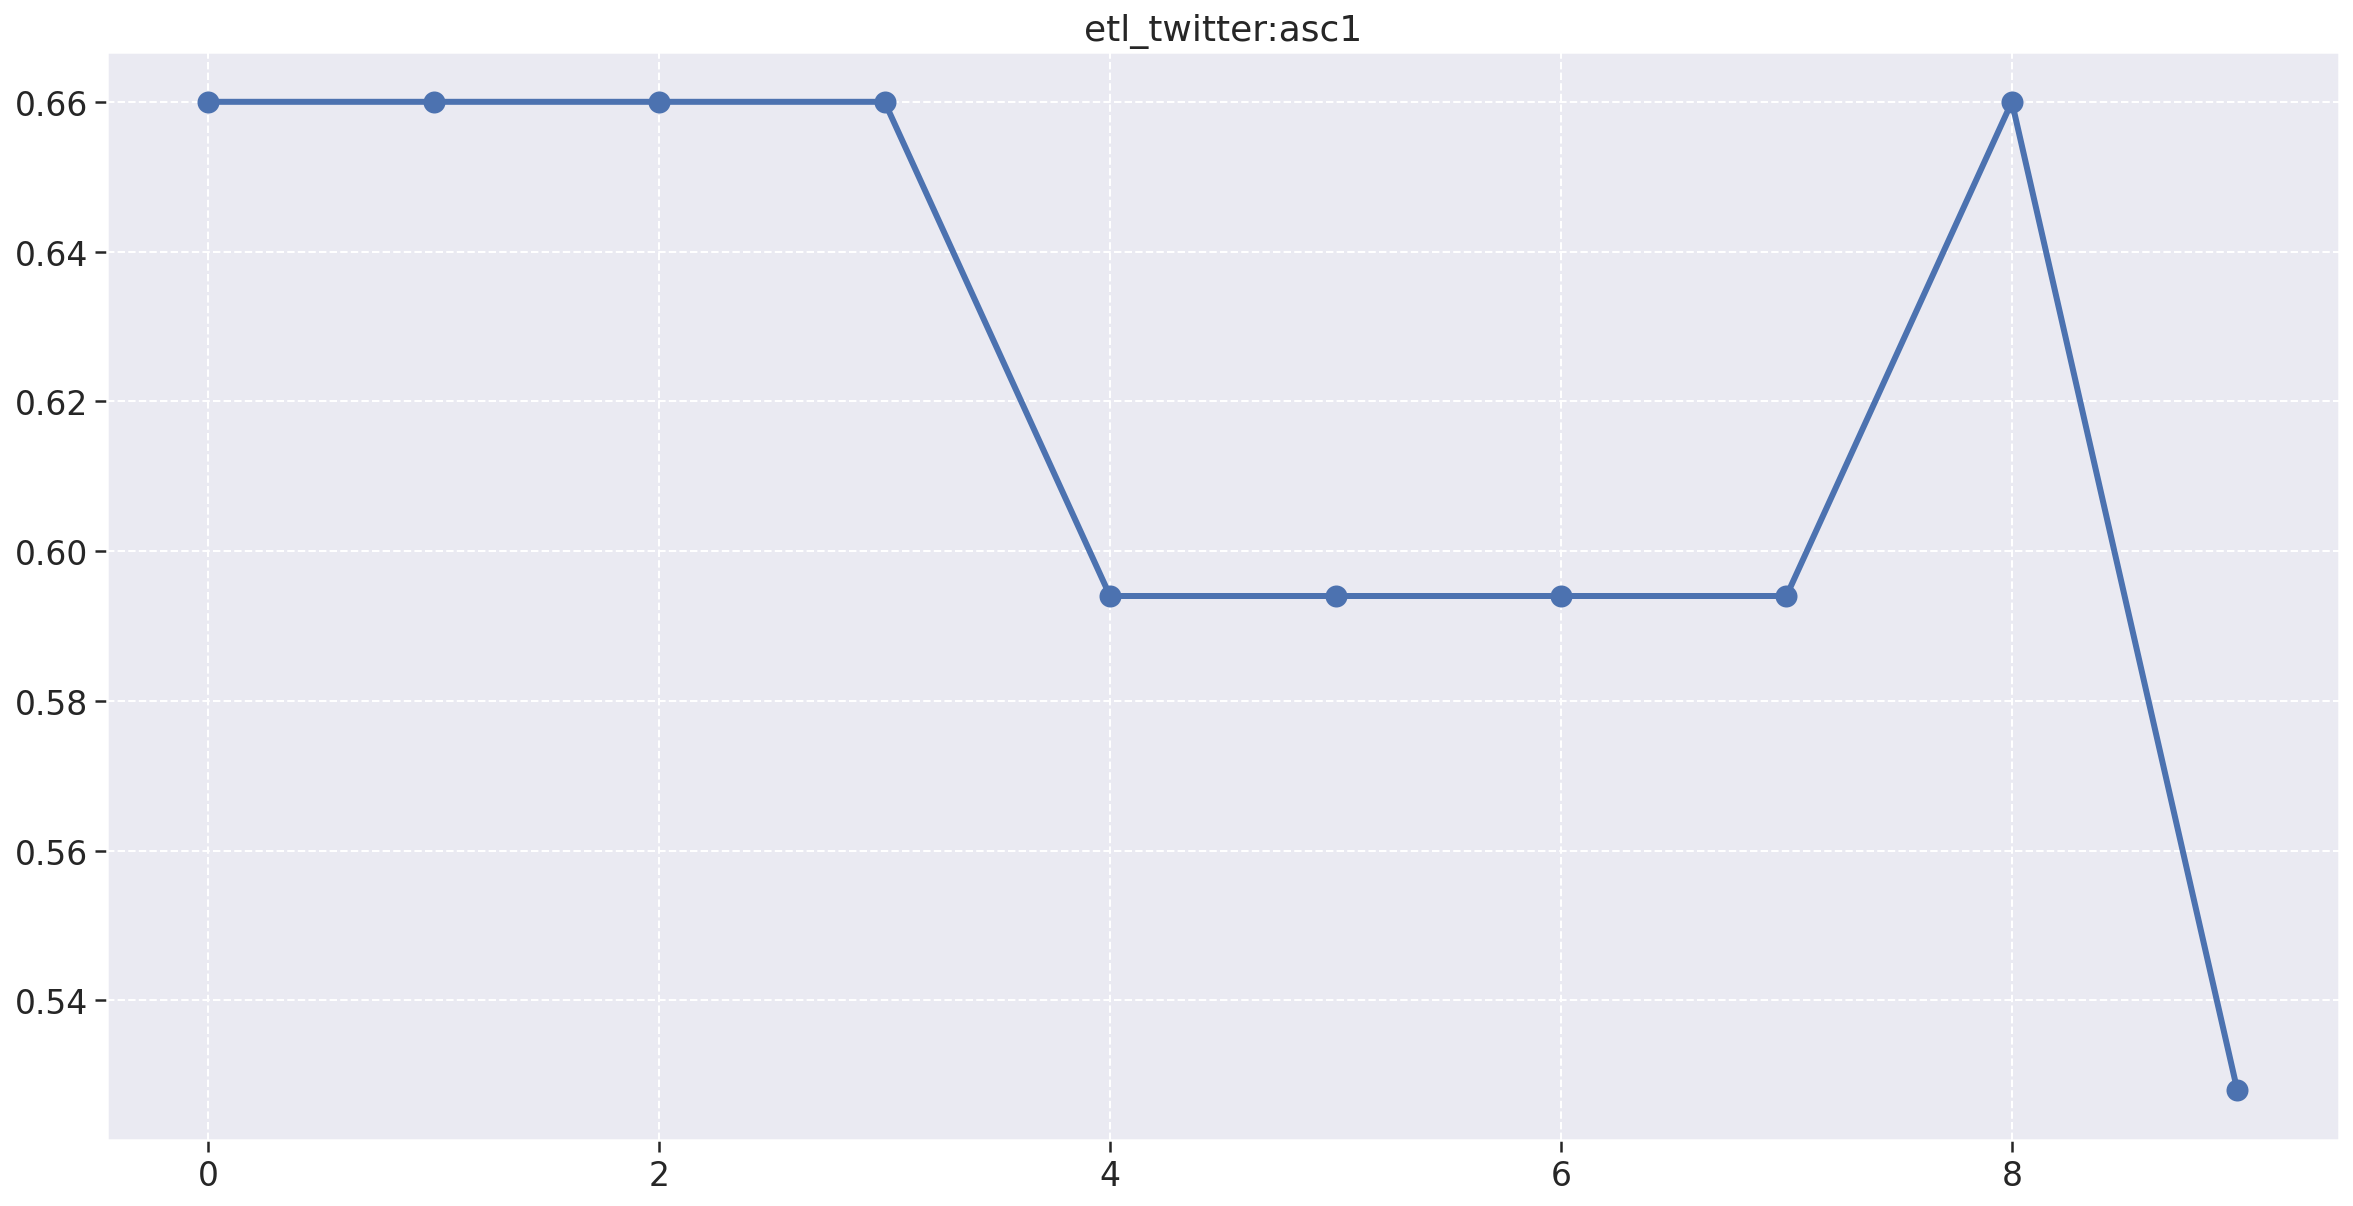

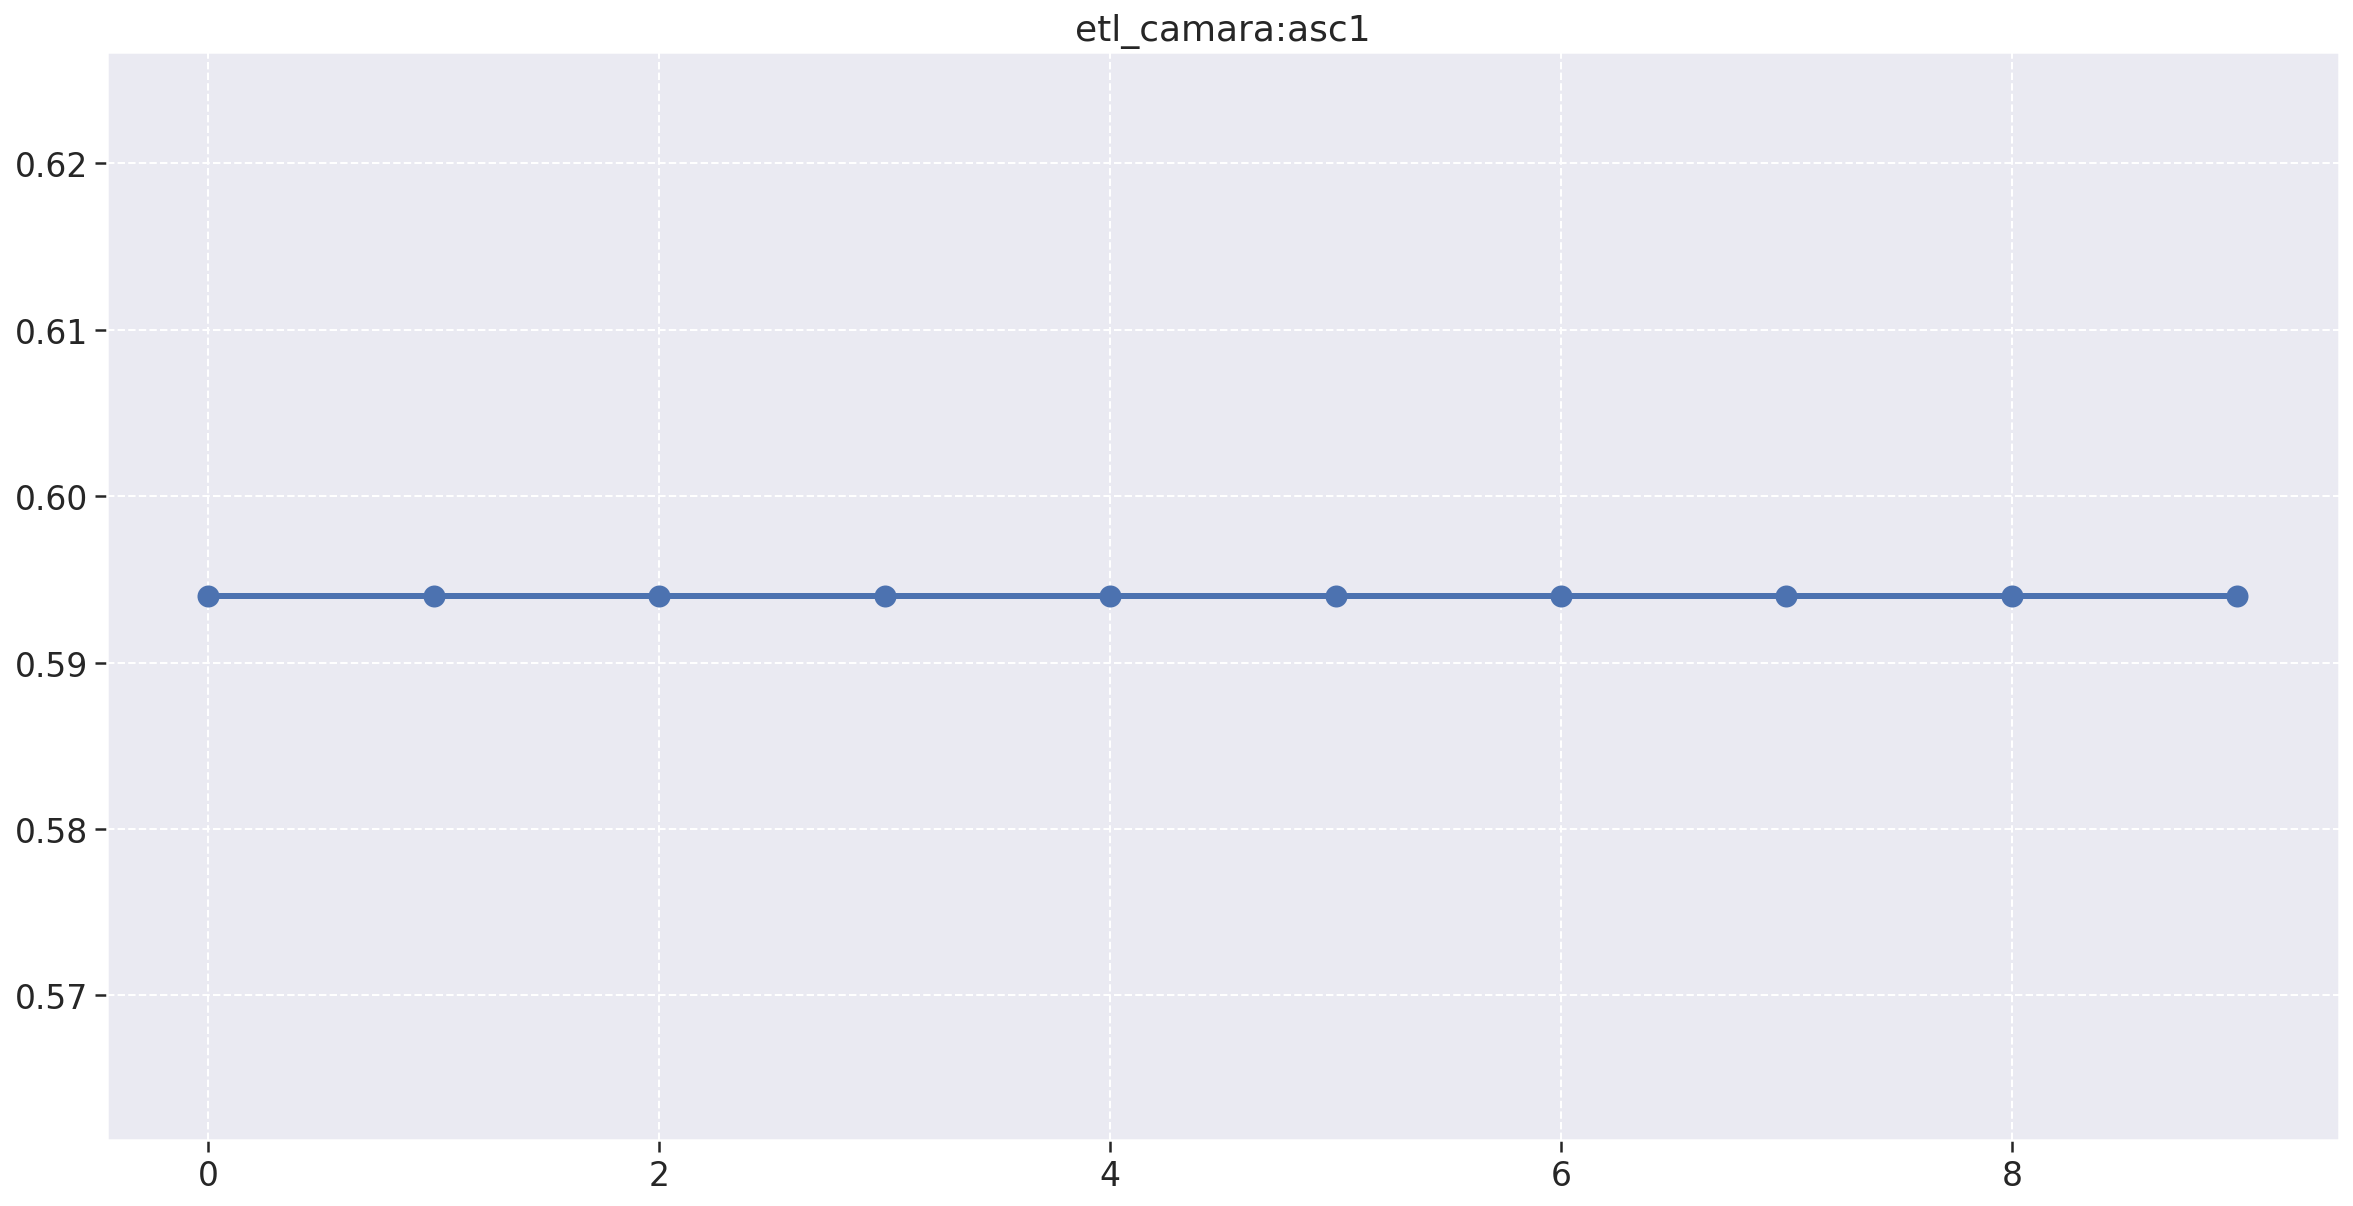

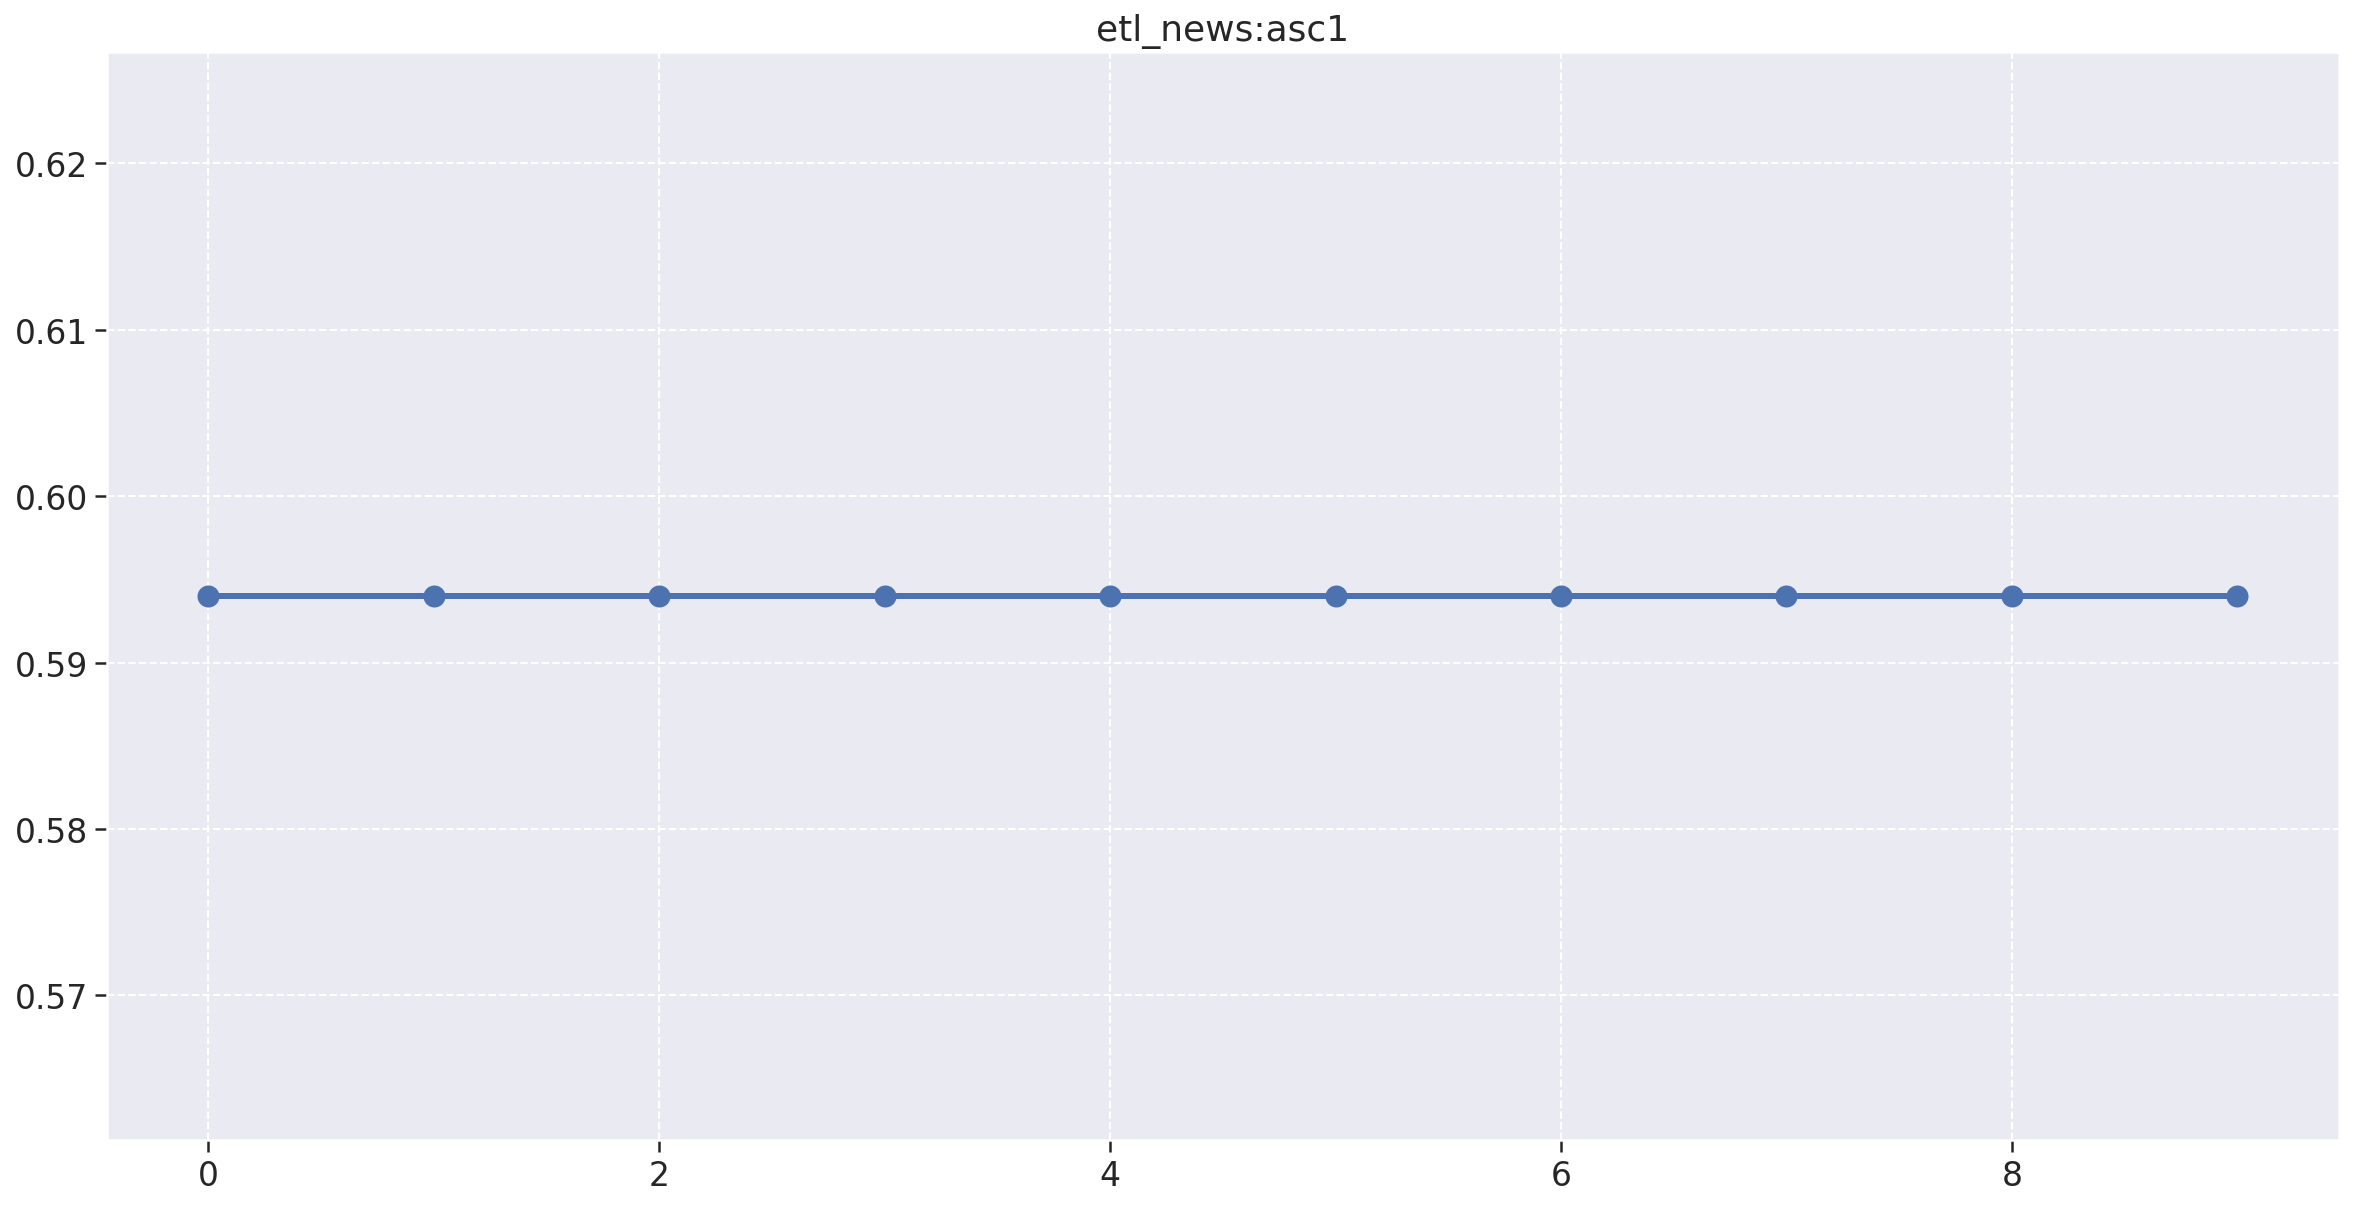

In [478]:
for repository, metrics_df in repository_metrics.items(): 
    fig = plt.figure(figsize=(20, 10))
    plt.title(f"{repository}:asc1")
    plt.plot(metrics_df['asc1'], linewidth=3, marker='o', markersize=10)

In [479]:
all_metrics_df = pd.DataFrame()

for repository, metrics_df in repository_metrics.items():
    all_metrics_df = pd.concat([all_metrics_df, metrics_df], ignore_index=True)

all_metrics_df['ac1'] = all_metrics_df['asc1'] * 1
all_metrics_df['total'] = all_metrics_df['asc1'] * 1

In [480]:
all_metrics_df

,m1,m2,m3,repository,version,asc1,ac1,total
0,0.966667,0.066667,1.000000,frontend,01-05-2021,0.671000,0.671000,0.671000
1,0.966667,0.066667,1.000000,frontend,02-05-2021,0.671000,0.671000,0.671000
2,0.966667,0.100000,1.000000,frontend,04-05-2021,0.682000,0.682000,0.682000
3,0.968750,0.093750,0.937500,frontend,09-05-2021,0.660000,0.660000,0.660000
4,0.968750,0.093750,0.937500,frontend,09-05-2021(1),0.660000,0.660000,0.660000
5,0.968750,0.093750,0.937500,frontend,09-05-2021(2),0.660000,0.660000,0.660000
6,0.968750,0.062500,0.937500,frontend,10-05-2021,0.649687,0.649687,0.649687
7,0.971429,0.057143,0.971429,frontend,10-05-2021(1),0.660000,0.660000,0.660000
8,0.964286,0.107143,1.000000,frontend,18-04-2021,0.683571,0.683571,0.683571
9,0.937500,0.125000,1.000000,frontend,23-03-2021,0.680625,0.680625,0.680625


In [481]:
all_metrics_df.to_excel('data/metrics_df.xlsx', index = False)